### changing env variable so i can use my GPU and adding my codes so i can import them as a library

In [1]:
import os
os.environ['HSA_OVERRIDE_GFX_VERSION']="10.3.0"

import sys
sys.path.append('/home/jimmy/Desktop/projects/notebooks/backup_beloved_code/python/')

## importation
***

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader , Dataset
import torcheval.metrics as metric
from useful_funcs import str_to_num
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import pingouin as pg
import seaborn as sns
import matplotlib.pylab as plt
from tqdm import tqdm
from missing_value_check import MSV_check
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

## just checking for GPU
***

In [3]:
torch.cuda.is_available()

True

# Functions
***

docstrings says well enough about how it works but doesnt talk about its logic or why these tests. all these tests are for when we have categorical predictor and a continuous target and we want to know if they have dependence relationship with each other so we can decide for feature selection. its important to note that they check univariate relationships not multivariate.
we go for each test and their assumptions.

1. ANOVA:<br>
this is a parametric test. its for when our categorical predictor consist of 3 groups (like all our data are or `A` or `B` or `C`) and each group has normal distribution and they have equal variance (homoscedasticity). what i mean for each group is all the continuous target values that their categorical predictor has `A` will be put in one group and same of `B` and same for `C`. now continuous values of these 3 groups that actually are our target values must have equal variance and they should be normal.
    * Null Hypothesis (H0): All group means are equal.
    * Alternative Hypothesis (H1): At least one group mean is different from the others.<br><br>

2. welch ANOVA:<br>
this is same as ANOVA but its for when our groups doesn't have the equal variance.
    * Null Hypothesis (H0): All group means are equal (similar to ANOVA).
    * Alternative Hypothesis (H1): At least one group mean is different from the others.<br><br>

3. Kruskal-Wallis:<br>
this is non-parametric test which means we dont need that our data have the normality and homoscedasticity assumptions. and it test what ANOVA tests.
    * Null Hypothesis (H0): All group distributions are equal.
    * Alternative Hypothesis (H1): At least one group distribution is different.<br><br>

4. t-test:<br>
this is like ANOVA but when we have 2 groups. remember, ANOVA require at least 3 groups in our categorical predictors. and this is parametric test so we need the assumptions of normality and homoscedasticity be met
    * Null Hypothesis (H0): The means of the two groups are equal.
    * Alternative Hypothesis (H1): The means of the two groups are not equal.<br><br>


5. mann-whitney U:<br>
this is non-parametric equal of t-test. so we dont require our data be normal and has homoscedasticity.
    * Null Hypothesis (H0): The distributions of the two groups are equal.
    * Alternative Hypothesis (H1): The distributions of the two groups are not equal.


In [4]:
def categorical_stest(data: pd.DataFrame, y: str, alpha: float = 0.05):


    """
    Perform statistical tests to determine if categorical variables in the data are correlated with the target variable y.

    This function provides a comprehensive approach to identifying correlations between categorical variables and a continuous 
    target variable. It iterates over each categorical variable in the input data, performs a series of statistical tests to 
    determine if the variable is correlated with the target variable y, and returns a DataFrame containing the test used, 
    p-value, and whether the variable is correlated with y.

    The type of statistical test used depends on the number of unique values in the categorical variable and the 
    normality and homoscedasticity of the data. For categorical variables with 3 or more unique values, the function 
    performs:

    - ANOVA (Analysis of Variance) if the data is normal and homoscedastic.
    - Welch ANOVA if the data is normal but not homoscedastic.
    - Kruskal-Wallis test if the data is not normal.

    For categorical variables with only 2 unique values, the function performs:

    - t-test if the data is normal and homoscedastic.
    - Mann-Whitney U test if the data is not normal or not homoscedastic.

    Parameters:
    - data (pd.DataFrame): The input data.
    - y (str): The name of the target variable.
    - alpha (float, optional): The significance level. Defaults to 0.05.

    Returns:
    - res (pd.DataFrame): A DataFrame containing the test used, p-value, and whether the variable is correlated with y.

    Notes:
    The function assumes that the input data is a pandas DataFrame and that the target variable y is a column in the DataFrame.
    """



    
    # Initialize an empty DataFrame to store the results
    res = pd.DataFrame(columns=['test', 'p-value', 'is_correlated'])

    # Get the list of columns in the data
    columns = list(data.columns)
    
    # Remove the target variable from the list of columns because we'll have issues when doing a test on itself like y with y test
    columns.remove(y)

    # Iterate over each column in the data
    for col in columns:
        # Get the unique values in the current column
        groups = data[col].value_counts().index
        group_count = len(groups)

        # If there are 3 or more unique values in the column
        if group_count >= 3:
            # Perform a normality test for each group
            normal = pg.normality(data = data, dv = y, group = col, alpha = 0.05)['normal']
            are_normal = normal.all()  # Check if all groups are normal

            # Perform a homoscedasticity test
            equal_var = pg.homoscedasticity(data = data , dv = y , group = col , alpha = 0.05)['equal_var']

            # If the data is normal and homoscedastic, use ANOVA
            if are_normal and equal_var:
                # Perform ANOVA and get the p-value
                anova_pvalue = pg.anova(data = data , dv= y , between = col)['p-unc'].iloc[0]
                test = 'ANOVA'
                p_value = anova_pvalue
                is_correlated = (p_value < alpha)

            # If the data is normal but not homoscedastic, use Welch ANOVA
            elif are_normal:
                # Perform Welch ANOVA and get the p-value
                wanova_pvalue = pg.welch_anova(data = data , dv = y , between = col)['p-unc'].iloc[0]
                test = 'Welch ANOVA'
                p_value = wanova_pvalue
                is_correlated = (p_value < alpha)

            # If the data is not normal, use Kruskal-Wallis test
            else:
                # Perform Kruskal-Wallis test and get the p-value
                kruskal_pvalue = pg.kruskal(data = data , dv = y , between = col)['p-unc'].iloc[0]
                test = 'Kruskal-Wallis'
                p_value = kruskal_pvalue
                is_correlated = (p_value < alpha)

            # Store the results in the DataFrame
            res.loc[col] = [test , round(p_value , 4) , is_correlated]

        # If there are only 2 unique values in the column
        else:
            # Perform a normality test for each group
            normal = pg.normality(data = data, dv = y, group=col, alpha = 0.05)['normal']
            are_normal = normal.all()

            # Perform a homoscedasticity test
            equal_var = pg.homoscedasticity(data = data , dv = y , group = col , alpha = 0.05)['equal_var']
            group_one_num, group_two_num = groups[0], groups[1]

            # Split the data into two groups
            group_one = data[data[col] == group_one_num][y]
            group_two = data[data[col] == group_two_num][y]

            # If the data is normal and homoscedastic, use t-test
            if are_normal and equal_var:
                # Perform t-test and get the p-value
                ttest_pvalue = pg.ttest(x = group_one, y = group_two)['p-val'].iloc[0]
                test = 't-test'
                p_value = ttest_pvalue
                is_correlated = (p_value < alpha)

            # If the data is not normal or not homoscedastic, use Mann-Whitney U test
            else:
                # Perform Mann-Whitney U test and get the p-value
                mwu_pvalue = pg.mwu(x = group_one , y = group_two)['p-val'].iloc[0]
                test = 'Mann-Whitney U'
                p_value = mwu_pvalue
                is_correlated = (p_value < alpha)

            # Store the results in the DataFrame
            res.loc[col] = [test , round(p_value , 4) , is_correlated]

    # Return the results
    return res


# Outlier Handling Function

This function handles outliers in a given pandas DataFrame.

## Functionality

The function identifies numerical columns, detects outliers using either the Z-score or IQR (Interquartile Range) method, and replaces them with a specified value.

### Detection Methods

*   **Z-score Method**: detects outliers as values that are more than 3 standard deviations away from the mean. 
    *   If Z-score upper or lower bound is more extreme than IQR bound, use Z-score bound; otherwise, use IQR bound.
*   **IQR Method**: detects outliers as values that are more than 1.5*IQR away from Q1 or Q3.

## Outlier Handling Strategy

*   **Z-score Method**: 
    *   If both upper and lower bounds used (i.e., `lower + upper != 0`), use median as strategy. This is because even if IQR is more extreme than Z-score, there might still be some outliers, and median is a more robust measure of central tendency in such cases.
    *   If only one bound used (i.e., `lower + upper == 0`), use mean as strategy.
*   **IQR Method**: always use mean as strategy.

## Return Values

*   **df**: The modified DataFrame with outliers handled. The function replaces outliers with the specified value based on the chosen strategy.
*   **res**: A DataFrame containing the outlier handling strategy used for each numerical column. The `strategy` column in `res` indicates the imputation strategy that is suitable for each column. For example, if the strategy is 'median', it means that the column has outliers and using the median is a good imputation strategy.

## Notes

*   The `lower` and `upper` variables are used to check if there are technically any outliers or not. If both `lower` and `upper` are 1, it means that there are outliers on both ends, and the median is used as the imputation strategy. If only one of them is 1, it means that there is an outlier on one end, and the median is still used. If neither is 1, it means that there are no outliers, and the mean can be used as the imputation strategy.

In [5]:
# this function assume that input dataframe has some numerical and non-numerical attributes.
# it detects numerical ones and deal with them. there should be no encoded categorical attributes
def deal_with_outliers(dataframe: pd.DataFrame , detection: str = 'z-score' , delete: bool = False):

    """
    This function handles outliers in a given pandas DataFrame. It identifies numerical columns, 
    detects outliers using either the Z-score or IQR (Interquartile Range) method, and replaces 
    them with a specified value.

    The function takes a DataFrame, a detection method, and a deletion flag as input. It returns 
    the modified DataFrame and a DataFrame containing the outlier handling strategy used for 
    each numerical column.

    The Z-score method detects outliers as values that are more than 3 standard deviations away 
    from the mean. If the Z-score upper or lower bound is more extreme than the corresponding 
    IQR bound, it uses the Z-score bound; otherwise, it uses the IQR bound. The outlier handling 
    strategy is chosen based on the bounds used: if both upper and lower bounds were used, 
    the median is used; otherwise, the mean is used.

    The IQR method detects outliers as values that are more than 1.5*IQR away from the first 
    quartile (Q1) or third quartile (Q3). The outlier handling strategy is always the mean.

    At the end, categorical columns will be added to res DataFrame so working with res table will be easier.

    Parameters
    ----------
    dataframe : pandas DataFrame
        The input DataFrame.
    detection : str, optional
        The outlier detection method to use. Can be 'z-score' or 'IQR'. Default is 'z-score'.
    delete : bool, optional
        A flag indicating whether to delete outliers or replace them. Default is False.

    Returns
    -------
    df : pandas DataFrame
        The modified DataFrame with outliers handled.
    res : pandas DataFrame
        A DataFrame containing the outlier handling strategy used for each numerical column.
    """




    
    res = pd.DataFrame(columns = ['strategy'])
    numerical_list = list(dataframe.select_dtypes(include = 'number').columns)
    categorical_columns = list(dataframe.select_dtypes(exclude = 'number').columns)

    df = dataframe.copy()
    dataframe = None


    for col in numerical_list:
        # calculating z-score
        df_mean = df[col].mean()
        df_std = df[col].std()
        df_zscore_upper = df_mean + (3 * df_std) # we use 3 so we have alpha = 99%
        df_zscore_lower = df_mean - (3 * df_std)

        # calculating IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        IQR_lowerbound = Q1 - (1.5 * IQR)
        IQR_upperbound = Q3 + (1.5 * IQR)


        if detection == 'z-score':

            # Determine upper bound for outlier detection using Z-score and IQR methods
            if df_zscore_upper > IQR_upperbound:
                # If Z-score upper bound is more extreme, use it to detect outliers
                is_outlier = (df[col] > df_zscore_upper)  # Identify values above Z-score upper bound
                outlier_index = df[col][is_outlier].index  # Get indices of outlier values

                if delete:
                    df.drop(outlier_index, inplace=True)
                else:
                    df.loc[outlier_index, col] = np.float32(df_zscore_upper)  # Replace outliers with Z-score upper bound

                upper = 1  # Flag indicating Z-score upper bound was used


            elif df_zscore_upper < IQR_upperbound:
                # If IQR upper bound is more extreme, use it to detect outliers
                is_outlier = (df[col] > IQR_upperbound)  # Identify values above IQR upper bound
                outlier_index = df[col][is_outlier].index  # Get indices of outlier values

                if delete:
                    df.drop(outlier_index, inplace=True)
                else:
                    df.loc[outlier_index, col] = np.float32(IQR_upperbound)  # Replace outliers with IQR upper bound

                upper = 0  # Flag indicating IQR upper bound was used


            if df_zscore_lower < IQR_lowerbound:
                # If z-score lower bound is more extreme, use it to detect outliers
                is_outlier = (df[col] < IQR_lowerbound)  # Identify values lower than Z-score lower bound
                outlier_index = df[col][is_outlier].index  # Get indices of outlier values

                if delete:
                    df.drop(outlier_index, inplace=True)
                else:
                    df.loc[outlier_index, col] = np.float32(df_zscore_lower)  # Replace outliers with Z-score lower bound

                lower = 1  # Flag indicating Z-score lower bound was used


            elif df_zscore_lower > IQR_lowerbound:
                # If IQR lower bound is more extreme, use it to detect outliers
                is_outlier = (df[col] < IQR_lowerbound)  # Identify values below IQR lower bound
                outlier_index = df[col][is_outlier].index  # Get indices of outlier values

                if delete:
                    df.drop(outlier_index, inplace=True)
                else:
                    df.loc[outlier_index, col] = np.float32(IQR_lowerbound)  # Replace outliers with IQR lower bound
                    
                lower = 0  # Flag indicating IQR lower bound was used



            # Choose outlier handling strategy based on bounds used
            if lower + upper != 0:
                # If both upper and lower bounds were used, use median as strategy
                strategy = 'median'
            else:
                # If only one bound was used, use mean as strategy
                strategy = 'mean'

            # Store strategy in result dataframe
            res.loc[col] = [strategy]

        elif detection == 'IQR':
            # Detect and handle outliers using IQR method
            is_outlier = (df[col] > IQR_upperbound)  # Identify values above IQR upper bound
            outlier_index = df[col][is_outlier].index  # Get indices of outlier values
            
            if delete:
                df.drop(outlier_index, inplace=True)
            else:
                df.loc[outlier_index, col] = IQR_upperbound 

            is_outlier = (df[col] < IQR_lowerbound)  # Identify values below IQR lower bound
            outlier_index = df[col][is_outlier].index  # Get indices of outlier values
            if delete:
                df.drop(outlier_index, inplace=True)
            else:
                df.loc[outlier_index, col] = IQR_lowerbound 

            # Outlier handling strategy: mean
            strategy = 'mean'

            # Store strategy in result dataframe
            res.loc[col] = [strategy]


    for col in categorical_columns: # adding categorical cols to res cuz it be easier to filter df using name of columns
        res.loc[col] = ['categorical']


    return df , res


# Loading Train Data
***

In [6]:
train = pd.read_csv('/run/media/jimmy/datasets/housing/house-prices-advanced-regression-techniques/train.csv')

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
Z = MSV_check(dataset = train , alpha = 0.05)
res_table , which_affect_which = Z.check_it()
clear_output()

### we dont want any column with more than 25% Nan values. this code shows all columns with more than 25% Nan values to drop. but this column `LotFrontage` has 17.74% Nan values and i want to drop that too. other columns than this have no Nan values and are fine

In [9]:
pd.set_option('display.max_rows', None)

which_to_drop = (res_table['missing_percentage(%)'] > 25) # bool mask for all columns with more than 25% missing values
which_to_fill = (0 < res_table['missing_percentage(%)']) & (res_table['missing_percentage(%)'] < 25) # bool mask for all columns with more than 0% and less than 25% missing values

drop_table = res_table[which_to_drop]
fill_table = res_table[which_to_fill]

print("columns to drop:")
display(drop_table)

print("columns to fill:")
display(fill_table)

# getting a list of names of columns to drop or fill
drop_list = list(drop_table.index) + ['LotFrontage'] # adding LotFrontage as i said in markdown
fill_list = list(fill_table.index)
fill_list.remove('LotFrontage') # and removing LotFrontage cuz it doesnt belong there 

pd.set_option('display.max_rows', 10)

columns to drop:


,not_missing,missing,missing_percentage(%),missing_value_type
Alley,91.0,1369.0,93.77,MNAR or MAR
MasVnrType,588.0,872.0,59.73,MNAR or MAR
FireplaceQu,770.0,690.0,47.26,MNAR or MAR
PoolQC,7.0,1453.0,99.52,MNAR or MAR
Fence,281.0,1179.0,80.75,MNAR or MAR
MiscFeature,54.0,1406.0,96.30,MNAR or MAR


columns to fill:


,not_missing,missing,missing_percentage(%),missing_value_type
LotFrontage,1201.0,259.0,17.74,MNAR or MAR
MasVnrArea,1452.0,8.0,0.55,MNAR or MAR
BsmtQual,1423.0,37.0,2.53,MNAR or MAR
BsmtCond,1423.0,37.0,2.53,MNAR or MAR
BsmtExposure,1422.0,38.0,2.60,MNAR or MAR
BsmtFinType1,1423.0,37.0,2.53,MNAR or MAR
BsmtFinType2,1422.0,38.0,2.60,MNAR or MAR
Electrical,1459.0,1.0,0.07,MNAR or MAR
GarageType,1379.0,81.0,5.55,MNAR or MAR
GarageYrBlt,1379.0,81.0,5.55,MNAR or MAR


In [10]:
dropped_train = train.drop(labels = drop_list , axis = 1) # drop all attributes that must be dropped

## now we check and do the same with test set
***

In [11]:
test = pd.read_csv('/run/media/jimmy/datasets/housing/house-prices-advanced-regression-techniques/test.csv') # this test dont have y because i gotta use this for answer in competition

In [12]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [13]:
D = MSV_check(dataset = test , alpha = 0.05)
test_res_table , test_which_affect_which = D.check_it()
clear_output()

In [14]:
pd.set_option('display.max_rows', None)

test_which_to_drop = (test_res_table['missing_percentage(%)'] > 25) # bool mask for all columns with more than 25% missing values
test_which_to_fill = (0 < test_res_table['missing_percentage(%)']) & (test_res_table['missing_percentage(%)'] < 25) # bool mask for all columns with more than 0% and less than 25% missing values

test_drop_table = test_res_table[test_which_to_drop]
test_fill_table = test_res_table[test_which_to_fill]

print("columns to drop:")
display(test_drop_table)

print("columns to fill:")
display(test_fill_table)

# getting a list of names of columns to drop or fill
test_drop_list = list(test_drop_table.index) + ['LotFrontage'] # adding LotFrontage as i said in markdown
test_fill_list = list(test_fill_table.index)
test_fill_list.remove('LotFrontage') # and removing LotFrontage cuz it doesnt belong there 

pd.set_option('display.max_rows', 10)

columns to drop:


,not_missing,missing,missing_percentage(%),missing_value_type
Alley,107.0,1352.0,92.67,MNAR or MAR
MasVnrType,565.0,894.0,61.27,MNAR or MAR
FireplaceQu,729.0,730.0,50.03,MNAR or MAR
PoolQC,3.0,1456.0,99.79,MNAR or MAR
Fence,290.0,1169.0,80.12,MNAR or MAR
MiscFeature,51.0,1408.0,96.50,MNAR or MAR


columns to fill:


,not_missing,missing,missing_percentage(%),missing_value_type
MSZoning,1455.0,4.0,0.27,MNAR or MAR
LotFrontage,1232.0,227.0,15.56,MNAR or MAR
Utilities,1457.0,2.0,0.14,MNAR or MAR
Exterior1st,1458.0,1.0,0.07,MNAR or MAR
Exterior2nd,1458.0,1.0,0.07,MNAR or MAR
MasVnrArea,1444.0,15.0,1.03,MNAR or MAR
BsmtQual,1415.0,44.0,3.02,MNAR or MAR
BsmtCond,1414.0,45.0,3.08,MNAR or MAR
BsmtExposure,1415.0,44.0,3.02,MNAR or MAR
BsmtFinType1,1417.0,42.0,2.88,MNAR or MAR


In [15]:
dropped_test = test.drop(labels = test_drop_list , axis = 1) # drop all attributes that must be dropped

## outlier and missing value handling of training data
***

### with the `deal_with_outliers` function we wrote we deal with'em

In [16]:
# filter Id column using iloc
train_df , train_res = deal_with_outliers(dataframe = dropped_train.iloc[: , 1:]) # i used same dropped_train because i dont have to change every occurrence ik name might not make sense
clear_output()

### the DataFrame below shows what strategy is best for our continuous attribues. for categorical attributes we should check if its nominal or ordinal. we will talk more about this topic in following cells 

In [17]:
train_res = train_res.loc[fill_list]

train_continuous_bmask = ((train_res['strategy'] == 'median') | (train_res['strategy'] == 'mean'))
train_categorical_bmask = (train_res['strategy'] == 'categorical')

train_continuous = train_res[train_continuous_bmask]
train_categorical = train_res[train_categorical_bmask]

print('best strategy for continuous attributes:')
display(train_continuous)

print('\nbest strategy for categorical attributes:')
display(train_categorical)

best strategy for continuous attributes:


,strategy
MasVnrArea,median
GarageYrBlt,mean



best strategy for categorical attributes:


,strategy
BsmtQual,categorical
BsmtCond,categorical
BsmtExposure,categorical
BsmtFinType1,categorical
BsmtFinType2,categorical
Electrical,categorical
GarageType,categorical
GarageFinish,categorical
GarageQual,categorical
GarageCond,categorical


## now we label encode the categorical labels

In [18]:
str2num_list = list(train_df.select_dtypes(include = 'string').columns) # names of all str columns
for i in str2num_list:
    train_df[i] = str_to_num(train_df[i])

attributes_dtypes = train_df.dtypes
print("do we have any non-numerical column is our train set now? " + str(('str' in attributes_dtypes) and ('object' in attributes_dtypes)))

display(train_df)

do we have any non-numerical column is our train set now? False


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60.0,1,8450.0,1,1,1,1,1,1,1,...,0.000000,0.0,0.0,0.0,0.000000,2,2008,1,1,208500.0
1,20.0,1,9600.0,1,1,1,1,2,1,2,...,0.000000,0.0,0.0,0.0,0.000000,5,2007,1,1,181500.0
2,60.0,1,11250.0,1,2,1,1,1,1,1,...,0.000000,0.0,0.0,0.0,0.000000,9,2008,1,1,223500.0
3,70.0,1,9550.0,1,2,1,1,3,1,3,...,205.311554,0.0,0.0,0.0,0.000000,2,2006,1,2,140000.0
4,60.0,1,14260.0,1,2,1,1,2,1,4,...,0.000000,0.0,0.0,0.0,0.000000,12,2008,1,1,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,1,7917.0,1,1,1,1,1,1,18,...,0.000000,0.0,0.0,0.0,0.000000,8,2007,1,1,175000.0
1456,20.0,1,13175.0,1,1,1,1,1,1,7,...,0.000000,0.0,0.0,0.0,0.000000,2,2010,1,1,210000.0
1457,70.0,1,9042.0,1,1,1,1,1,1,3,...,0.000000,0.0,0.0,0.0,1531.858154,5,2010,1,1,266500.0
1458,20.0,1,9717.0,1,1,1,1,1,1,12,...,112.000000,0.0,0.0,0.0,0.000000,4,2010,1,1,142125.0


##### this is dataframe of all columns that have missing values. we need to fill them all with a central tendency value. we need find the best central tendency for each. thats why we need to know if our categorical columns are nominal or ordinal. if its nominal we use mode and if its ordinal we use median. for continuous columns if we have outlier we use median and if we dont have any outliers we use mean. for outliers we are going to deal with them along the way.

##### just checking the table below with column informations i have it seems that `BsmtQual`, `BsmtCond`, `GarageQual`, `GarageCond`, `BsmtFinType1` and `BsmtFinType2` are ordinal attributes and `BsmtExposure` , `Electrical`, `GarageType` and `GarageFinish` are nominal attributes. we need to find ordinal or nominal by hand. i didnt find systematic way to do it

In [19]:
train_df[fill_list].describe()

,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
count,1452.000000,1423.0,1423.0,1422.0,1423.0,1422.0,1459.0,1379.0,1379.000000,1379.0,1379.0,1379.0
mean,98.943723,1.69993,1.113141,1.720816,2.71539,1.342475,1.156271,1.504714,1978.506164,1.949239,1.070341,1.059463
std,159.696608,0.726662,0.414899,1.137971,1.492535,1.032278,0.530529,0.818296,24.689725,0.747733,0.353478,0.341944
min,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1900.000000,1.0,1.0,1.0
25%,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1961.000000,1.0,1.0,1.0
50%,0.000000,2.0,1.0,1.0,3.0,1.0,1.0,1.0,1980.000000,2.0,1.0,1.0
75%,166.000000,2.0,1.0,2.0,3.0,1.0,1.0,2.0,2002.000000,3.0,1.0,1.0
max,646.883911,4.0,4.0,4.0,6.0,6.0,5.0,6.0,2010.000000,3.0,5.0,5.0


### it seems that Nan values of each attribute can be different as we can see in cell below. thats an issue when we want to impute cause the simple imputer of sklearn needs to know what type it is. we can make an observation that all the Nan values of categorical attributes have Nan value from pandas library but every Nan value from continuous attributes are from numpy library. this is important.

In [20]:
for i in fill_list:
    print(i , '==>' ,type(train_df[train_df[i].isna()][i].iloc[0])) # make a bool mask to find all Nan values and find type of first row

MasVnrArea ==> <class 'numpy.float64'>
BsmtQual ==> <class 'pandas._libs.missing.NAType'>
BsmtCond ==> <class 'pandas._libs.missing.NAType'>
BsmtExposure ==> <class 'pandas._libs.missing.NAType'>
BsmtFinType1 ==> <class 'pandas._libs.missing.NAType'>
BsmtFinType2 ==> <class 'pandas._libs.missing.NAType'>
Electrical ==> <class 'pandas._libs.missing.NAType'>
GarageType ==> <class 'pandas._libs.missing.NAType'>
GarageYrBlt ==> <class 'numpy.float64'>
GarageFinish ==> <class 'pandas._libs.missing.NAType'>
GarageQual ==> <class 'pandas._libs.missing.NAType'>
GarageCond ==> <class 'pandas._libs.missing.NAType'>


### and we create SimpleImputer object according to dtype of Nan values and the strategy that our attribute needs.

In [21]:
np_mean_imputer = SimpleImputer(missing_values = np.nan , strategy = 'mean') # npfp64 stands for numpy.float64
np_median_imputer = SimpleImputer(missing_values = np.nan , strategy = 'median')

pd_mode_imputer = SimpleImputer(missing_values = pd.NA , strategy = 'most_frequent') # most_frequent is mode
pd_median_impuer = SimpleImputer(missing_values = pd.NA , strategy = 'median')

### now we impute them accordingly

In [22]:
nominal_list = ['BsmtExposure' , 'Electrical', 'GarageType' , 'GarageFinish']
ordinal_list = ['BsmtQual' , 'BsmtCond' , 'GarageQual' , 'GarageCond' , 'BsmtFinType1' , 'BsmtFinType2']


for i in train_continuous.index: # imputing all nominal attributes
    if train_continuous.loc[i]['strategy'] == 'mean':
        train_df[i] = np_mean_imputer.fit_transform(train_df[i].to_frame())
    else:
        train_df[i] = np_median_imputer.fit_transform(train_df[i].to_frame())


for i in nominal_list: # imputing all nominal attributes
    train_df[i] = pd_mode_imputer.fit_transform(train_df[i].to_frame())


for i in ordinal_list: # imputing all ordinal attributes
    train_df[i] = pd_median_impuer.fit_transform(train_df[i].to_frame())

# now we do the same for test data. clearing test from missing values and outliers
***

In [23]:
# filter Id column using iloc
test_df , test_res = deal_with_outliers(dataframe = dropped_test.iloc[: , 1:]) # i used same dropped_train because i dont have to change every occurrence ik name might not make sense
clear_output()

In [24]:
test_res = test_res.loc[test_fill_list]

test_continuous_bmask = ((test_res['strategy'] == 'median') | (test_res['strategy'] == 'mean'))
test_categorical_bmask = (test_res['strategy'] == 'categorical')

test_continuous = test_res[test_continuous_bmask]
test_categorical = test_res[test_categorical_bmask]

print('best strategy for continuous attributes:')
display(test_continuous)

print('\nbest strategy for categorical attributes:')
display(test_categorical)

best strategy for continuous attributes:


,strategy
MasVnrArea,median
BsmtFinSF1,mean
BsmtFinSF2,median
BsmtUnfSF,median
TotalBsmtSF,median
BsmtFullBath,mean
BsmtHalfBath,median
GarageYrBlt,mean
GarageCars,median
GarageArea,median



best strategy for categorical attributes:


,strategy
MSZoning,categorical
Utilities,categorical
Exterior1st,categorical
Exterior2nd,categorical
BsmtQual,categorical
...,...
GarageType,categorical
GarageFinish,categorical
GarageQual,categorical
GarageCond,categorical


## and again, we label encode the categorical labels

In [25]:
test_str2num_list = list(test_df.select_dtypes(include = 'string').columns) # names of all str columns
for i in test_str2num_list:
    test_df[i] = str_to_num(test_df[i])

test_attributes_dtypes = test_df.dtypes
print("do we have any non-numerical column is our test set now? " + str(('str' in test_attributes_dtypes) and ('object' in test_attributes_dtypes)))

display(test_df)

do we have any non-numerical column is our test set now? False


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20.0,1,11622.0,1,1,1,1,1,1,1,...,0.0,0.0,0.0,120.0,0.0,0.000000,6,2010,1,1
1,20.0,2,14267.0,1,2,1,1,2,1,1,...,36.0,0.0,0.0,0.0,0.0,1950.588867,6,2010,1,1
2,60.0,2,13830.0,1,2,1,1,1,1,2,...,34.0,0.0,0.0,0.0,0.0,0.000000,3,2010,1,1
3,60.0,2,9978.0,1,2,1,1,1,1,2,...,36.0,0.0,0.0,0.0,0.0,0.000000,6,2010,1,1
4,120.0,2,5005.0,1,2,2,1,1,1,3,...,82.0,0.0,0.0,144.0,0.0,0.000000,1,2010,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160.0,3,1936.0,1,1,1,1,1,1,24,...,0.0,0.0,0.0,0.0,0.0,0.000000,6,2006,1,1
1455,160.0,3,1894.0,1,1,1,1,1,1,24,...,24.0,0.0,0.0,0.0,0.0,0.000000,4,2006,1,3
1456,20.0,2,20000.0,1,1,1,1,1,1,22,...,0.0,0.0,0.0,0.0,0.0,0.000000,9,2006,1,3
1457,85.0,2,10441.0,1,1,1,1,1,1,22,...,32.0,0.0,0.0,0.0,0.0,700.000000,7,2006,1,1


## now we need to find out which categorical is nominal and which one is ordinal and we gotta make our hands dirty

#### and it seems that `MSZoning` , `Utilities` , `Exterior1st` , `Exterior2nd` , `GarageType` , `GarageFinish` and `SaleType` are nominal and `BsmtQual` , `BsmtCond` , `BsmtExposure` , `BsmtFinType1` , `BsmtFinType2` , `KitchenQual` , `Functional` , `GarageQual` and `GarageCond` are ordinal.

In [26]:
test_categorical.index

Index(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'SaleType'],
      dtype='object')

## and again. we need to know what kind of Nan values they are

In [27]:
for i in test_fill_list:
        print(i , '==>' ,type(test_df[test_df[i].isna()][i].iloc[0])) # make a bool mask to find all Nan values and find type of first row

MSZoning ==> <class 'pandas._libs.missing.NAType'>
Utilities ==> <class 'pandas._libs.missing.NAType'>
Exterior1st ==> <class 'pandas._libs.missing.NAType'>
Exterior2nd ==> <class 'pandas._libs.missing.NAType'>
MasVnrArea ==> <class 'numpy.float64'>
BsmtQual ==> <class 'pandas._libs.missing.NAType'>
BsmtCond ==> <class 'pandas._libs.missing.NAType'>
BsmtExposure ==> <class 'pandas._libs.missing.NAType'>
BsmtFinType1 ==> <class 'pandas._libs.missing.NAType'>
BsmtFinSF1 ==> <class 'numpy.float64'>
BsmtFinType2 ==> <class 'pandas._libs.missing.NAType'>
BsmtFinSF2 ==> <class 'numpy.float64'>
BsmtUnfSF ==> <class 'numpy.float64'>
TotalBsmtSF ==> <class 'numpy.float64'>
BsmtFullBath ==> <class 'numpy.float64'>
BsmtHalfBath ==> <class 'numpy.float64'>
KitchenQual ==> <class 'pandas._libs.missing.NAType'>
Functional ==> <class 'pandas._libs.missing.NAType'>
GarageType ==> <class 'pandas._libs.missing.NAType'>
GarageYrBlt ==> <class 'numpy.float64'>
GarageFinish ==> <class 'pandas._libs.missing

## and then we go imputing!

In [28]:
test_nominal_list = ['MSZoning' , 'Utilities' , 'Exterior1st' , 'Exterior2nd' , 'GarageType' , 'GarageFinish' , 'SaleType']
test_ordinal_list = ['BsmtQual' , 'BsmtCond' , 'BsmtExposure' , 'BsmtFinType1' , 'BsmtFinType2' , 'KitchenQual' , 'Functional' , 'GarageQual' , 'GarageCond']


for i in test_continuous.index: # imputing all nominal attributes
    if test_continuous.loc[i]['strategy'] == 'mean':
        test_df[i] = np_mean_imputer.fit_transform(test_df[i].to_frame())
    else:
        test_df[i] = np_median_imputer.fit_transform(test_df[i].to_frame())


for i in test_nominal_list: # imputing all nominal attributes
    test_df[i] = pd_mode_imputer.fit_transform(test_df[i].to_frame())


for i in test_ordinal_list: # imputing all ordinal attributes
    test_df[i] = pd_median_impuer.fit_transform(test_df[i].to_frame())

## Feature selection
***

##### now we need to do some feature selection. cuz our task is regression we go by OLS but since we have categorical attribues (which we encoded them) the p-values of OLS for categorical attribues are not reliabel so we take a hybrid approach. we separate categorical attribues and numerical ones and we find good numerical attribues with OLS and good categorical attribues with ANOVA f-value. for separating we use `train` that has original dtypes and find categorical attribues using that dataframe and we remove names of attribues in `drop_list` because we dropped all those attribues.

In [29]:
str_list = train.select_dtypes('string').columns
num_list = train.select_dtypes('number').columns.drop('Id')

categorical_list = [cat_name for cat_name in str_list if cat_name not in drop_list]
numerical_list = [num_name for num_name in num_list if num_name not in drop_list]

categorical = train_df[categorical_list]
numerical = train_df[numerical_list]

##### now that we separated we apply OLS for `numerical` and ANOVA f-value for categorical. its important to note that `id` and `SalePrice` attribue is inside `numerical`. `SalePrice` is our target which we need for both OLS and ANOVA f-value. and we need to drop `id` and `SalePrice` from `numerical` because one is useless for training and one is our target.

In [30]:
y = numerical['SalePrice']
X_numerical = numerical.drop(['SalePrice'] , axis = 1)
X_numerical_ = sm.add_constant(X_numerical)

OLS_res = sm.OLS(endog = y , exog = X_numerical_).fit()
OLS_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     262.3
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        00:53:38   Log-Likelihood:                -16960.
No. Observations:                1460   AIC:                         3.399e+04
Df Residuals:                    1424   BIC:                         3.418e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.333e+05   1.11e+06      0.120      0.904   -2.04e+06    2.31e+06
MSSubClass     -116.6245     21.614     -5.396      0.000    -159.023     -74.226
LotArea           0.8066      0.167      4.839      0.000       0.480       1.134
OverallQual    1.504e+04    939.912     15.999      0.000    1.32e+04    1.69e+04
OverallCond    4967.3414    783.006      6.344      0.000    3431.372    6503.310
YearBuilt       294.1682     52.979      5.552      0.000     190.242     398.094
YearRemodAdd    166.4609     53.860      3.091      0.002      60.807     272.115
MasVnrArea       17.4383      5.288      3.298      0.001       7.066      27.811
BsmtFinSF1       16.2555     10.359      1.569      0.117      -4.065      36.576
BsmtFinSF2       -3.7683     14.108     -0.267      0.789     -31.442      23.906
BsmtUnfSF        -0.7455     10.534     -0.071      0.944     -21.409      19.918
TotalBsmtSF      14.4844      9.719      1.490      0.136      -4.581      33.550
1stFlrSF        -26.4969     13.454     -1.969      0.049     -52.888      -0.106
2ndFlrSF        -28.3560     12.899     -2.198      0.028     -53.659      -3.053
LowQualFinSF   -170.6549     50.575     -3.374      0.001    -269.865     -71.445
GrLivArea        85.9490     13.381      6.423      0.000      59.700     112.198
BsmtFullBath   3751.9599   2088.963      1.796      0.073    -345.815    7849.735
BsmtHalfBath  -4554.3890   4324.682     -1.053      0.292    -1.3e+04    3929.043
FullBath       -753.1155   2227.605     -0.338      0.735   -5122.855    3616.624
HalfBath      -2571.5690   2100.961     -1.224      0.221   -6692.880    1549.742
BedroomAbvGr  -8410.2531   1370.615     -6.136      0.000   -1.11e+04   -5721.612
KitchenAbvGr  -1.892e+04   6044.313     -3.131      0.002   -3.08e+04   -7066.828
TotRmsAbvGrd   2070.5390    977.187      2.119      0.034     153.658    3987.420
Fireplaces     3566.1639   1410.542      2.528      0.012     799.201    6333.127
GarageYrBlt     128.7265     54.656      2.355      0.019      21.512     235.941
GarageCars     7509.7374   2278.704      3.296      0.001    3039.760     1.2e+04
GarageArea        5.3703      7.991      0.672      0.502     -10.305      21.045
WoodDeckSF       20.0419      6.621      3.027      0.003       7.054      33.030
OpenPorchSF      15.7590     13.215      1.193      0.233     -10.163      41.681
EnclosedPorch    11.5355     15.030      0.768      0.443     -17.947      41.018
3SsnPorch        72.8210     63.386      1.149      0.251     -51.519     197.161
ScreenPorch      40.3422     17.093      2.360      0.018       6.813      73.872
PoolArea       -280.8542     87.744     -3.201      0.001    -452.975    -108.734
MiscVal          -1.7007      4.631     -0.367      0.713     -10.785       7.384
MoSold          177.8418    269.605      0.660   

### now we drop columns that dont contribute to our target.

In [31]:
fine_cols = [] # this is where we put the numerical or categorical columns that contribute to the target

pvalue_bmask = (OLS_res.pvalues < 0.05)
fine_numericals = list(OLS_res.pvalues[pvalue_bmask].index)
fine_cols += fine_numericals

### now we go for categorical ones

In [32]:
catPLUSy = pd.concat([categorical , y] , axis = 1)
result = categorical_stest(data = catPLUSy , y = 'SalePrice')
fine_categorical = list(result[result['is_correlated']].index)
fine_cols += fine_numericals
clear_output()

### and this dataframe below is the one we will train on. no outliers. no missing value. everything encoded. features selected. ready for training! but one thing i know is during feature selection i only selected features based on their univariate relationships and i couldn't address multivariate relationships because nothing came to my mind at the moment!

In [33]:
final_train = train_df[fine_cols]
final_train

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,1stFlrSF,2ndFlrSF,LowQualFinSF,...,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF,ScreenPorch,PoolArea
0,60.0,8450.0,7.0,5.00000,2003.0,2003,196.0,856.0,854,0.0,...,1710.0,3.0,1.0,8.0,0.0,2003.0,2,0.000000,0.0,0.0
1,20.0,9600.0,6.0,8.00000,1976.0,1976,0.0,1262.0,0,0.0,...,1262.0,3.0,1.0,6.0,1.0,1976.0,2,298.000000,0.0,0.0
2,60.0,11250.0,7.0,5.00000,2001.0,2002,162.0,920.0,866,0.0,...,1786.0,3.0,1.0,6.0,1.0,2001.0,2,0.000000,0.0,0.0
3,70.0,9550.0,7.0,5.00000,1915.0,1970,0.0,961.0,756,0.0,...,1717.0,3.0,1.0,7.0,1.0,1998.0,3,0.000000,0.0,0.0
4,60.0,14260.0,8.0,5.00000,2000.0,2000,350.0,1145.0,1053,0.0,...,2198.0,4.0,1.0,9.0,1.0,2000.0,3,192.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,7917.0,6.0,5.00000,1999.0,2000,0.0,953.0,694,0.0,...,1647.0,3.0,1.0,7.0,1.0,1999.0,2,0.000000,0.0,0.0
1456,20.0,13175.0,6.0,6.00000,1978.0,1988,119.0,2073.0,0,0.0,...,2073.0,3.0,1.0,7.0,2.0,1978.0,2,349.000000,0.0,0.0
1457,70.0,9042.0,7.0,8.91374,1941.0,2006,0.0,1188.0,1152,0.0,...,2340.0,4.0,1.0,9.0,2.0,1941.0,1,0.000000,0.0,0.0
1458,20.0,9717.0,5.0,6.00000,1950.0,1996,0.0,1078.0,0,0.0,...,1078.0,2.0,1.0,5.0,0.0,1950.0,1,366.000000,0.0,0.0


## now we go for long awaited training process!
***

#### we split into train and validation sets

In [34]:
xtrain , xvalid , ytrain , yvalid = train_test_split(final_train , y , random_state = 42 , test_size = 0.12)

In [35]:
class dataset_train(Dataset):
    def __init__(self , x: pd.DataFrame , y: pd.Series) -> None:
        super().__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self , idx):
        x_row = self.x.iloc[idx]
        y_row = self.y.iloc[idx]
        return torch.tensor(x_row , dtype = torch.float32), torch.tensor(y_row , dtype = torch.float32)
    

class dataset_test(Dataset):
    def __init__(self , x: pd.DataFrame) -> None:
        super().__init__()
        self.x = x

    def __len__(self):
        return len(self.x)

    def __getitem__(self , idx):
        x_row = self.x.iloc[idx]
        return torch.tensor(x_row , dtype = torch.float32)

In [41]:
class MLP(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.mlp = nn.Sequential(
            nn.Linear(in_features = 40 , out_features = 1000),
            nn.ReLU(),
            nn.Linear(in_features = 1000 , out_features = 500),
            nn.ReLU(),
            nn.Linear(in_features = 500 , out_features = 300),
            nn.ReLU(),
            nn.Linear(in_features = 300 , out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features = 100 , out_features = 1),
            nn.ReLU()
        )

    def forward(self , x):
        logits = self.mlp(x)
        return logits

In [42]:
device = 'cuda'
model = MLP().to(device)
print(model)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=40, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=300, bias=True)
    (5): ReLU()
    (6): Linear(in_features=300, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=1, bias=True)
    (9): ReLU()
  )
)


In [43]:
def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_func,
        optimizer,
        epochs = 10,
        early_stop_epoch = 30,
        validation_dl: DataLoader = None, # dl stands for dataloader
        metric = None):
    
    global_avg_losses = [] # appending after each epoch. its avg over all losses of each mini batches.
    valid_losses = [] # appending after each epoch
    metric_results = [] # appending after each epoch

    metric = metric.to(device) # moving metric to GPU for faster computation
    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch+1}\n-------------------------------------")

        model.train()
        accumulating_train_loss = 0
        for (x_batch , y_batch) in dataloader:
            x_batch , y_batch = x_batch.to(device) , y_batch.to(device)

            prediction = model(x_batch).squeeze(1) # we doing the squeeze because prediction.shape is (32,1) but y_batch.shape is (32)
            loss = loss_func(prediction , y_batch)
            accumulating_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()         
        
        if validation_dl != None:
                model.eval()
                val_loss = 0
                scale_val = 0
                epoch_without_change = 0

                with torch.no_grad():
                    for i , j in validation_dl:
                        i , j = i.to(device) , j.to(device)
                        prediction = model(i)
                        prediction = prediction.squeeze(1)
                        val_loss += loss_func(prediction , j).item() # accumulating losses of each batches
                        updated_metric = metric.update(j , prediction)
                
                metric_val = updated_metric.compute()
                metric.reset() # reseting to ensures that the metric states do not carry over data from previous epochs
                val_loss /= len(validation_dl) # avg validation losses

                print(f"Test Error: \n metric: {(metric_val)}, Avg test loss: {val_loss} , loss = {loss.item()} \n")

                epoch_without_change += 1

                if (metric_val > scale_val):
                     epoch_without_change = 0

                if (metric_val <= scale_val) and (epoch_without_change >= early_stop_epoch): # we dont need to train further if our metric (currently R2 score) is bigger than 0.96
                     break
                
                

        global_avg_losses.append((accumulating_train_loss / len(dataloader)))
        valid_losses.append(val_loss)
        metric_results.append(metric_val.item())
    
    return {'global_average_losses' : global_avg_losses , 'validation_losses' : valid_losses , 'metric_results' : metric_results}

In [44]:
batch_size = 32
tensor_fdf = dataset_train(x = xtrain , y = ytrain)
tensor_val = dataset_train(x = xvalid , y = yvalid)

train_dataloader = DataLoader(dataset = tensor_fdf , batch_size = batch_size , shuffle = True)
valid_dataloader = DataLoader(dataset = tensor_val , batch_size = batch_size , shuffle = True)

In [45]:
history = train_loop(
    dataloader = train_dataloader,
    model = model,
    loss_func = nn.MSELoss(),
    optimizer = Adam(model.parameters() , lr = 0.001),
    epochs = 1500,
    early_stop_epoch = 300,
    validation_dl = valid_dataloader,
    metric = metric.R2Score())

  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 1
-------------------------------------


/tmp/ipykernel_200034/2034908235.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(x_row , dtype = torch.float32), torch.tensor(y_row , dtype = torch.float32)
  0%|          | 1/1500 [00:00<16:08,  1.55it/s]

Test Error: 
 metric: -1.2977731227874756, Avg test loss: 4927502165.333333 , loss = 4645564416.0 

Epoch 2
-------------------------------------


  0%|          | 3/1500 [00:01<08:28,  2.94it/s]

Test Error: 
 metric: -3.374814510345459, Avg test loss: 3800292757.3333335 , loss = 5750690816.0 

Epoch 3
-------------------------------------
Test Error: 
 metric: -1.1162099838256836, Avg test loss: 2944798229.3333335 , loss = 306166880.0 

Epoch 4
-------------------------------------


  0%|          | 4/1500 [00:01<07:01,  3.55it/s]

Test Error: 
 metric: -0.08139634132385254, Avg test loss: 2186922730.6666665 , loss = 134211576.0 

Epoch 5
-------------------------------------


  0%|          | 6/1500 [00:01<05:55,  4.20it/s]

Test Error: 
 metric: 0.47191643714904785, Avg test loss: 1748364629.3333333 , loss = 1167253504.0 

Epoch 6
-------------------------------------
Test Error: 
 metric: 0.5278280973434448, Avg test loss: 2013809728.0 , loss = 1479092864.0 



  0%|          | 7/1500 [00:01<05:28,  4.55it/s]

Epoch 7
-------------------------------------
Test Error: 
 metric: 0.5441460609436035, Avg test loss: 1772255061.3333333 , loss = 959227776.0 

Epoch 8
-------------------------------------


  1%|          | 9/1500 [00:02<04:55,  5.04it/s]

Test Error: 
 metric: 0.5964175462722778, Avg test loss: 1549924096.0 , loss = 198000960.0 

Epoch 9
-------------------------------------
Test Error: 
 metric: 0.5810391902923584, Avg test loss: 1672964992.0 , loss = 853812736.0 

Epoch 10
-------------------------------------


  1%|          | 11/1500 [00:02<04:37,  5.36it/s]

Test Error: 
 metric: 0.5417864322662354, Avg test loss: 1792157717.3333333 , loss = 4931298304.0 

Epoch 11
-------------------------------------
Test Error: 
 metric: 0.5360662937164307, Avg test loss: 2499934293.3333335 , loss = 1031679552.0 

Epoch 12
-------------------------------------


  1%|          | 13/1500 [00:03<04:31,  5.48it/s]

Test Error: 
 metric: 0.5751800537109375, Avg test loss: 1709285397.3333333 , loss = 2356257280.0 

Epoch 13
-------------------------------------
Test Error: 
 metric: 0.6171805262565613, Avg test loss: 1613533557.3333333 , loss = 3746141184.0 

Epoch 14
-------------------------------------


  1%|          | 15/1500 [00:03<04:32,  5.44it/s]

Test Error: 
 metric: 0.5239659547805786, Avg test loss: 1803367616.0 , loss = 2840059904.0 

Epoch 15
-------------------------------------
Test Error: 
 metric: 0.6289345622062683, Avg test loss: 1870379072.0 , loss = 799761984.0 

Epoch 16
-------------------------------------


  1%|          | 17/1500 [00:03<04:24,  5.61it/s]

Test Error: 
 metric: 0.5865825414657593, Avg test loss: 1617945941.3333333 , loss = 1384139264.0 

Epoch 17
-------------------------------------
Test Error: 
 metric: 0.5957217812538147, Avg test loss: 1601063818.6666667 , loss = 5196313088.0 

Epoch 18
-------------------------------------


  1%|▏         | 19/1500 [00:04<04:20,  5.69it/s]

Test Error: 
 metric: 0.6104699373245239, Avg test loss: 1611232704.0 , loss = 673596288.0 

Epoch 19
-------------------------------------
Test Error: 
 metric: 0.6345888376235962, Avg test loss: 1706419605.3333333 , loss = 1494411520.0 

Epoch 20
-------------------------------------


  1%|▏         | 21/1500 [00:04<04:22,  5.63it/s]

Test Error: 
 metric: 0.62350994348526, Avg test loss: 1782399274.6666667 , loss = 319549216.0 

Epoch 21
-------------------------------------
Test Error: 
 metric: 0.4583647847175598, Avg test loss: 1925475904.0 , loss = 4852145152.0 

Epoch 22
-------------------------------------


  2%|▏         | 23/1500 [00:04<04:18,  5.70it/s]

Test Error: 
 metric: 0.6490732431411743, Avg test loss: 1747908970.6666667 , loss = 887389376.0 

Epoch 23
-------------------------------------
Test Error: 
 metric: 0.6434038877487183, Avg test loss: 1602408981.3333333 , loss = 1402324608.0 

Epoch 24
-------------------------------------


  2%|▏         | 25/1500 [00:05<04:15,  5.77it/s]

Test Error: 
 metric: 0.6287495493888855, Avg test loss: 1915159573.3333333 , loss = 1089289728.0 

Epoch 25
-------------------------------------
Test Error: 
 metric: 0.6565589308738708, Avg test loss: 1734619946.6666667 , loss = 3764560128.0 

Epoch 26
-------------------------------------


  2%|▏         | 27/1500 [00:05<04:13,  5.81it/s]

Test Error: 
 metric: 0.6819056272506714, Avg test loss: 1572341781.3333333 , loss = 1044610880.0 

Epoch 27
-------------------------------------
Test Error: 
 metric: 0.542298436164856, Avg test loss: 1819995264.0 , loss = 1113138688.0 

Epoch 28
-------------------------------------


  2%|▏         | 29/1500 [00:05<04:17,  5.72it/s]

Test Error: 
 metric: 0.5131659507751465, Avg test loss: 1832030805.3333333 , loss = 5345892864.0 

Epoch 29
-------------------------------------
Test Error: 
 metric: 0.6349678039550781, Avg test loss: 1768549173.3333333 , loss = 510349472.0 

Epoch 30
-------------------------------------


  2%|▏         | 31/1500 [00:06<04:18,  5.68it/s]

Test Error: 
 metric: 0.6677242517471313, Avg test loss: 1706768800.0 , loss = 442959008.0 

Epoch 31
-------------------------------------
Test Error: 
 metric: 0.5931843519210815, Avg test loss: 1616457962.6666667 , loss = 450776064.0 

Epoch 32
-------------------------------------


  2%|▏         | 33/1500 [00:06<04:16,  5.71it/s]

Test Error: 
 metric: 0.629960298538208, Avg test loss: 1601788032.0 , loss = 1187146112.0 

Epoch 33
-------------------------------------
Test Error: 
 metric: 0.640699028968811, Avg test loss: 1642745770.6666667 , loss = 6371098624.0 

Epoch 34
-------------------------------------


  2%|▏         | 35/1500 [00:06<04:17,  5.69it/s]

Test Error: 
 metric: 0.647709846496582, Avg test loss: 1569287221.3333333 , loss = 2432228352.0 

Epoch 35
-------------------------------------
Test Error: 
 metric: 0.5334972143173218, Avg test loss: 1753492096.0 , loss = 703271744.0 

Epoch 36
-------------------------------------


  2%|▏         | 37/1500 [00:07<04:20,  5.62it/s]

Test Error: 
 metric: 0.6706171035766602, Avg test loss: 1604196586.6666667 , loss = 1774821632.0 

Epoch 37
-------------------------------------
Test Error: 
 metric: 0.642135500907898, Avg test loss: 1644980618.6666667 , loss = 790925440.0 

Epoch 38
-------------------------------------


  3%|▎         | 39/1500 [00:07<04:25,  5.50it/s]

Test Error: 
 metric: 0.6546341180801392, Avg test loss: 1468700192.0 , loss = 589713536.0 

Epoch 39
-------------------------------------
Test Error: 
 metric: 0.6124907732009888, Avg test loss: 1598229514.6666667 , loss = 2039534464.0 

Epoch 40
-------------------------------------


  3%|▎         | 41/1500 [00:08<04:23,  5.53it/s]

Test Error: 
 metric: 0.5455360412597656, Avg test loss: 1770759872.0 , loss = 5193790976.0 

Epoch 41
-------------------------------------
Test Error: 
 metric: 0.6216995716094971, Avg test loss: 1579509781.3333333 , loss = 646318208.0 

Epoch 42
-------------------------------------


  3%|▎         | 43/1500 [00:08<04:20,  5.59it/s]

Test Error: 
 metric: 0.6390618681907654, Avg test loss: 1974563370.6666667 , loss = 1221687040.0 

Epoch 43
-------------------------------------
Test Error: 
 metric: 0.6768947839736938, Avg test loss: 1657160682.6666667 , loss = 141332352.0 

Epoch 44
-------------------------------------


  3%|▎         | 45/1500 [00:08<04:14,  5.71it/s]

Test Error: 
 metric: 0.6896235942840576, Avg test loss: 1564921514.6666667 , loss = 1325572864.0 

Epoch 45
-------------------------------------
Test Error: 
 metric: 0.37220507860183716, Avg test loss: 2337758080.0 , loss = 2397219328.0 

Epoch 46
-------------------------------------


  3%|▎         | 47/1500 [00:09<04:11,  5.78it/s]

Test Error: 
 metric: 0.6837924718856812, Avg test loss: 1470059082.6666667 , loss = 1580657408.0 

Epoch 47
-------------------------------------
Test Error: 
 metric: 0.6307389140129089, Avg test loss: 1549170261.3333333 , loss = 562242560.0 

Epoch 48
-------------------------------------


  3%|▎         | 49/1500 [00:09<04:11,  5.77it/s]

Test Error: 
 metric: 0.6788234114646912, Avg test loss: 1526895050.6666667 , loss = 285829408.0 

Epoch 49
-------------------------------------
Test Error: 
 metric: 0.6538862586021423, Avg test loss: 1526052416.0 , loss = 1081456128.0 

Epoch 50
-------------------------------------


  3%|▎         | 50/1500 [00:09<04:12,  5.73it/s]

Test Error: 
 metric: 0.7018100619316101, Avg test loss: 1451254549.3333333 , loss = 4211611648.0 

Epoch 51
-------------------------------------


  3%|▎         | 51/1500 [00:09<04:44,  5.09it/s]

Test Error: 
 metric: 0.6175037026405334, Avg test loss: 1574968618.6666667 , loss = 900431872.0 

Epoch 52
-------------------------------------


  3%|▎         | 52/1500 [00:10<05:19,  4.53it/s]

Test Error: 
 metric: 0.6769352555274963, Avg test loss: 1612565290.6666667 , loss = 436586560.0 

Epoch 53
-------------------------------------


  4%|▎         | 53/1500 [00:10<05:38,  4.28it/s]

Test Error: 
 metric: 0.7148878574371338, Avg test loss: 1478911786.6666667 , loss = 639314816.0 

Epoch 54
-------------------------------------


  4%|▎         | 54/1500 [00:10<05:51,  4.12it/s]

Test Error: 
 metric: 0.6575247049331665, Avg test loss: 1610457482.6666667 , loss = 785501376.0 

Epoch 55
-------------------------------------


  4%|▎         | 56/1500 [00:11<05:41,  4.23it/s]

Test Error: 
 metric: 0.6339048147201538, Avg test loss: 1777845834.6666667 , loss = 1309176192.0 

Epoch 56
-------------------------------------
Test Error: 
 metric: 0.6948901414871216, Avg test loss: 1498773194.6666667 , loss = 2833873920.0 

Epoch 57
-------------------------------------


  4%|▍         | 58/1500 [00:11<05:03,  4.74it/s]

Test Error: 
 metric: 0.6819965243339539, Avg test loss: 1503799701.3333333 , loss = 1083359104.0 

Epoch 58
-------------------------------------
Test Error: 
 metric: 0.5830402374267578, Avg test loss: 1760097493.3333333 , loss = 1716249216.0 

Epoch 59
-------------------------------------


  4%|▍         | 60/1500 [00:11<04:45,  5.04it/s]

Test Error: 
 metric: 0.6952174305915833, Avg test loss: 1579720442.6666667 , loss = 745311360.0 

Epoch 60
-------------------------------------
Test Error: 
 metric: 0.6231968402862549, Avg test loss: 1662364010.6666667 , loss = 4499840512.0 

Epoch 61
-------------------------------------


  4%|▍         | 62/1500 [00:12<04:33,  5.26it/s]

Test Error: 
 metric: 0.6474123001098633, Avg test loss: 1567055210.6666667 , loss = 2603963648.0 

Epoch 62
-------------------------------------
Test Error: 
 metric: 0.6842447519302368, Avg test loss: 1470679648.0 , loss = 993867648.0 

Epoch 63
-------------------------------------


  4%|▍         | 64/1500 [00:12<04:28,  5.34it/s]

Test Error: 
 metric: 0.6463489532470703, Avg test loss: 1667116032.0 , loss = 2234424576.0 

Epoch 64
-------------------------------------
Test Error: 
 metric: 0.6287105679512024, Avg test loss: 1509181418.6666667 , loss = 1887373696.0 

Epoch 65
-------------------------------------


  4%|▍         | 66/1500 [00:12<04:18,  5.55it/s]

Test Error: 
 metric: 0.7138990163803101, Avg test loss: 1493856373.3333333 , loss = 327729600.0 

Epoch 66
-------------------------------------
Test Error: 
 metric: 0.6804345846176147, Avg test loss: 1596561856.0 , loss = 891328704.0 

Epoch 67
-------------------------------------


  5%|▍         | 68/1500 [00:13<04:13,  5.65it/s]

Test Error: 
 metric: 0.6724412441253662, Avg test loss: 1672966773.3333333 , loss = 3669420288.0 

Epoch 68
-------------------------------------
Test Error: 
 metric: 0.6625921726226807, Avg test loss: 1591059114.6666667 , loss = 2369081856.0 

Epoch 69
-------------------------------------


  5%|▍         | 70/1500 [00:13<04:10,  5.70it/s]

Test Error: 
 metric: 0.6710024476051331, Avg test loss: 1638676736.0 , loss = 572155264.0 

Epoch 70
-------------------------------------
Test Error: 
 metric: 0.6848760843276978, Avg test loss: 1449273578.6666667 , loss = 834261760.0 

Epoch 71
-------------------------------------


  5%|▍         | 72/1500 [00:13<04:09,  5.72it/s]

Test Error: 
 metric: 0.6732083559036255, Avg test loss: 1567943744.0 , loss = 758323136.0 

Epoch 72
-------------------------------------
Test Error: 
 metric: 0.6249532699584961, Avg test loss: 1620101504.0 , loss = 1145618432.0 

Epoch 73
-------------------------------------


  5%|▍         | 74/1500 [00:14<04:08,  5.74it/s]

Test Error: 
 metric: 0.6895899772644043, Avg test loss: 1435756565.3333333 , loss = 1457671552.0 

Epoch 74
-------------------------------------
Test Error: 
 metric: 0.6893796920776367, Avg test loss: 1477779093.3333333 , loss = 2468259328.0 

Epoch 75
-------------------------------------


  5%|▌         | 76/1500 [00:14<04:10,  5.69it/s]

Test Error: 
 metric: 0.6571837663650513, Avg test loss: 1568024682.6666667 , loss = 609913216.0 

Epoch 76
-------------------------------------
Test Error: 
 metric: 0.6645885705947876, Avg test loss: 1540338304.0 , loss = 1687733376.0 

Epoch 77
-------------------------------------


  5%|▌         | 78/1500 [00:15<04:10,  5.68it/s]

Test Error: 
 metric: 0.6471331119537354, Avg test loss: 1561037717.3333333 , loss = 744562240.0 

Epoch 78
-------------------------------------
Test Error: 
 metric: 0.3707287907600403, Avg test loss: 2357616874.6666665 , loss = 289200480.0 

Epoch 79
-------------------------------------


  5%|▌         | 80/1500 [00:15<04:12,  5.62it/s]

Test Error: 
 metric: 0.6221466660499573, Avg test loss: 2410024448.0 , loss = 1200956800.0 

Epoch 80
-------------------------------------
Test Error: 
 metric: 0.571012020111084, Avg test loss: 1691919765.3333333 , loss = 1119836672.0 

Epoch 81
-------------------------------------


  5%|▌         | 82/1500 [00:15<04:07,  5.73it/s]

Test Error: 
 metric: 0.6604832410812378, Avg test loss: 1910271146.6666667 , loss = 266967136.0 

Epoch 82
-------------------------------------
Test Error: 
 metric: 0.6311181783676147, Avg test loss: 1642715744.0 , loss = 1433468928.0 

Epoch 83
-------------------------------------


  6%|▌         | 84/1500 [00:16<04:12,  5.61it/s]

Test Error: 
 metric: 0.6822591423988342, Avg test loss: 1519895381.3333333 , loss = 695837440.0 

Epoch 84
-------------------------------------
Test Error: 
 metric: 0.47654229402542114, Avg test loss: 1945024277.3333333 , loss = 441503872.0 

Epoch 85
-------------------------------------


  6%|▌         | 86/1500 [00:16<04:08,  5.68it/s]

Test Error: 
 metric: 0.6785880327224731, Avg test loss: 1595169749.3333333 , loss = 3598408704.0 

Epoch 86
-------------------------------------
Test Error: 
 metric: 0.694546103477478, Avg test loss: 1485240832.0 , loss = 66003584.0 

Epoch 87
-------------------------------------


  6%|▌         | 88/1500 [00:16<04:04,  5.77it/s]

Test Error: 
 metric: 0.7144766449928284, Avg test loss: 1432081216.0 , loss = 722676352.0 

Epoch 88
-------------------------------------
Test Error: 
 metric: 0.706939697265625, Avg test loss: 1794820661.3333333 , loss = 666407744.0 

Epoch 89
-------------------------------------


  6%|▌         | 90/1500 [00:17<04:02,  5.83it/s]

Test Error: 
 metric: 0.7115058302879333, Avg test loss: 1737894549.3333333 , loss = 2989308928.0 

Epoch 90
-------------------------------------
Test Error: 
 metric: 0.6959901452064514, Avg test loss: 1658507573.3333333 , loss = 938120832.0 

Epoch 91
-------------------------------------


  6%|▌         | 92/1500 [00:17<04:01,  5.84it/s]

Test Error: 
 metric: 0.6399767398834229, Avg test loss: 1555752138.6666667 , loss = 782942976.0 

Epoch 92
-------------------------------------
Test Error: 
 metric: 0.4870334267616272, Avg test loss: 1872248576.0 , loss = 1750175360.0 

Epoch 93
-------------------------------------


  6%|▋         | 94/1500 [00:17<04:02,  5.79it/s]

Test Error: 
 metric: 0.6911084651947021, Avg test loss: 1410754421.3333333 , loss = 2583714560.0 

Epoch 94
-------------------------------------
Test Error: 
 metric: 0.4308224320411682, Avg test loss: 2165449258.6666665 , loss = 2367827200.0 

Epoch 95
-------------------------------------


  6%|▋         | 96/1500 [00:18<04:04,  5.74it/s]

Test Error: 
 metric: 0.6949459314346313, Avg test loss: 1784966229.3333333 , loss = 2222017024.0 

Epoch 96
-------------------------------------
Test Error: 
 metric: 0.6013031005859375, Avg test loss: 1821543146.6666667 , loss = 302356544.0 

Epoch 97
-------------------------------------


  7%|▋         | 98/1500 [00:18<04:03,  5.76it/s]

Test Error: 
 metric: 0.7207809090614319, Avg test loss: 1626494346.6666667 , loss = 960716544.0 

Epoch 98
-------------------------------------
Test Error: 
 metric: 0.6929116249084473, Avg test loss: 1502252256.0 , loss = 749820416.0 

Epoch 99
-------------------------------------


  7%|▋         | 100/1500 [00:18<04:06,  5.69it/s]

Test Error: 
 metric: 0.6018366813659668, Avg test loss: 1615600874.6666667 , loss = 3214812160.0 

Epoch 100
-------------------------------------
Test Error: 
 metric: 0.6399096250534058, Avg test loss: 1677289834.6666667 , loss = 353862720.0 

Epoch 101
-------------------------------------


  7%|▋         | 102/1500 [00:19<04:03,  5.74it/s]

Test Error: 
 metric: 0.6728841066360474, Avg test loss: 1483131360.0 , loss = 442839616.0 

Epoch 102
-------------------------------------
Test Error: 
 metric: 0.6870864629745483, Avg test loss: 1486738741.3333333 , loss = 694546432.0 

Epoch 103
-------------------------------------


  7%|▋         | 104/1500 [00:19<04:00,  5.79it/s]

Test Error: 
 metric: 0.7090882658958435, Avg test loss: 1456596608.0 , loss = 4766831104.0 

Epoch 104
-------------------------------------
Test Error: 
 metric: 0.5875015258789062, Avg test loss: 1566316906.6666667 , loss = 2184459264.0 

Epoch 105
-------------------------------------


  7%|▋         | 106/1500 [00:19<03:59,  5.82it/s]

Test Error: 
 metric: 0.6107747554779053, Avg test loss: 1735649664.0 , loss = 2030008192.0 

Epoch 106
-------------------------------------
Test Error: 
 metric: 0.6801664233207703, Avg test loss: 1582798848.0 , loss = 175009152.0 

Epoch 107
-------------------------------------


  7%|▋         | 108/1500 [00:20<03:57,  5.86it/s]

Test Error: 
 metric: 0.6776953339576721, Avg test loss: 1591596117.3333333 , loss = 858174336.0 

Epoch 108
-------------------------------------
Test Error: 
 metric: 0.7119280099868774, Avg test loss: 1776352256.0 , loss = 631107136.0 

Epoch 109
-------------------------------------


  7%|▋         | 110/1500 [00:20<03:55,  5.90it/s]

Test Error: 
 metric: 0.718738317489624, Avg test loss: 1630045077.3333333 , loss = 3373005824.0 

Epoch 110
-------------------------------------
Test Error: 
 metric: 0.6693288087844849, Avg test loss: 1902507104.0 , loss = 5535695872.0 

Epoch 111
-------------------------------------


  7%|▋         | 112/1500 [00:20<03:57,  5.84it/s]

Test Error: 
 metric: 0.7082244753837585, Avg test loss: 1475867946.6666667 , loss = 2527521792.0 

Epoch 112
-------------------------------------
Test Error: 
 metric: 0.7228351831436157, Avg test loss: 1643408192.0 , loss = 4424024576.0 

Epoch 113
-------------------------------------


  8%|▊         | 114/1500 [00:21<03:57,  5.85it/s]

Test Error: 
 metric: 0.6528726816177368, Avg test loss: 1704089194.6666667 , loss = 3651610368.0 

Epoch 114
-------------------------------------
Test Error: 
 metric: 0.6707355976104736, Avg test loss: 1519284821.3333333 , loss = 1712213760.0 

Epoch 115
-------------------------------------


  8%|▊         | 116/1500 [00:21<03:56,  5.86it/s]

Test Error: 
 metric: 0.5737711191177368, Avg test loss: 1950056618.6666667 , loss = 2335324672.0 

Epoch 116
-------------------------------------
Test Error: 
 metric: 0.7354913949966431, Avg test loss: 1592422144.0 , loss = 594552128.0 

Epoch 117
-------------------------------------


  8%|▊         | 118/1500 [00:21<03:54,  5.89it/s]

Test Error: 
 metric: 0.6693062782287598, Avg test loss: 1555657045.3333333 , loss = 340261152.0 

Epoch 118
-------------------------------------
Test Error: 
 metric: 0.644024133682251, Avg test loss: 1561931285.3333333 , loss = 407617728.0 

Epoch 119
-------------------------------------


  8%|▊         | 120/1500 [00:22<03:53,  5.91it/s]

Test Error: 
 metric: 0.4607471227645874, Avg test loss: 2040624928.0 , loss = 2891757824.0 

Epoch 120
-------------------------------------
Test Error: 
 metric: 0.7342719435691833, Avg test loss: 1498841056.0 , loss = 169217920.0 

Epoch 121
-------------------------------------


  8%|▊         | 122/1500 [00:22<03:52,  5.93it/s]

Test Error: 
 metric: 0.5869989991188049, Avg test loss: 1564268640.0 , loss = 492346400.0 

Epoch 122
-------------------------------------
Test Error: 
 metric: 0.719306468963623, Avg test loss: 1365327210.6666667 , loss = 398733312.0 

Epoch 123
-------------------------------------


  8%|▊         | 124/1500 [00:22<03:50,  5.98it/s]

Test Error: 
 metric: 0.7283093929290771, Avg test loss: 1420382773.3333333 , loss = 556713216.0 

Epoch 124
-------------------------------------
Test Error: 
 metric: 0.21464532613754272, Avg test loss: 2677234282.6666665 , loss = 2763568128.0 

Epoch 125
-------------------------------------


  8%|▊         | 126/1500 [00:23<03:49,  6.00it/s]

Test Error: 
 metric: 0.6811591386795044, Avg test loss: 1442477781.3333333 , loss = 195879664.0 

Epoch 126
-------------------------------------
Test Error: 
 metric: 0.6448831558227539, Avg test loss: 1653217941.3333333 , loss = 567732032.0 

Epoch 127
-------------------------------------


  9%|▊         | 128/1500 [00:23<03:48,  6.02it/s]

Test Error: 
 metric: 0.708242654800415, Avg test loss: 1577276437.3333333 , loss = 206921648.0 

Epoch 128
-------------------------------------
Test Error: 
 metric: 0.7151156067848206, Avg test loss: 1461302304.0 , loss = 806172224.0 

Epoch 129
-------------------------------------


  9%|▊         | 130/1500 [00:23<03:48,  6.00it/s]

Test Error: 
 metric: 0.7068430781364441, Avg test loss: 1433034378.6666667 , loss = 2435091456.0 

Epoch 130
-------------------------------------
Test Error: 
 metric: 0.7269219160079956, Avg test loss: 1326264842.6666667 , loss = 212893968.0 

Epoch 131
-------------------------------------


  9%|▉         | 132/1500 [00:24<03:49,  5.97it/s]

Test Error: 
 metric: 0.7357860803604126, Avg test loss: 1738066165.3333333 , loss = 1420650880.0 

Epoch 132
-------------------------------------
Test Error: 
 metric: 0.7067312002182007, Avg test loss: 1414357781.3333333 , loss = 215111616.0 

Epoch 133
-------------------------------------


  9%|▉         | 134/1500 [00:24<03:48,  5.98it/s]

Test Error: 
 metric: 0.730192244052887, Avg test loss: 1527254410.6666667 , loss = 7749397504.0 

Epoch 134
-------------------------------------
Test Error: 
 metric: 0.6133404970169067, Avg test loss: 2492569834.6666665 , loss = 3767776768.0 

Epoch 135
-------------------------------------


  9%|▉         | 136/1500 [00:24<03:48,  5.97it/s]

Test Error: 
 metric: 0.7375864386558533, Avg test loss: 1468800234.6666667 , loss = 309186272.0 

Epoch 136
-------------------------------------
Test Error: 
 metric: 0.6897347569465637, Avg test loss: 1474495488.0 , loss = 573822080.0 

Epoch 137
-------------------------------------


  9%|▉         | 138/1500 [00:25<03:47,  5.98it/s]

Test Error: 
 metric: 0.6965996026992798, Avg test loss: 1538642997.3333333 , loss = 514219776.0 

Epoch 138
-------------------------------------
Test Error: 
 metric: 0.6984083652496338, Avg test loss: 1420891136.0 , loss = 603119744.0 

Epoch 139
-------------------------------------


  9%|▉         | 140/1500 [00:25<03:47,  5.98it/s]

Test Error: 
 metric: 0.7208727598190308, Avg test loss: 1535939637.3333333 , loss = 2963903488.0 

Epoch 140
-------------------------------------
Test Error: 
 metric: 0.7253854870796204, Avg test loss: 1279896149.3333333 , loss = 1200681856.0 

Epoch 141
-------------------------------------


  9%|▉         | 142/1500 [00:25<03:50,  5.89it/s]

Test Error: 
 metric: 0.7166664600372314, Avg test loss: 1538264010.6666667 , loss = 2480495360.0 

Epoch 142
-------------------------------------
Test Error: 
 metric: 0.582025408744812, Avg test loss: 1591537344.0 , loss = 387384576.0 

Epoch 143
-------------------------------------


 10%|▉         | 144/1500 [00:26<03:51,  5.86it/s]

Test Error: 
 metric: 0.7180566191673279, Avg test loss: 1613929952.0 , loss = 1972926720.0 

Epoch 144
-------------------------------------
Test Error: 
 metric: 0.6961134076118469, Avg test loss: 1500426368.0 , loss = 463170496.0 

Epoch 145
-------------------------------------


 10%|▉         | 146/1500 [00:26<03:52,  5.82it/s]

Test Error: 
 metric: 0.6411556005477905, Avg test loss: 1725261440.0 , loss = 646141376.0 

Epoch 146
-------------------------------------
Test Error: 
 metric: 0.7207611203193665, Avg test loss: 1342106634.6666667 , loss = 1309410304.0 

Epoch 147
-------------------------------------


 10%|▉         | 148/1500 [00:26<03:50,  5.86it/s]

Test Error: 
 metric: 0.743963897228241, Avg test loss: 1318331008.0 , loss = 394931200.0 

Epoch 148
-------------------------------------
Test Error: 
 metric: 0.7585334777832031, Avg test loss: 1368687285.3333333 , loss = 626676480.0 

Epoch 149
-------------------------------------


 10%|█         | 150/1500 [00:27<03:50,  5.86it/s]

Test Error: 
 metric: 0.6987699866294861, Avg test loss: 1522098773.3333333 , loss = 393875840.0 

Epoch 150
-------------------------------------
Test Error: 
 metric: 0.7597364187240601, Avg test loss: 1275224080.0 , loss = 2680257024.0 

Epoch 151
-------------------------------------


 10%|█         | 152/1500 [00:27<03:49,  5.89it/s]

Test Error: 
 metric: 0.6964936256408691, Avg test loss: 1513281365.3333333 , loss = 2115567872.0 

Epoch 152
-------------------------------------
Test Error: 
 metric: 0.7581116557121277, Avg test loss: 1301496576.0 , loss = 137208192.0 

Epoch 153
-------------------------------------


 10%|█         | 154/1500 [00:28<03:51,  5.81it/s]

Test Error: 
 metric: 0.6824213266372681, Avg test loss: 1605838762.6666667 , loss = 577375872.0 

Epoch 154
-------------------------------------
Test Error: 
 metric: 0.6295854449272156, Avg test loss: 1538288746.6666667 , loss = 151301840.0 

Epoch 155
-------------------------------------


 10%|█         | 156/1500 [00:28<03:49,  5.86it/s]

Test Error: 
 metric: 0.7370302677154541, Avg test loss: 1715910976.0 , loss = 385131136.0 

Epoch 156
-------------------------------------
Test Error: 
 metric: 0.7308793067932129, Avg test loss: 1522232960.0 , loss = 366896192.0 

Epoch 157
-------------------------------------


 11%|█         | 158/1500 [00:28<03:47,  5.90it/s]

Test Error: 
 metric: 0.6041691303253174, Avg test loss: 2292276288.0 , loss = 706065088.0 

Epoch 158
-------------------------------------
Test Error: 
 metric: 0.6877024173736572, Avg test loss: 1364720128.0 , loss = 237981952.0 

Epoch 159
-------------------------------------


 11%|█         | 160/1500 [00:29<03:48,  5.87it/s]

Test Error: 
 metric: 0.6858699917793274, Avg test loss: 1558969344.0 , loss = 1497703424.0 

Epoch 160
-------------------------------------
Test Error: 
 metric: 0.7556111216545105, Avg test loss: 1269052672.0 , loss = 1070542208.0 

Epoch 161
-------------------------------------


 11%|█         | 162/1500 [00:29<03:50,  5.82it/s]

Test Error: 
 metric: 0.7620943188667297, Avg test loss: 1359115818.6666667 , loss = 2824020736.0 

Epoch 162
-------------------------------------
Test Error: 
 metric: 0.7237818837165833, Avg test loss: 1342276981.3333333 , loss = 3494707456.0 

Epoch 163
-------------------------------------


 11%|█         | 164/1500 [00:29<03:49,  5.83it/s]

Test Error: 
 metric: 0.7389024496078491, Avg test loss: 1440052522.6666667 , loss = 35037532.0 

Epoch 164
-------------------------------------
Test Error: 
 metric: 0.7526848316192627, Avg test loss: 1463781994.6666667 , loss = 1212356352.0 

Epoch 165
-------------------------------------


 11%|█         | 166/1500 [00:30<03:48,  5.84it/s]

Test Error: 
 metric: 0.727121114730835, Avg test loss: 1759806304.0 , loss = 418308992.0 

Epoch 166
-------------------------------------
Test Error: 
 metric: 0.6335086226463318, Avg test loss: 1524116608.0 , loss = 391009472.0 

Epoch 167
-------------------------------------


 11%|█         | 168/1500 [00:30<03:46,  5.87it/s]

Test Error: 
 metric: 0.740532398223877, Avg test loss: 1426642069.3333333 , loss = 154912736.0 

Epoch 168
-------------------------------------
Test Error: 
 metric: 0.7705829739570618, Avg test loss: 1417185557.3333333 , loss = 1573247616.0 

Epoch 169
-------------------------------------


 11%|█▏        | 170/1500 [00:30<03:46,  5.88it/s]

Test Error: 
 metric: 0.6704294085502625, Avg test loss: 1359577045.3333333 , loss = 780823808.0 

Epoch 170
-------------------------------------
Test Error: 
 metric: 0.6189560890197754, Avg test loss: 1629615381.3333333 , loss = 820028544.0 

Epoch 171
-------------------------------------


 11%|█▏        | 172/1500 [00:31<03:52,  5.72it/s]

Test Error: 
 metric: 0.6989473104476929, Avg test loss: 1472018581.3333333 , loss = 3165401344.0 

Epoch 172
-------------------------------------
Test Error: 
 metric: 0.7274233102798462, Avg test loss: 1445206154.6666667 , loss = 1873806592.0 

Epoch 173
-------------------------------------


 12%|█▏        | 174/1500 [00:31<03:57,  5.59it/s]

Test Error: 
 metric: 0.7184491753578186, Avg test loss: 1405160170.6666667 , loss = 1038070336.0 

Epoch 174
-------------------------------------
Test Error: 
 metric: 0.7411160469055176, Avg test loss: 1298127765.3333333 , loss = 183420560.0 

Epoch 175
-------------------------------------


 12%|█▏        | 176/1500 [00:31<03:50,  5.76it/s]

Test Error: 
 metric: 0.6904152631759644, Avg test loss: 1425415264.0 , loss = 1660152192.0 

Epoch 176
-------------------------------------
Test Error: 
 metric: 0.7367173433303833, Avg test loss: 1509019776.0 , loss = 573973760.0 

Epoch 177
-------------------------------------


 12%|█▏        | 178/1500 [00:32<03:46,  5.83it/s]

Test Error: 
 metric: 0.7413451671600342, Avg test loss: 1491034901.3333333 , loss = 257478528.0 

Epoch 178
-------------------------------------
Test Error: 
 metric: 0.756382942199707, Avg test loss: 1262082880.0 , loss = 1272138752.0 

Epoch 179
-------------------------------------


 12%|█▏        | 180/1500 [00:32<03:47,  5.80it/s]

Test Error: 
 metric: 0.7379701137542725, Avg test loss: 1528961141.3333333 , loss = 4645981696.0 

Epoch 180
-------------------------------------
Test Error: 
 metric: 0.7368192076683044, Avg test loss: 1355372042.6666667 , loss = 1608656256.0 

Epoch 181
-------------------------------------


 12%|█▏        | 182/1500 [00:32<03:55,  5.59it/s]

Test Error: 
 metric: 0.7034996747970581, Avg test loss: 1337868245.3333333 , loss = 231849456.0 

Epoch 182
-------------------------------------
Test Error: 
 metric: 0.6547020673751831, Avg test loss: 1394182272.0 , loss = 2008856960.0 

Epoch 183
-------------------------------------


 12%|█▏        | 184/1500 [00:33<04:05,  5.36it/s]

Test Error: 
 metric: 0.6875467300415039, Avg test loss: 1461047232.0 , loss = 429763936.0 

Epoch 184
-------------------------------------
Test Error: 
 metric: 0.6377407312393188, Avg test loss: 2061344704.0 , loss = 1552008832.0 

Epoch 185
-------------------------------------


 12%|█▏        | 186/1500 [00:33<03:58,  5.51it/s]

Test Error: 
 metric: 0.7185582518577576, Avg test loss: 1333385674.6666667 , loss = 359390848.0 

Epoch 186
-------------------------------------
Test Error: 
 metric: 0.7487702369689941, Avg test loss: 1502413866.6666667 , loss = 2215643904.0 

Epoch 187
-------------------------------------


 12%|█▏        | 187/1500 [00:33<04:22,  5.01it/s]

Test Error: 
 metric: 0.7836798429489136, Avg test loss: 1320557781.3333333 , loss = 1769437568.0 

Epoch 188
-------------------------------------


 13%|█▎        | 189/1500 [00:34<04:23,  4.97it/s]

Test Error: 
 metric: 0.7574613690376282, Avg test loss: 1295534101.3333333 , loss = 1597350784.0 

Epoch 189
-------------------------------------
Test Error: 
 metric: 0.7186143398284912, Avg test loss: 1900324469.3333333 , loss = 4240985856.0 

Epoch 190
-------------------------------------


 13%|█▎        | 191/1500 [00:34<04:10,  5.22it/s]

Test Error: 
 metric: 0.6559455394744873, Avg test loss: 1409524202.6666667 , loss = 752881792.0 

Epoch 191
-------------------------------------
Test Error: 
 metric: 0.7388150095939636, Avg test loss: 1292681162.6666667 , loss = 936572544.0 

Epoch 192
-------------------------------------


 13%|█▎        | 193/1500 [00:34<03:51,  5.65it/s]

Test Error: 
 metric: 0.7586697340011597, Avg test loss: 1497343797.3333333 , loss = 290068224.0 

Epoch 193
-------------------------------------
Test Error: 
 metric: 0.7637816071510315, Avg test loss: 1302619850.6666667 , loss = 1240894208.0 

Epoch 194
-------------------------------------


 13%|█▎        | 195/1500 [00:35<03:39,  5.94it/s]

Test Error: 
 metric: 0.7832902669906616, Avg test loss: 1176075093.3333333 , loss = 286869920.0 

Epoch 195
-------------------------------------
Test Error: 
 metric: 0.7503645420074463, Avg test loss: 1568829226.6666667 , loss = 2175036160.0 

Epoch 196
-------------------------------------


 13%|█▎        | 197/1500 [00:35<03:35,  6.05it/s]

Test Error: 
 metric: 0.7011486291885376, Avg test loss: 1442890410.6666667 , loss = 3417118208.0 

Epoch 197
-------------------------------------
Test Error: 
 metric: 0.6413629055023193, Avg test loss: 1548163584.0 , loss = 407753888.0 

Epoch 198
-------------------------------------


 13%|█▎        | 199/1500 [00:35<03:32,  6.12it/s]

Test Error: 
 metric: 0.771087646484375, Avg test loss: 1389569760.0 , loss = 248074112.0 

Epoch 199
-------------------------------------
Test Error: 
 metric: 0.727939248085022, Avg test loss: 1597169258.6666667 , loss = 684312704.0 

Epoch 200
-------------------------------------


 13%|█▎        | 201/1500 [00:36<03:36,  6.01it/s]

Test Error: 
 metric: 0.7698521614074707, Avg test loss: 1256118250.6666667 , loss = 344940672.0 

Epoch 201
-------------------------------------
Test Error: 
 metric: 0.7303414344787598, Avg test loss: 1226290848.0 , loss = 2609898240.0 

Epoch 202
-------------------------------------


 14%|█▎        | 203/1500 [00:36<03:38,  5.94it/s]

Test Error: 
 metric: 0.7978823184967041, Avg test loss: 1407762112.0 , loss = 433640192.0 

Epoch 203
-------------------------------------
Test Error: 
 metric: 0.7656370997428894, Avg test loss: 1487555882.6666667 , loss = 1181175808.0 

Epoch 204
-------------------------------------


 14%|█▎        | 205/1500 [00:36<03:37,  5.95it/s]

Test Error: 
 metric: 0.7770959138870239, Avg test loss: 1323955968.0 , loss = 3552900096.0 

Epoch 205
-------------------------------------
Test Error: 
 metric: 0.7322263717651367, Avg test loss: 1376346560.0 , loss = 350815424.0 

Epoch 206
-------------------------------------


 14%|█▍        | 207/1500 [00:37<03:35,  5.99it/s]

Test Error: 
 metric: 0.6478952169418335, Avg test loss: 1461659584.0 , loss = 529156736.0 

Epoch 207
-------------------------------------
Test Error: 
 metric: 0.7644730806350708, Avg test loss: 1384663285.3333333 , loss = 555242304.0 

Epoch 208
-------------------------------------


 14%|█▍        | 209/1500 [00:37<03:34,  6.02it/s]

Test Error: 
 metric: 0.7617200016975403, Avg test loss: 1240646352.0 , loss = 1050011648.0 

Epoch 209
-------------------------------------
Test Error: 
 metric: 0.773971438407898, Avg test loss: 1283999157.3333333 , loss = 332191616.0 

Epoch 210
-------------------------------------


 14%|█▍        | 211/1500 [00:37<03:37,  5.93it/s]

Test Error: 
 metric: 0.7874050140380859, Avg test loss: 1105742880.0 , loss = 374912192.0 

Epoch 211
-------------------------------------
Test Error: 
 metric: 0.6653962135314941, Avg test loss: 1481152000.0 , loss = 282411200.0 

Epoch 212
-------------------------------------


 14%|█▍        | 213/1500 [00:38<03:35,  5.98it/s]

Test Error: 
 metric: 0.7487282752990723, Avg test loss: 1489327424.0 , loss = 249027328.0 

Epoch 213
-------------------------------------
Test Error: 
 metric: 0.5804123878479004, Avg test loss: 1608476864.0 , loss = 2430297600.0 

Epoch 214
-------------------------------------


 14%|█▍        | 215/1500 [00:38<03:32,  6.05it/s]

Test Error: 
 metric: 0.721950888633728, Avg test loss: 1497329888.0 , loss = 1466034432.0 

Epoch 215
-------------------------------------
Test Error: 
 metric: 0.7687051296234131, Avg test loss: 1412203744.0 , loss = 637211008.0 

Epoch 216
-------------------------------------


 14%|█▍        | 217/1500 [00:38<03:34,  5.99it/s]

Test Error: 
 metric: 0.7585358619689941, Avg test loss: 1374774442.6666667 , loss = 2680990208.0 

Epoch 217
-------------------------------------
Test Error: 
 metric: 0.6790292263031006, Avg test loss: 1454643285.3333333 , loss = 1458072576.0 

Epoch 218
-------------------------------------


 15%|█▍        | 219/1500 [00:39<03:31,  6.05it/s]

Test Error: 
 metric: 0.7516039609909058, Avg test loss: 1260266698.6666667 , loss = 157255248.0 

Epoch 219
-------------------------------------
Test Error: 
 metric: 0.6864362955093384, Avg test loss: 1347206506.6666667 , loss = 320421056.0 

Epoch 220
-------------------------------------


 15%|█▍        | 221/1500 [00:39<03:28,  6.14it/s]

Test Error: 
 metric: 0.7590022087097168, Avg test loss: 1334452384.0 , loss = 814298112.0 

Epoch 221
-------------------------------------
Test Error: 
 metric: 0.6429020166397095, Avg test loss: 1537773194.6666667 , loss = 707428032.0 

Epoch 222
-------------------------------------


 15%|█▍        | 223/1500 [00:39<03:26,  6.18it/s]

Test Error: 
 metric: 0.745847761631012, Avg test loss: 1292992618.6666667 , loss = 2397373440.0 

Epoch 223
-------------------------------------
Test Error: 
 metric: 0.7605874538421631, Avg test loss: 1204902133.3333333 , loss = 914036736.0 

Epoch 224
-------------------------------------


 15%|█▌        | 225/1500 [00:40<03:27,  6.16it/s]

Test Error: 
 metric: 0.7685787677764893, Avg test loss: 1203682122.6666667 , loss = 158646608.0 

Epoch 225
-------------------------------------
Test Error: 
 metric: 0.7995963096618652, Avg test loss: 1228692309.3333333 , loss = 138271024.0 

Epoch 226
-------------------------------------


 15%|█▌        | 227/1500 [00:40<03:32,  6.00it/s]

Test Error: 
 metric: 0.7777299880981445, Avg test loss: 1194449696.0 , loss = 877787904.0 

Epoch 227
-------------------------------------
Test Error: 
 metric: 0.6350862979888916, Avg test loss: 2483614720.0 , loss = 1101112704.0 

Epoch 228
-------------------------------------


 15%|█▌        | 229/1500 [00:40<03:31,  6.00it/s]

Test Error: 
 metric: 0.7819857597351074, Avg test loss: 1232419146.6666667 , loss = 2041350016.0 

Epoch 229
-------------------------------------
Test Error: 
 metric: 0.7843341827392578, Avg test loss: 1249149173.3333333 , loss = 466644032.0 

Epoch 230
-------------------------------------


 15%|█▌        | 231/1500 [00:41<03:27,  6.13it/s]

Test Error: 
 metric: 0.7534088492393494, Avg test loss: 1176838698.6666667 , loss = 555333184.0 

Epoch 231
-------------------------------------
Test Error: 
 metric: 0.7687346935272217, Avg test loss: 1211150250.6666667 , loss = 77720744.0 

Epoch 232
-------------------------------------


 16%|█▌        | 233/1500 [00:41<03:28,  6.07it/s]

Test Error: 
 metric: 0.8070216178894043, Avg test loss: 1073729461.3333334 , loss = 1660547456.0 

Epoch 233
-------------------------------------
Test Error: 
 metric: 0.767849862575531, Avg test loss: 1229481749.3333333 , loss = 287247360.0 

Epoch 234
-------------------------------------


 16%|█▌        | 235/1500 [00:41<03:22,  6.23it/s]

Test Error: 
 metric: 0.7673592567443848, Avg test loss: 1521004469.3333333 , loss = 3042890240.0 

Epoch 235
-------------------------------------
Test Error: 
 metric: 0.7970433235168457, Avg test loss: 1191342165.3333333 , loss = 406777728.0 

Epoch 236
-------------------------------------


 16%|█▌        | 237/1500 [00:42<03:28,  6.07it/s]

Test Error: 
 metric: 0.7495294809341431, Avg test loss: 1208869152.0 , loss = 30506302.0 

Epoch 237
-------------------------------------
Test Error: 
 metric: 0.7717652916908264, Avg test loss: 1179060842.6666667 , loss = 1730900864.0 

Epoch 238
-------------------------------------


 16%|█▌        | 239/1500 [00:42<03:29,  6.03it/s]

Test Error: 
 metric: 0.7815982103347778, Avg test loss: 1233350602.6666667 , loss = 79001104.0 

Epoch 239
-------------------------------------
Test Error: 
 metric: 0.5216265916824341, Avg test loss: 1980156864.0 , loss = 1841564672.0 

Epoch 240
-------------------------------------


 16%|█▌        | 241/1500 [00:42<03:34,  5.88it/s]

Test Error: 
 metric: 0.7121853828430176, Avg test loss: 2236062165.3333335 , loss = 3028603136.0 

Epoch 241
-------------------------------------
Test Error: 
 metric: 0.7978038787841797, Avg test loss: 1046839152.0 , loss = 613198464.0 

Epoch 242
-------------------------------------


 16%|█▌        | 243/1500 [00:43<03:23,  6.17it/s]

Test Error: 
 metric: 0.7700227499008179, Avg test loss: 1175194176.0 , loss = 938569344.0 

Epoch 243
-------------------------------------
Test Error: 
 metric: 0.523271918296814, Avg test loss: 3457015381.3333335 , loss = 7600905728.0 

Epoch 244
-------------------------------------


 16%|█▋        | 245/1500 [00:43<03:22,  6.20it/s]

Test Error: 
 metric: 0.6352614164352417, Avg test loss: 1488341013.3333333 , loss = 1162106368.0 

Epoch 245
-------------------------------------
Test Error: 
 metric: 0.7146033048629761, Avg test loss: 1270750357.3333333 , loss = 548941568.0 

Epoch 246
-------------------------------------


 16%|█▋        | 247/1500 [00:43<03:22,  6.20it/s]

Test Error: 
 metric: 0.7623171806335449, Avg test loss: 1215909386.6666667 , loss = 2921125888.0 

Epoch 247
-------------------------------------
Test Error: 
 metric: 0.7684844732284546, Avg test loss: 1138510133.3333333 , loss = 717177920.0 

Epoch 248
-------------------------------------


 17%|█▋        | 249/1500 [00:44<03:24,  6.12it/s]

Test Error: 
 metric: 0.7908190488815308, Avg test loss: 1122463210.6666667 , loss = 220021184.0 

Epoch 249
-------------------------------------
Test Error: 
 metric: 0.8029706478118896, Avg test loss: 1129655050.6666667 , loss = 66719908.0 

Epoch 250
-------------------------------------


 17%|█▋        | 251/1500 [00:44<03:27,  6.03it/s]

Test Error: 
 metric: 0.7809247970581055, Avg test loss: 1145961280.0 , loss = 433383648.0 

Epoch 251
-------------------------------------
Test Error: 
 metric: 0.799433708190918, Avg test loss: 1074580117.3333333 , loss = 335667520.0 

Epoch 252
-------------------------------------


 17%|█▋        | 253/1500 [00:44<03:25,  6.07it/s]

Test Error: 
 metric: 0.7207520008087158, Avg test loss: 1264734922.6666667 , loss = 1181338240.0 

Epoch 253
-------------------------------------
Test Error: 
 metric: 0.76216721534729, Avg test loss: 1235033322.6666667 , loss = 3235099136.0 

Epoch 254
-------------------------------------


 17%|█▋        | 255/1500 [00:45<03:27,  5.99it/s]

Test Error: 
 metric: 0.7801141142845154, Avg test loss: 1210959093.3333333 , loss = 1212072448.0 

Epoch 255
-------------------------------------
Test Error: 
 metric: 0.7696571946144104, Avg test loss: 1111381504.0 , loss = 60428304.0 

Epoch 256
-------------------------------------


 17%|█▋        | 257/1500 [00:45<03:24,  6.08it/s]

Test Error: 
 metric: 0.7888323068618774, Avg test loss: 1187258080.0 , loss = 1056984000.0 

Epoch 257
-------------------------------------
Test Error: 
 metric: 0.7691698670387268, Avg test loss: 1510327306.6666667 , loss = 284237696.0 

Epoch 258
-------------------------------------


 17%|█▋        | 259/1500 [00:45<03:23,  6.10it/s]

Test Error: 
 metric: 0.7830318212509155, Avg test loss: 1160562912.0 , loss = 1062114304.0 

Epoch 259
-------------------------------------
Test Error: 
 metric: 0.8123971819877625, Avg test loss: 1225498762.6666667 , loss = 319584096.0 

Epoch 260
-------------------------------------


 17%|█▋        | 261/1500 [00:46<03:25,  6.03it/s]

Test Error: 
 metric: 0.7741791605949402, Avg test loss: 1332634352.0 , loss = 811512896.0 

Epoch 261
-------------------------------------
Test Error: 
 metric: 0.6795036792755127, Avg test loss: 1492697738.6666667 , loss = 630596096.0 

Epoch 262
-------------------------------------


 18%|█▊        | 263/1500 [00:46<03:27,  5.95it/s]

Test Error: 
 metric: 0.7644608020782471, Avg test loss: 1410838986.6666667 , loss = 1328250240.0 

Epoch 263
-------------------------------------
Test Error: 
 metric: 0.7372965812683105, Avg test loss: 1295177941.3333333 , loss = 522952096.0 

Epoch 264
-------------------------------------


 18%|█▊        | 265/1500 [00:46<03:25,  6.00it/s]

Test Error: 
 metric: 0.7376697063446045, Avg test loss: 1292748848.0 , loss = 1468410112.0 

Epoch 265
-------------------------------------
Test Error: 
 metric: 0.8063416481018066, Avg test loss: 1285649301.3333333 , loss = 52978340.0 

Epoch 266
-------------------------------------


 18%|█▊        | 267/1500 [00:47<03:25,  6.01it/s]

Test Error: 
 metric: 0.7632290124893188, Avg test loss: 1195715893.3333333 , loss = 332667072.0 

Epoch 267
-------------------------------------
Test Error: 
 metric: 0.8038076162338257, Avg test loss: 1133003845.3333333 , loss = 919844544.0 

Epoch 268
-------------------------------------


 18%|█▊        | 268/1500 [00:47<03:28,  5.90it/s]

Test Error: 
 metric: 0.7879882454872131, Avg test loss: 1231578858.6666667 , loss = 865944960.0 

Epoch 269
-------------------------------------


 18%|█▊        | 269/1500 [00:47<03:44,  5.48it/s]

Test Error: 
 metric: 0.8107954859733582, Avg test loss: 1061481450.6666666 , loss = 173211184.0 

Epoch 270
-------------------------------------


 18%|█▊        | 271/1500 [00:47<03:49,  5.35it/s]

Test Error: 
 metric: 0.79931640625, Avg test loss: 1134478789.3333333 , loss = 977028736.0 

Epoch 271
-------------------------------------
Test Error: 
 metric: 0.7684754133224487, Avg test loss: 1207410154.6666667 , loss = 130652200.0 

Epoch 272
-------------------------------------


 18%|█▊        | 273/1500 [00:48<03:37,  5.64it/s]

Test Error: 
 metric: 0.7942286729812622, Avg test loss: 1332922954.6666667 , loss = 710955264.0 

Epoch 273
-------------------------------------
Test Error: 
 metric: 0.7975307703018188, Avg test loss: 1204925034.6666667 , loss = 1534962304.0 

Epoch 274
-------------------------------------


 18%|█▊        | 275/1500 [00:48<03:36,  5.67it/s]

Test Error: 
 metric: 0.7987915873527527, Avg test loss: 1102959733.3333333 , loss = 337993120.0 

Epoch 275
-------------------------------------
Test Error: 
 metric: 0.7977259159088135, Avg test loss: 1113854997.3333333 , loss = 3717032448.0 

Epoch 276
-------------------------------------


 18%|█▊        | 277/1500 [00:49<03:36,  5.65it/s]

Test Error: 
 metric: 0.775918185710907, Avg test loss: 1102443269.3333333 , loss = 330363552.0 

Epoch 277
-------------------------------------
Test Error: 
 metric: 0.7959336638450623, Avg test loss: 1200511349.3333333 , loss = 1043424768.0 

Epoch 278
-------------------------------------


 19%|█▊        | 279/1500 [00:49<03:32,  5.74it/s]

Test Error: 
 metric: 0.7976785898208618, Avg test loss: 1062238240.0 , loss = 568161280.0 

Epoch 279
-------------------------------------
Test Error: 
 metric: 0.8123635649681091, Avg test loss: 1165667264.0 , loss = 104197880.0 

Epoch 280
-------------------------------------


 19%|█▊        | 281/1500 [00:49<03:31,  5.77it/s]

Test Error: 
 metric: 0.7869419455528259, Avg test loss: 1483137162.6666667 , loss = 2051369088.0 

Epoch 281
-------------------------------------
Test Error: 
 metric: 0.8165520429611206, Avg test loss: 1122925440.0 , loss = 410415328.0 

Epoch 282
-------------------------------------


 19%|█▉        | 283/1500 [00:50<03:29,  5.82it/s]

Test Error: 
 metric: 0.7976939678192139, Avg test loss: 1058266378.6666666 , loss = 615542016.0 

Epoch 283
-------------------------------------
Test Error: 
 metric: 0.7846351265907288, Avg test loss: 1161134688.0 , loss = 717773760.0 

Epoch 284
-------------------------------------


 19%|█▉        | 285/1500 [00:50<03:26,  5.87it/s]

Test Error: 
 metric: 0.7188788056373596, Avg test loss: 1198709024.0 , loss = 1097572736.0 

Epoch 285
-------------------------------------
Test Error: 
 metric: 0.5742684602737427, Avg test loss: 1754324544.0 , loss = 434963648.0 

Epoch 286
-------------------------------------


 19%|█▉        | 287/1500 [00:50<03:22,  5.98it/s]

Test Error: 
 metric: 0.7842752933502197, Avg test loss: 1326932576.0 , loss = 33239162.0 

Epoch 287
-------------------------------------
Test Error: 
 metric: 0.8111386895179749, Avg test loss: 1016027509.3333334 , loss = 3099284480.0 

Epoch 288
-------------------------------------


 19%|█▉        | 289/1500 [00:51<03:19,  6.07it/s]

Test Error: 
 metric: 0.7342252135276794, Avg test loss: 1282914176.0 , loss = 1355581568.0 

Epoch 289
-------------------------------------
Test Error: 
 metric: 0.8017004728317261, Avg test loss: 1225101445.3333333 , loss = 937850880.0 

Epoch 290
-------------------------------------


 19%|█▉        | 291/1500 [00:51<03:18,  6.10it/s]

Test Error: 
 metric: 0.6168578863143921, Avg test loss: 1442872277.3333333 , loss = 1831710464.0 

Epoch 291
-------------------------------------
Test Error: 
 metric: 0.7925260663032532, Avg test loss: 1085726922.6666667 , loss = 85126432.0 

Epoch 292
-------------------------------------


 20%|█▉        | 293/1500 [00:51<03:19,  6.05it/s]

Test Error: 
 metric: 0.7543914318084717, Avg test loss: 1340385152.0 , loss = 311603680.0 

Epoch 293
-------------------------------------
Test Error: 
 metric: 0.7627861499786377, Avg test loss: 1294797770.6666667 , loss = 232769488.0 

Epoch 294
-------------------------------------


 20%|█▉        | 295/1500 [00:52<03:18,  6.08it/s]

Test Error: 
 metric: 0.801868200302124, Avg test loss: 1272074554.6666667 , loss = 2014211968.0 

Epoch 295
-------------------------------------
Test Error: 
 metric: 0.7926425933837891, Avg test loss: 1086778773.3333333 , loss = 76054808.0 

Epoch 296
-------------------------------------


 20%|█▉        | 297/1500 [00:52<03:16,  6.13it/s]

Test Error: 
 metric: 0.7805989980697632, Avg test loss: 1094243722.6666667 , loss = 648247168.0 

Epoch 297
-------------------------------------
Test Error: 
 metric: 0.7267336249351501, Avg test loss: 1280872821.3333333 , loss = 1111535360.0 

Epoch 298
-------------------------------------


 20%|█▉        | 299/1500 [00:52<03:16,  6.10it/s]

Test Error: 
 metric: 0.7150120735168457, Avg test loss: 1394924458.6666667 , loss = 170329824.0 

Epoch 299
-------------------------------------
Test Error: 
 metric: 0.822465181350708, Avg test loss: 1047932554.6666666 , loss = 1260418304.0 

Epoch 300
-------------------------------------


 20%|██        | 301/1500 [00:52<03:16,  6.10it/s]

Test Error: 
 metric: 0.8058077692985535, Avg test loss: 1025564064.0 , loss = 662830336.0 

Epoch 301
-------------------------------------
Test Error: 
 metric: 0.6514468193054199, Avg test loss: 1624915376.0 , loss = 1996992128.0 

Epoch 302
-------------------------------------


 20%|██        | 303/1500 [00:53<03:14,  6.14it/s]

Test Error: 
 metric: 0.8198677897453308, Avg test loss: 1179156170.6666667 , loss = 1735941248.0 

Epoch 303
-------------------------------------
Test Error: 
 metric: 0.7107901573181152, Avg test loss: 1210546549.3333333 , loss = 585337472.0 

Epoch 304
-------------------------------------


 20%|██        | 305/1500 [00:53<03:14,  6.16it/s]

Test Error: 
 metric: 0.8092002868652344, Avg test loss: 1118334762.6666667 , loss = 729794752.0 

Epoch 305
-------------------------------------
Test Error: 
 metric: 0.8406293392181396, Avg test loss: 1066325482.6666666 , loss = 477148352.0 

Epoch 306
-------------------------------------


 20%|██        | 307/1500 [00:53<03:13,  6.15it/s]

Test Error: 
 metric: 0.8307916522026062, Avg test loss: 1054375914.6666666 , loss = 836937856.0 

Epoch 307
-------------------------------------
Test Error: 
 metric: 0.8307668566703796, Avg test loss: 1067566357.3333334 , loss = 44150832.0 

Epoch 308
-------------------------------------


 21%|██        | 309/1500 [00:54<03:13,  6.15it/s]

Test Error: 
 metric: 0.8242873549461365, Avg test loss: 1152284277.3333333 , loss = 2830022144.0 

Epoch 309
-------------------------------------
Test Error: 
 metric: 0.8052375316619873, Avg test loss: 1248206922.6666667 , loss = 177744960.0 

Epoch 310
-------------------------------------


 21%|██        | 311/1500 [00:54<03:08,  6.29it/s]

Test Error: 
 metric: 0.7815319895744324, Avg test loss: 1338477066.6666667 , loss = 334443936.0 

Epoch 311
-------------------------------------
Test Error: 
 metric: 0.7942796945571899, Avg test loss: 1193094330.6666667 , loss = 1831618816.0 

Epoch 312
-------------------------------------


 21%|██        | 313/1500 [00:54<03:08,  6.29it/s]

Test Error: 
 metric: 0.8259277939796448, Avg test loss: 1039804394.6666666 , loss = 1620236672.0 

Epoch 313
-------------------------------------
Test Error: 
 metric: 0.763960599899292, Avg test loss: 1094785184.0 , loss = 409872640.0 

Epoch 314
-------------------------------------


 21%|██        | 315/1500 [00:55<03:03,  6.45it/s]

Test Error: 
 metric: 0.7973446249961853, Avg test loss: 1249207936.0 , loss = 1165068160.0 

Epoch 315
-------------------------------------
Test Error: 
 metric: 0.7334078550338745, Avg test loss: 1199776266.6666667 , loss = 2370758144.0 

Epoch 316
-------------------------------------


 21%|██        | 317/1500 [00:55<03:07,  6.30it/s]

Test Error: 
 metric: 0.8178212642669678, Avg test loss: 963844629.3333334 , loss = 776583424.0 

Epoch 317
-------------------------------------
Test Error: 
 metric: 0.8263868093490601, Avg test loss: 1031812224.0 , loss = 1908134144.0 

Epoch 318
-------------------------------------


 21%|██▏       | 319/1500 [00:55<03:09,  6.23it/s]

Test Error: 
 metric: 0.7350246906280518, Avg test loss: 1596325269.3333333 , loss = 124785784.0 

Epoch 319
-------------------------------------
Test Error: 
 metric: 0.8131524324417114, Avg test loss: 1096527125.3333333 , loss = 810158656.0 

Epoch 320
-------------------------------------


 21%|██▏       | 321/1500 [00:56<03:11,  6.16it/s]

Test Error: 
 metric: 0.7842398881912231, Avg test loss: 1447938112.0 , loss = 1224733184.0 

Epoch 321
-------------------------------------
Test Error: 
 metric: 0.7391649484634399, Avg test loss: 1751829824.0 , loss = 3872764416.0 

Epoch 322
-------------------------------------


 22%|██▏       | 323/1500 [00:56<03:13,  6.08it/s]

Test Error: 
 metric: 0.722722053527832, Avg test loss: 2365625194.6666665 , loss = 2987909120.0 

Epoch 323
-------------------------------------
Test Error: 
 metric: 0.8189851641654968, Avg test loss: 1001825498.6666666 , loss = 316736000.0 

Epoch 324
-------------------------------------


 22%|██▏       | 325/1500 [00:56<03:12,  6.10it/s]

Test Error: 
 metric: 0.7943480610847473, Avg test loss: 1035102901.3333334 , loss = 94153024.0 

Epoch 325
-------------------------------------
Test Error: 
 metric: 0.7980115413665771, Avg test loss: 1081581226.6666667 , loss = 790299008.0 

Epoch 326
-------------------------------------


 22%|██▏       | 327/1500 [00:57<03:17,  5.93it/s]

Test Error: 
 metric: 0.7740868330001831, Avg test loss: 1126095530.6666667 , loss = 175794096.0 

Epoch 327
-------------------------------------
Test Error: 
 metric: 0.7357999086380005, Avg test loss: 1426927712.0 , loss = 584520832.0 

Epoch 328
-------------------------------------


 22%|██▏       | 329/1500 [00:57<03:19,  5.88it/s]

Test Error: 
 metric: 0.8178253173828125, Avg test loss: 1022697397.3333334 , loss = 965179904.0 

Epoch 329
-------------------------------------
Test Error: 
 metric: 0.7901449203491211, Avg test loss: 1165152501.3333333 , loss = 1275683456.0 

Epoch 330
-------------------------------------


 22%|██▏       | 331/1500 [00:57<03:14,  5.99it/s]

Test Error: 
 metric: 0.8183373808860779, Avg test loss: 1073508405.3333334 , loss = 995742336.0 

Epoch 331
-------------------------------------
Test Error: 
 metric: 0.7595539093017578, Avg test loss: 1449019456.0 , loss = 855088960.0 

Epoch 332
-------------------------------------


 22%|██▏       | 333/1500 [00:58<03:10,  6.14it/s]

Test Error: 
 metric: 0.7599049806594849, Avg test loss: 1230669216.0 , loss = 622956992.0 

Epoch 333
-------------------------------------
Test Error: 
 metric: 0.8255781531333923, Avg test loss: 923086714.6666666 , loss = 1052931712.0 

Epoch 334
-------------------------------------


 22%|██▏       | 335/1500 [00:58<03:06,  6.26it/s]

Test Error: 
 metric: 0.8371255993843079, Avg test loss: 1117065493.3333333 , loss = 5274359808.0 

Epoch 335
-------------------------------------
Test Error: 
 metric: 0.7636459469795227, Avg test loss: 1251748608.0 , loss = 149651520.0 

Epoch 336
-------------------------------------


 22%|██▏       | 337/1500 [00:58<03:02,  6.36it/s]

Test Error: 
 metric: 0.7836244106292725, Avg test loss: 1065056181.3333334 , loss = 1912558592.0 

Epoch 337
-------------------------------------
Test Error: 
 metric: 0.8017279505729675, Avg test loss: 1125068149.3333333 , loss = 379660448.0 

Epoch 338
-------------------------------------


 23%|██▎       | 339/1500 [00:59<02:56,  6.58it/s]

Test Error: 
 metric: 0.828528642654419, Avg test loss: 1087657002.6666667 , loss = 1314810368.0 

Epoch 339
-------------------------------------
Test Error: 
 metric: 0.7309476137161255, Avg test loss: 1143645952.0 , loss = 456715520.0 

Epoch 340
-------------------------------------


 23%|██▎       | 341/1500 [00:59<02:52,  6.72it/s]

Test Error: 
 metric: 0.8010436296463013, Avg test loss: 1360120320.0 , loss = 1855208064.0 

Epoch 341
-------------------------------------
Test Error: 
 metric: 0.6727290153503418, Avg test loss: 1564063882.6666667 , loss = 386363680.0 

Epoch 342
-------------------------------------


 23%|██▎       | 343/1500 [00:59<02:53,  6.68it/s]

Test Error: 
 metric: 0.8184741735458374, Avg test loss: 1079335408.0 , loss = 1306322944.0 

Epoch 343
-------------------------------------
Test Error: 
 metric: 0.790618896484375, Avg test loss: 1158923200.0 , loss = 280960224.0 

Epoch 344
-------------------------------------


 23%|██▎       | 345/1500 [01:00<02:57,  6.52it/s]

Test Error: 
 metric: 0.789444625377655, Avg test loss: 1135393610.6666667 , loss = 705837248.0 

Epoch 345
-------------------------------------
Test Error: 
 metric: 0.7904877662658691, Avg test loss: 1033669248.0 , loss = 1041347776.0 

Epoch 346
-------------------------------------


 23%|██▎       | 347/1500 [01:00<02:59,  6.42it/s]

Test Error: 
 metric: 0.7751941084861755, Avg test loss: 1106020981.3333333 , loss = 276461472.0 

Epoch 347
-------------------------------------
Test Error: 
 metric: 0.7495995759963989, Avg test loss: 1736299317.3333333 , loss = 566892608.0 

Epoch 348
-------------------------------------


 23%|██▎       | 349/1500 [01:00<03:04,  6.24it/s]

Test Error: 
 metric: 0.7812836170196533, Avg test loss: 1013912256.0 , loss = 202061376.0 

Epoch 349
-------------------------------------
Test Error: 
 metric: 0.8277009725570679, Avg test loss: 1139968256.0 , loss = 583042048.0 

Epoch 350
-------------------------------------


 23%|██▎       | 351/1500 [01:00<03:06,  6.17it/s]

Test Error: 
 metric: 0.7120146751403809, Avg test loss: 1269320256.0 , loss = 406422880.0 

Epoch 351
-------------------------------------
Test Error: 
 metric: 0.7238863706588745, Avg test loss: 1763456576.0 , loss = 938320000.0 

Epoch 352
-------------------------------------


 24%|██▎       | 353/1500 [01:01<03:09,  6.06it/s]

Test Error: 
 metric: 0.6380264163017273, Avg test loss: 1293035136.0 , loss = 569858816.0 

Epoch 353
-------------------------------------
Test Error: 
 metric: 0.8138710856437683, Avg test loss: 1005094112.0 , loss = 460374144.0 

Epoch 354
-------------------------------------


 24%|██▎       | 355/1500 [01:01<03:14,  5.90it/s]

Test Error: 
 metric: 0.828490138053894, Avg test loss: 957109061.3333334 , loss = 1051554112.0 

Epoch 355
-------------------------------------
Test Error: 
 metric: 0.8229678273200989, Avg test loss: 994519488.0 , loss = 249791552.0 

Epoch 356
-------------------------------------


 24%|██▍       | 357/1500 [01:02<03:12,  5.94it/s]

Test Error: 
 metric: 0.8115591406822205, Avg test loss: 1003750858.6666666 , loss = 122490512.0 

Epoch 357
-------------------------------------
Test Error: 
 metric: 0.8114364147186279, Avg test loss: 975671589.3333334 , loss = 102718016.0 

Epoch 358
-------------------------------------


 24%|██▍       | 359/1500 [01:02<03:11,  5.96it/s]

Test Error: 
 metric: 0.7168188691139221, Avg test loss: 1318949162.6666667 , loss = 2106323200.0 

Epoch 359
-------------------------------------
Test Error: 
 metric: 0.8324916958808899, Avg test loss: 994324970.6666666 , loss = 1289782272.0 

Epoch 360
-------------------------------------


 24%|██▍       | 361/1500 [01:02<03:19,  5.70it/s]

Test Error: 
 metric: 0.7886806726455688, Avg test loss: 1027383605.3333334 , loss = 993378944.0 

Epoch 361
-------------------------------------
Test Error: 
 metric: 0.8188260197639465, Avg test loss: 943737168.0 , loss = 1013794176.0 

Epoch 362
-------------------------------------


 24%|██▍       | 363/1500 [01:03<03:16,  5.79it/s]

Test Error: 
 metric: 0.7981104254722595, Avg test loss: 1148615605.3333333 , loss = 186733600.0 

Epoch 363
-------------------------------------
Test Error: 
 metric: 0.8203140497207642, Avg test loss: 1015042133.3333334 , loss = 7921021952.0 

Epoch 364
-------------------------------------


 24%|██▍       | 365/1500 [01:03<03:19,  5.69it/s]

Test Error: 
 metric: 0.6978795528411865, Avg test loss: 2419428330.6666665 , loss = 6314146304.0 

Epoch 365
-------------------------------------
Test Error: 
 metric: 0.7563182711601257, Avg test loss: 1122561621.3333333 , loss = 3365179648.0 

Epoch 366
-------------------------------------


 24%|██▍       | 367/1500 [01:03<03:22,  5.59it/s]

Test Error: 
 metric: 0.6930240392684937, Avg test loss: 2347878528.0 , loss = 3549725184.0 

Epoch 367
-------------------------------------
Test Error: 
 metric: 0.8177162408828735, Avg test loss: 1000812394.6666666 , loss = 506442208.0 

Epoch 368
-------------------------------------


 25%|██▍       | 369/1500 [01:04<03:17,  5.72it/s]

Test Error: 
 metric: 0.8367072343826294, Avg test loss: 968235040.0 , loss = 77780832.0 

Epoch 369
-------------------------------------
Test Error: 
 metric: 0.8336023092269897, Avg test loss: 880041338.6666666 , loss = 269734848.0 

Epoch 370
-------------------------------------


 25%|██▍       | 371/1500 [01:04<03:14,  5.81it/s]

Test Error: 
 metric: 0.7638118267059326, Avg test loss: 1890787989.3333333 , loss = 1308621440.0 

Epoch 371
-------------------------------------
Test Error: 
 metric: 0.6950880289077759, Avg test loss: 1397507978.6666667 , loss = 666571520.0 

Epoch 372
-------------------------------------


 25%|██▍       | 373/1500 [01:04<03:15,  5.77it/s]

Test Error: 
 metric: 0.8304976224899292, Avg test loss: 1008853418.6666666 , loss = 290169344.0 

Epoch 373
-------------------------------------
Test Error: 
 metric: 0.7220818400382996, Avg test loss: 1166019328.0 , loss = 694188224.0 

Epoch 374
-------------------------------------


 25%|██▌       | 375/1500 [01:05<03:13,  5.81it/s]

Test Error: 
 metric: 0.7970317602157593, Avg test loss: 1123904853.3333333 , loss = 221802864.0 

Epoch 375
-------------------------------------
Test Error: 
 metric: 0.7820522785186768, Avg test loss: 1468024160.0 , loss = 1423474304.0 

Epoch 376
-------------------------------------


 25%|██▌       | 377/1500 [01:05<03:10,  5.89it/s]

Test Error: 
 metric: 0.8110142350196838, Avg test loss: 1041533120.0 , loss = 2896813056.0 

Epoch 377
-------------------------------------
Test Error: 
 metric: 0.792137861251831, Avg test loss: 1009725413.3333334 , loss = 321148544.0 

Epoch 378
-------------------------------------


 25%|██▌       | 379/1500 [01:05<03:07,  5.97it/s]

Test Error: 
 metric: 0.841500997543335, Avg test loss: 991248010.6666666 , loss = 737590528.0 

Epoch 379
-------------------------------------
Test Error: 
 metric: 0.781582772731781, Avg test loss: 1155255210.6666667 , loss = 143008096.0 

Epoch 380
-------------------------------------


 25%|██▌       | 381/1500 [01:06<03:07,  5.96it/s]

Test Error: 
 metric: 0.829902172088623, Avg test loss: 1064491018.6666666 , loss = 687909120.0 

Epoch 381
-------------------------------------
Test Error: 
 metric: 0.7225415706634521, Avg test loss: 1236886282.6666667 , loss = 1053707712.0 

Epoch 382
-------------------------------------


 26%|██▌       | 383/1500 [01:06<03:06,  5.98it/s]

Test Error: 
 metric: 0.7922298908233643, Avg test loss: 1440825994.6666667 , loss = 1215911040.0 

Epoch 383
-------------------------------------
Test Error: 
 metric: 0.8435335755348206, Avg test loss: 948680629.3333334 , loss = 228296608.0 

Epoch 384
-------------------------------------


 26%|██▌       | 385/1500 [01:06<03:05,  6.00it/s]

Test Error: 
 metric: 0.8392037749290466, Avg test loss: 977647722.6666666 , loss = 411186016.0 

Epoch 385
-------------------------------------
Test Error: 
 metric: 0.7911760807037354, Avg test loss: 1057882677.3333334 , loss = 71435424.0 

Epoch 386
-------------------------------------


 26%|██▌       | 387/1500 [01:07<03:04,  6.03it/s]

Test Error: 
 metric: 0.7172985076904297, Avg test loss: 1275650730.6666667 , loss = 590483968.0 

Epoch 387
-------------------------------------
Test Error: 
 metric: 0.7778540849685669, Avg test loss: 1485245525.3333333 , loss = 589970944.0 

Epoch 388
-------------------------------------


 26%|██▌       | 389/1500 [01:07<03:02,  6.08it/s]

Test Error: 
 metric: 0.809629499912262, Avg test loss: 1138667146.6666667 , loss = 305417888.0 

Epoch 389
-------------------------------------
Test Error: 
 metric: 0.7435430884361267, Avg test loss: 1337068106.6666667 , loss = 426387904.0 

Epoch 390
-------------------------------------


 26%|██▌       | 391/1500 [01:07<03:01,  6.12it/s]

Test Error: 
 metric: 0.8120688199996948, Avg test loss: 910799397.3333334 , loss = 1499939840.0 

Epoch 391
-------------------------------------
Test Error: 
 metric: 0.8123955130577087, Avg test loss: 920706752.0 , loss = 434676608.0 

Epoch 392
-------------------------------------


 26%|██▌       | 393/1500 [01:08<03:00,  6.13it/s]

Test Error: 
 metric: 0.8205390572547913, Avg test loss: 1194485024.0 , loss = 1112251648.0 

Epoch 393
-------------------------------------
Test Error: 
 metric: 0.8252685070037842, Avg test loss: 929358464.0 , loss = 123569200.0 

Epoch 394
-------------------------------------


 26%|██▋       | 395/1500 [01:08<03:01,  6.09it/s]

Test Error: 
 metric: 0.8162391185760498, Avg test loss: 963443461.3333334 , loss = 298236960.0 

Epoch 395
-------------------------------------
Test Error: 
 metric: 0.847305953502655, Avg test loss: 965357056.0 , loss = 171156000.0 

Epoch 396
-------------------------------------


 26%|██▋       | 397/1500 [01:08<03:00,  6.12it/s]

Test Error: 
 metric: 0.782743513584137, Avg test loss: 1106773493.3333333 , loss = 185341504.0 

Epoch 397
-------------------------------------
Test Error: 
 metric: 0.8051193952560425, Avg test loss: 1028849157.3333334 , loss = 120772608.0 

Epoch 398
-------------------------------------


 27%|██▋       | 399/1500 [01:09<02:59,  6.13it/s]

Test Error: 
 metric: 0.8211405277252197, Avg test loss: 1156403658.6666667 , loss = 126464720.0 

Epoch 399
-------------------------------------
Test Error: 
 metric: 0.7486393451690674, Avg test loss: 2124624938.6666667 , loss = 2726034176.0 

Epoch 400
-------------------------------------


 27%|██▋       | 401/1500 [01:09<03:00,  6.10it/s]

Test Error: 
 metric: 0.7544482946395874, Avg test loss: 1216941536.0 , loss = 2307248896.0 

Epoch 401
-------------------------------------
Test Error: 
 metric: 0.7874279022216797, Avg test loss: 970091946.6666666 , loss = 1311181568.0 

Epoch 402
-------------------------------------


 27%|██▋       | 403/1500 [01:09<02:59,  6.10it/s]

Test Error: 
 metric: 0.7928980588912964, Avg test loss: 1413203893.3333333 , loss = 249467936.0 

Epoch 403
-------------------------------------
Test Error: 
 metric: 0.8052428960800171, Avg test loss: 944171114.6666666 , loss = 134875408.0 

Epoch 404
-------------------------------------


 27%|██▋       | 405/1500 [01:10<02:59,  6.09it/s]

Test Error: 
 metric: 0.809755265712738, Avg test loss: 991988384.0 , loss = 1007292224.0 

Epoch 405
-------------------------------------
Test Error: 
 metric: 0.8046968579292297, Avg test loss: 977289354.6666666 , loss = 197114416.0 

Epoch 406
-------------------------------------


 27%|██▋       | 407/1500 [01:10<03:02,  5.98it/s]

Test Error: 
 metric: 0.8390997648239136, Avg test loss: 895307520.0 , loss = 220644528.0 

Epoch 407
-------------------------------------
Test Error: 
 metric: 0.8164077997207642, Avg test loss: 977252277.3333334 , loss = 162996480.0 

Epoch 408
-------------------------------------


 27%|██▋       | 409/1500 [01:10<03:03,  5.94it/s]

Test Error: 
 metric: 0.7112657427787781, Avg test loss: 1341373514.6666667 , loss = 1306711680.0 

Epoch 409
-------------------------------------
Test Error: 
 metric: 0.842853307723999, Avg test loss: 1100422976.0 , loss = 969995840.0 

Epoch 410
-------------------------------------


 27%|██▋       | 411/1500 [01:11<03:04,  5.89it/s]

Test Error: 
 metric: 0.8251235485076904, Avg test loss: 1077658005.3333333 , loss = 412918912.0 

Epoch 411
-------------------------------------
Test Error: 
 metric: 0.7830367088317871, Avg test loss: 1062640032.0 , loss = 702933760.0 

Epoch 412
-------------------------------------


 28%|██▊       | 413/1500 [01:11<03:06,  5.84it/s]

Test Error: 
 metric: 0.8280671238899231, Avg test loss: 937180885.3333334 , loss = 1074024192.0 

Epoch 413
-------------------------------------
Test Error: 
 metric: 0.8446481823921204, Avg test loss: 1072137605.3333334 , loss = 1504975616.0 

Epoch 414
-------------------------------------


 28%|██▊       | 415/1500 [01:11<03:05,  5.84it/s]

Test Error: 
 metric: 0.8287317752838135, Avg test loss: 858279258.6666666 , loss = 1800042368.0 

Epoch 415
-------------------------------------
Test Error: 
 metric: 0.8413835763931274, Avg test loss: 967363680.0 , loss = 733093952.0 

Epoch 416
-------------------------------------


 28%|██▊       | 417/1500 [01:12<03:01,  5.95it/s]

Test Error: 
 metric: 0.8408259749412537, Avg test loss: 924072437.3333334 , loss = 536155424.0 

Epoch 417
-------------------------------------
Test Error: 
 metric: 0.8143564462661743, Avg test loss: 1087625258.6666667 , loss = 168765120.0 

Epoch 418
-------------------------------------


 28%|██▊       | 419/1500 [01:12<02:59,  6.04it/s]

Test Error: 
 metric: 0.8139331340789795, Avg test loss: 951576480.0 , loss = 1076977920.0 

Epoch 419
-------------------------------------
Test Error: 
 metric: 0.6346585750579834, Avg test loss: 1616960917.3333333 , loss = 195481888.0 

Epoch 420
-------------------------------------


 28%|██▊       | 421/1500 [01:12<02:58,  6.05it/s]

Test Error: 
 metric: 0.828738808631897, Avg test loss: 1129077680.0 , loss = 718125312.0 

Epoch 421
-------------------------------------
Test Error: 
 metric: 0.8117702007293701, Avg test loss: 1010885365.3333334 , loss = 845867776.0 

Epoch 422
-------------------------------------


 28%|██▊       | 423/1500 [01:13<02:55,  6.15it/s]

Test Error: 
 metric: 0.707859992980957, Avg test loss: 1196824320.0 , loss = 44552432.0 

Epoch 423
-------------------------------------
Test Error: 
 metric: 0.8228661417961121, Avg test loss: 947910325.3333334 , loss = 481002944.0 

Epoch 424
-------------------------------------


 28%|██▊       | 425/1500 [01:13<02:51,  6.28it/s]

Test Error: 
 metric: 0.8233234882354736, Avg test loss: 965941461.3333334 , loss = 527201216.0 

Epoch 425
-------------------------------------
Test Error: 
 metric: 0.7957116961479187, Avg test loss: 1064433909.3333334 , loss = 286619936.0 

Epoch 426
-------------------------------------


 28%|██▊       | 427/1500 [01:13<02:49,  6.34it/s]

Test Error: 
 metric: 0.7964901924133301, Avg test loss: 1052512405.3333334 , loss = 336521632.0 

Epoch 427
-------------------------------------
Test Error: 
 metric: 0.8255220055580139, Avg test loss: 940875360.0 , loss = 297291392.0 

Epoch 428
-------------------------------------


 29%|██▊       | 429/1500 [01:14<02:49,  6.33it/s]

Test Error: 
 metric: 0.8206339478492737, Avg test loss: 962784533.3333334 , loss = 898222400.0 

Epoch 429
-------------------------------------
Test Error: 
 metric: 0.721572756767273, Avg test loss: 1241857194.6666667 , loss = 119617936.0 

Epoch 430
-------------------------------------


 29%|██▊       | 431/1500 [01:14<02:49,  6.31it/s]

Test Error: 
 metric: 0.799406886100769, Avg test loss: 1491072192.0 , loss = 45516600.0 

Epoch 431
-------------------------------------
Test Error: 
 metric: 0.8271909356117249, Avg test loss: 925897632.0 , loss = 745864192.0 

Epoch 432
-------------------------------------


 29%|██▉       | 433/1500 [01:14<02:49,  6.29it/s]

Test Error: 
 metric: 0.7750318050384521, Avg test loss: 1004490528.0 , loss = 303386720.0 

Epoch 433
-------------------------------------
Test Error: 
 metric: 0.8269475698471069, Avg test loss: 915624469.3333334 , loss = 88576416.0 

Epoch 434
-------------------------------------


 29%|██▉       | 435/1500 [01:14<02:48,  6.31it/s]

Test Error: 
 metric: 0.7878804802894592, Avg test loss: 1016640330.6666666 , loss = 448838784.0 

Epoch 435
-------------------------------------
Test Error: 
 metric: 0.8434816002845764, Avg test loss: 1015405589.3333334 , loss = 331323104.0 

Epoch 436
-------------------------------------


 29%|██▉       | 437/1500 [01:15<02:47,  6.33it/s]

Test Error: 
 metric: 0.7660298347473145, Avg test loss: 1007664128.0 , loss = 396011968.0 

Epoch 437
-------------------------------------
Test Error: 
 metric: 0.8168323636054993, Avg test loss: 1069390368.0 , loss = 457344416.0 

Epoch 438
-------------------------------------


 29%|██▉       | 439/1500 [01:15<02:47,  6.34it/s]

Test Error: 
 metric: 0.81141197681427, Avg test loss: 970935541.3333334 , loss = 891166400.0 

Epoch 439
-------------------------------------
Test Error: 
 metric: 0.7596803903579712, Avg test loss: 1958744640.0 , loss = 1815938688.0 

Epoch 440
-------------------------------------


 29%|██▉       | 441/1500 [01:15<02:47,  6.31it/s]

Test Error: 
 metric: 0.8474586009979248, Avg test loss: 988993941.3333334 , loss = 1034419072.0 

Epoch 441
-------------------------------------
Test Error: 
 metric: 0.7632186412811279, Avg test loss: 1180661472.0 , loss = 617562880.0 

Epoch 442
-------------------------------------


 30%|██▉       | 443/1500 [01:16<02:48,  6.29it/s]

Test Error: 
 metric: 0.5902395248413086, Avg test loss: 1701721536.0 , loss = 273776352.0 

Epoch 443
-------------------------------------
Test Error: 
 metric: 0.794346809387207, Avg test loss: 974997184.0 , loss = 718781568.0 

Epoch 444
-------------------------------------


 30%|██▉       | 445/1500 [01:16<02:49,  6.23it/s]

Test Error: 
 metric: 0.812009334564209, Avg test loss: 999835552.0 , loss = 483951968.0 

Epoch 445
-------------------------------------
Test Error: 
 metric: 0.8333101868629456, Avg test loss: 980919680.0 , loss = 238303072.0 

Epoch 446
-------------------------------------


 30%|██▉       | 447/1500 [01:16<02:51,  6.13it/s]

Test Error: 
 metric: 0.8165109157562256, Avg test loss: 926009568.0 , loss = 22016738.0 

Epoch 447
-------------------------------------
Test Error: 
 metric: 0.8458878993988037, Avg test loss: 832307621.3333334 , loss = 381330432.0 

Epoch 448
-------------------------------------


 30%|██▉       | 449/1500 [01:17<02:48,  6.24it/s]

Test Error: 
 metric: 0.8384662866592407, Avg test loss: 1008685280.0 , loss = 247509584.0 

Epoch 449
-------------------------------------
Test Error: 
 metric: 0.8367842435836792, Avg test loss: 825533546.6666666 , loss = 281419104.0 

Epoch 450
-------------------------------------


 30%|███       | 451/1500 [01:17<02:46,  6.29it/s]

Test Error: 
 metric: 0.839664101600647, Avg test loss: 1130312869.3333333 , loss = 715705664.0 

Epoch 451
-------------------------------------
Test Error: 
 metric: 0.7278397679328918, Avg test loss: 1266232954.6666667 , loss = 293033216.0 

Epoch 452
-------------------------------------


 30%|███       | 453/1500 [01:17<02:44,  6.35it/s]

Test Error: 
 metric: 0.6625158786773682, Avg test loss: 1372995722.6666667 , loss = 137953056.0 

Epoch 453
-------------------------------------
Test Error: 
 metric: 0.8477029800415039, Avg test loss: 948025941.3333334 , loss = 752524.75 

Epoch 454
-------------------------------------


 30%|███       | 455/1500 [01:18<02:46,  6.28it/s]

Test Error: 
 metric: 0.8587848544120789, Avg test loss: 914435658.6666666 , loss = 351335744.0 

Epoch 455
-------------------------------------
Test Error: 
 metric: 0.7516474723815918, Avg test loss: 1068063450.6666666 , loss = 333548320.0 

Epoch 456
-------------------------------------


 30%|███       | 457/1500 [01:18<02:47,  6.24it/s]

Test Error: 
 metric: 0.8367292881011963, Avg test loss: 915743850.6666666 , loss = 258782032.0 

Epoch 457
-------------------------------------
Test Error: 
 metric: 0.8486975431442261, Avg test loss: 981820992.0 , loss = 209182016.0 

Epoch 458
-------------------------------------


 31%|███       | 459/1500 [01:18<02:45,  6.29it/s]

Test Error: 
 metric: 0.7965977787971497, Avg test loss: 1000509120.0 , loss = 103587160.0 

Epoch 459
-------------------------------------
Test Error: 
 metric: 0.5758135318756104, Avg test loss: 1783978133.3333333 , loss = 940526592.0 

Epoch 460
-------------------------------------


 31%|███       | 461/1500 [01:19<02:44,  6.32it/s]

Test Error: 
 metric: 0.8081174492835999, Avg test loss: 1039377898.6666666 , loss = 287510336.0 

Epoch 461
-------------------------------------
Test Error: 
 metric: 0.7639649510383606, Avg test loss: 1066068096.0 , loss = 321121792.0 

Epoch 462
-------------------------------------


 31%|███       | 463/1500 [01:19<02:43,  6.35it/s]

Test Error: 
 metric: 0.8390969634056091, Avg test loss: 845724272.0 , loss = 225934368.0 

Epoch 463
-------------------------------------
Test Error: 
 metric: 0.8393615484237671, Avg test loss: 890881706.6666666 , loss = 398098048.0 

Epoch 464
-------------------------------------


 31%|███       | 465/1500 [01:19<02:42,  6.37it/s]

Test Error: 
 metric: 0.8573697805404663, Avg test loss: 929468501.3333334 , loss = 824152960.0 

Epoch 465
-------------------------------------
Test Error: 
 metric: 0.8549433946609497, Avg test loss: 973961829.3333334 , loss = 122524376.0 

Epoch 466
-------------------------------------


 31%|███       | 467/1500 [01:20<02:42,  6.37it/s]

Test Error: 
 metric: 0.8185282349586487, Avg test loss: 1035299477.3333334 , loss = 725218944.0 

Epoch 467
-------------------------------------
Test Error: 
 metric: 0.8014224767684937, Avg test loss: 1564821248.0 , loss = 945133312.0 

Epoch 468
-------------------------------------


 31%|███▏      | 469/1500 [01:20<02:43,  6.30it/s]

Test Error: 
 metric: 0.8124362826347351, Avg test loss: 1084921216.0 , loss = 32626936.0 

Epoch 469
-------------------------------------
Test Error: 
 metric: 0.8470944762229919, Avg test loss: 1034277989.3333334 , loss = 150557552.0 

Epoch 470
-------------------------------------


 31%|███▏      | 471/1500 [01:20<02:43,  6.31it/s]

Test Error: 
 metric: 0.7672818303108215, Avg test loss: 1062796192.0 , loss = 1365993728.0 

Epoch 471
-------------------------------------
Test Error: 
 metric: 0.8077999353408813, Avg test loss: 1489067818.6666667 , loss = 108295952.0 

Epoch 472
-------------------------------------


 32%|███▏      | 473/1500 [01:21<02:47,  6.11it/s]

Test Error: 
 metric: 0.7669556140899658, Avg test loss: 1207915338.6666667 , loss = 407185792.0 

Epoch 473
-------------------------------------
Test Error: 
 metric: 0.7849676609039307, Avg test loss: 1253642154.6666667 , loss = 266076816.0 

Epoch 474
-------------------------------------


 32%|███▏      | 475/1500 [01:21<02:48,  6.08it/s]

Test Error: 
 metric: 0.82834792137146, Avg test loss: 1034862277.3333334 , loss = 90677008.0 

Epoch 475
-------------------------------------
Test Error: 
 metric: 0.8434755206108093, Avg test loss: 1102300970.6666667 , loss = 121365216.0 

Epoch 476
-------------------------------------


 32%|███▏      | 477/1500 [01:21<02:46,  6.14it/s]

Test Error: 
 metric: 0.8277717232704163, Avg test loss: 863387429.3333334 , loss = 495915136.0 

Epoch 477
-------------------------------------
Test Error: 
 metric: 0.7590298652648926, Avg test loss: 2338802496.0 , loss = 3175291136.0 

Epoch 478
-------------------------------------


 32%|███▏      | 479/1500 [01:22<02:46,  6.11it/s]

Test Error: 
 metric: 0.8163589835166931, Avg test loss: 924674421.3333334 , loss = 935419392.0 

Epoch 479
-------------------------------------
Test Error: 
 metric: 0.8138861060142517, Avg test loss: 897587024.0 , loss = 1291469824.0 

Epoch 480
-------------------------------------


 32%|███▏      | 481/1500 [01:22<02:44,  6.18it/s]

Test Error: 
 metric: 0.826032280921936, Avg test loss: 934695061.3333334 , loss = 109488384.0 

Epoch 481
-------------------------------------
Test Error: 
 metric: 0.8112057447433472, Avg test loss: 1037604672.0 , loss = 4216026368.0 

Epoch 482
-------------------------------------


 32%|███▏      | 483/1500 [01:22<02:42,  6.25it/s]

Test Error: 
 metric: 0.7057638168334961, Avg test loss: 1233354229.3333333 , loss = 462879744.0 

Epoch 483
-------------------------------------
Test Error: 
 metric: 0.8273637294769287, Avg test loss: 961043797.3333334 , loss = 288538080.0 

Epoch 484
-------------------------------------


 32%|███▏      | 485/1500 [01:22<02:43,  6.20it/s]

Test Error: 
 metric: 0.8294650316238403, Avg test loss: 984659818.6666666 , loss = 107370464.0 

Epoch 485
-------------------------------------
Test Error: 
 metric: 0.820923388004303, Avg test loss: 1202876458.6666667 , loss = 622682304.0 

Epoch 486
-------------------------------------


 32%|███▏      | 487/1500 [01:23<02:42,  6.23it/s]

Test Error: 
 metric: 0.8266829252243042, Avg test loss: 1333158346.6666667 , loss = 143292176.0 

Epoch 487
-------------------------------------
Test Error: 
 metric: 0.8109955787658691, Avg test loss: 964080320.0 , loss = 804341376.0 

Epoch 488
-------------------------------------


 33%|███▎      | 489/1500 [01:23<02:41,  6.26it/s]

Test Error: 
 metric: 0.7210825681686401, Avg test loss: 1255952202.6666667 , loss = 157959456.0 

Epoch 489
-------------------------------------
Test Error: 
 metric: 0.8237561583518982, Avg test loss: 1026596064.0 , loss = 299946304.0 

Epoch 490
-------------------------------------


 33%|███▎      | 491/1500 [01:23<02:39,  6.31it/s]

Test Error: 
 metric: 0.8362094759941101, Avg test loss: 842679722.6666666 , loss = 333373088.0 

Epoch 491
-------------------------------------
Test Error: 
 metric: 0.8353617191314697, Avg test loss: 996903402.6666666 , loss = 571014336.0 

Epoch 492
-------------------------------------


 33%|███▎      | 493/1500 [01:24<02:38,  6.34it/s]

Test Error: 
 metric: 0.84937584400177, Avg test loss: 866875296.0 , loss = 544729856.0 

Epoch 493
-------------------------------------
Test Error: 
 metric: 0.8435959219932556, Avg test loss: 930645674.6666666 , loss = 106963936.0 

Epoch 494
-------------------------------------


 33%|███▎      | 495/1500 [01:24<02:37,  6.38it/s]

Test Error: 
 metric: 0.8406548500061035, Avg test loss: 890958325.3333334 , loss = 347669280.0 

Epoch 495
-------------------------------------
Test Error: 
 metric: 0.834947407245636, Avg test loss: 926960938.6666666 , loss = 68716656.0 

Epoch 496
-------------------------------------


 33%|███▎      | 497/1500 [01:24<02:36,  6.42it/s]

Test Error: 
 metric: 0.8223644495010376, Avg test loss: 971365845.3333334 , loss = 540705856.0 

Epoch 497
-------------------------------------
Test Error: 
 metric: 0.845312237739563, Avg test loss: 902635157.3333334 , loss = 251382336.0 

Epoch 498
-------------------------------------


 33%|███▎      | 499/1500 [01:25<02:35,  6.42it/s]

Test Error: 
 metric: 0.8450675010681152, Avg test loss: 885454400.0 , loss = 1457632256.0 

Epoch 499
-------------------------------------
Test Error: 
 metric: 0.8479132056236267, Avg test loss: 935851765.3333334 , loss = 398134272.0 

Epoch 500
-------------------------------------


 33%|███▎      | 501/1500 [01:25<02:36,  6.40it/s]

Test Error: 
 metric: 0.8297492861747742, Avg test loss: 921326874.6666666 , loss = 204408896.0 

Epoch 501
-------------------------------------
Test Error: 
 metric: 0.8485075235366821, Avg test loss: 933411701.3333334 , loss = 98273184.0 

Epoch 502
-------------------------------------


 34%|███▎      | 503/1500 [01:25<02:35,  6.40it/s]

Test Error: 
 metric: 0.8346400260925293, Avg test loss: 856240373.3333334 , loss = 2466717696.0 

Epoch 503
-------------------------------------
Test Error: 
 metric: 0.8193888664245605, Avg test loss: 1033179072.0 , loss = 280541664.0 

Epoch 504
-------------------------------------


 34%|███▎      | 505/1500 [01:26<02:35,  6.40it/s]

Test Error: 
 metric: 0.829362154006958, Avg test loss: 1056308693.3333334 , loss = 70894288.0 

Epoch 505
-------------------------------------
Test Error: 
 metric: 0.8382964730262756, Avg test loss: 863153333.3333334 , loss = 18012728.0 

Epoch 506
-------------------------------------


 34%|███▍      | 507/1500 [01:26<02:37,  6.30it/s]

Test Error: 
 metric: 0.8040383458137512, Avg test loss: 1033197189.3333334 , loss = 761318720.0 

Epoch 507
-------------------------------------
Test Error: 
 metric: 0.848231315612793, Avg test loss: 860199509.3333334 , loss = 713416064.0 

Epoch 508
-------------------------------------


 34%|███▍      | 509/1500 [01:26<02:37,  6.28it/s]

Test Error: 
 metric: 0.7582604885101318, Avg test loss: 1171852266.6666667 , loss = 606130304.0 

Epoch 509
-------------------------------------
Test Error: 
 metric: 0.7640285491943359, Avg test loss: 1013094912.0 , loss = 2256132352.0 

Epoch 510
-------------------------------------


 34%|███▍      | 511/1500 [01:27<02:41,  6.11it/s]

Test Error: 
 metric: 0.8075622320175171, Avg test loss: 1031307925.3333334 , loss = 925346432.0 

Epoch 511
-------------------------------------
Test Error: 
 metric: 0.853918194770813, Avg test loss: 899780298.6666666 , loss = 963734528.0 

Epoch 512
-------------------------------------


 34%|███▍      | 513/1500 [01:27<02:44,  6.01it/s]

Test Error: 
 metric: 0.833685576915741, Avg test loss: 852700880.0 , loss = 151369280.0 

Epoch 513
-------------------------------------
Test Error: 
 metric: 0.8084221482276917, Avg test loss: 951201909.3333334 , loss = 549353728.0 

Epoch 514
-------------------------------------


 34%|███▍      | 515/1500 [01:27<02:40,  6.13it/s]

Test Error: 
 metric: 0.8482357263565063, Avg test loss: 827716490.6666666 , loss = 1620820352.0 

Epoch 515
-------------------------------------
Test Error: 
 metric: 0.8363791108131409, Avg test loss: 926298570.6666666 , loss = 181334000.0 

Epoch 516
-------------------------------------


 34%|███▍      | 517/1500 [01:28<02:37,  6.24it/s]

Test Error: 
 metric: 0.7460189461708069, Avg test loss: 1129035786.6666667 , loss = 666474368.0 

Epoch 517
-------------------------------------
Test Error: 
 metric: 0.7713297605514526, Avg test loss: 1724159040.0 , loss = 1586499328.0 

Epoch 518
-------------------------------------


 35%|███▍      | 519/1500 [01:28<02:35,  6.29it/s]

Test Error: 
 metric: 0.8354379534721375, Avg test loss: 823127104.0 , loss = 593153536.0 

Epoch 519
-------------------------------------
Test Error: 
 metric: 0.8371322751045227, Avg test loss: 887221290.6666666 , loss = 122206624.0 

Epoch 520
-------------------------------------


 35%|███▍      | 521/1500 [01:28<02:34,  6.33it/s]

Test Error: 
 metric: 0.6800854206085205, Avg test loss: 1465890485.3333333 , loss = 195022256.0 

Epoch 521
-------------------------------------
Test Error: 
 metric: 0.8367227911949158, Avg test loss: 948181365.3333334 , loss = 760426112.0 

Epoch 522
-------------------------------------


 35%|███▍      | 523/1500 [01:29<02:36,  6.24it/s]

Test Error: 
 metric: 0.8424551486968994, Avg test loss: 948342261.3333334 , loss = 2838519552.0 

Epoch 523
-------------------------------------
Test Error: 
 metric: 0.8468420505523682, Avg test loss: 976942496.0 , loss = 1146909568.0 

Epoch 524
-------------------------------------


 35%|███▌      | 525/1500 [01:29<02:34,  6.33it/s]

Test Error: 
 metric: 0.7846457362174988, Avg test loss: 1122409322.6666667 , loss = 233971648.0 

Epoch 525
-------------------------------------
Test Error: 
 metric: 0.8388189077377319, Avg test loss: 939589114.6666666 , loss = 882817600.0 

Epoch 526
-------------------------------------


 35%|███▌      | 527/1500 [01:29<02:32,  6.37it/s]

Test Error: 
 metric: 0.7803740501403809, Avg test loss: 963913728.0 , loss = 1063119744.0 

Epoch 527
-------------------------------------
Test Error: 
 metric: 0.7848523259162903, Avg test loss: 1045461930.6666666 , loss = 335302592.0 

Epoch 528
-------------------------------------


 35%|███▌      | 529/1500 [01:29<02:31,  6.40it/s]

Test Error: 
 metric: 0.8437685370445251, Avg test loss: 827944896.0 , loss = 143253536.0 

Epoch 529
-------------------------------------
Test Error: 
 metric: 0.809516429901123, Avg test loss: 1401001973.3333333 , loss = 543931584.0 

Epoch 530
-------------------------------------


 35%|███▌      | 531/1500 [01:30<02:30,  6.42it/s]

Test Error: 
 metric: 0.8392727375030518, Avg test loss: 901545056.0 , loss = 904952960.0 

Epoch 531
-------------------------------------
Test Error: 
 metric: 0.8503649234771729, Avg test loss: 934059690.6666666 , loss = 90422736.0 

Epoch 532
-------------------------------------


 36%|███▌      | 533/1500 [01:30<02:30,  6.42it/s]

Test Error: 
 metric: 0.8296341896057129, Avg test loss: 1214929338.6666667 , loss = 139254592.0 

Epoch 533
-------------------------------------
Test Error: 
 metric: 0.7756627798080444, Avg test loss: 1083762453.3333333 , loss = 749493696.0 

Epoch 534
-------------------------------------


 36%|███▌      | 535/1500 [01:30<02:36,  6.19it/s]

Test Error: 
 metric: 0.8327418565750122, Avg test loss: 967141909.3333334 , loss = 1026329216.0 

Epoch 535
-------------------------------------
Test Error: 
 metric: 0.8241987228393555, Avg test loss: 970547098.6666666 , loss = 283460256.0 

Epoch 536
-------------------------------------


 36%|███▌      | 537/1500 [01:31<02:33,  6.29it/s]

Test Error: 
 metric: 0.7586667537689209, Avg test loss: 1224529189.3333333 , loss = 271299552.0 

Epoch 537
-------------------------------------
Test Error: 
 metric: 0.7824875116348267, Avg test loss: 1011106714.6666666 , loss = 157257392.0 

Epoch 538
-------------------------------------


 36%|███▌      | 539/1500 [01:31<02:33,  6.26it/s]

Test Error: 
 metric: 0.8079859018325806, Avg test loss: 1217615488.0 , loss = 91381616.0 

Epoch 539
-------------------------------------
Test Error: 
 metric: 0.8146492838859558, Avg test loss: 1025544480.0 , loss = 378023744.0 

Epoch 540
-------------------------------------


 36%|███▌      | 541/1500 [01:31<02:34,  6.19it/s]

Test Error: 
 metric: 0.8165128827095032, Avg test loss: 884366085.3333334 , loss = 576524608.0 

Epoch 541
-------------------------------------
Test Error: 
 metric: 0.7649343609809875, Avg test loss: 1068780480.0 , loss = 273351776.0 

Epoch 542
-------------------------------------


 36%|███▌      | 543/1500 [01:32<02:32,  6.28it/s]

Test Error: 
 metric: 0.8159267902374268, Avg test loss: 1335241184.0 , loss = 697273728.0 

Epoch 543
-------------------------------------
Test Error: 
 metric: 0.8043403625488281, Avg test loss: 945006069.3333334 , loss = 181763952.0 

Epoch 544
-------------------------------------


 36%|███▋      | 545/1500 [01:32<02:31,  6.30it/s]

Test Error: 
 metric: 0.8444178104400635, Avg test loss: 1017167434.6666666 , loss = 1226457600.0 

Epoch 545
-------------------------------------
Test Error: 
 metric: 0.7726500034332275, Avg test loss: 1057269653.3333334 , loss = 139074832.0 

Epoch 546
-------------------------------------


 36%|███▋      | 547/1500 [01:32<02:30,  6.35it/s]

Test Error: 
 metric: 0.841060996055603, Avg test loss: 937629248.0 , loss = 273370240.0 

Epoch 547
-------------------------------------
Test Error: 
 metric: 0.7918499112129211, Avg test loss: 1115604608.0 , loss = 958376960.0 

Epoch 548
-------------------------------------


 37%|███▋      | 549/1500 [01:33<02:29,  6.35it/s]

Test Error: 
 metric: 0.851919412612915, Avg test loss: 845797829.3333334 , loss = 237834336.0 

Epoch 549
-------------------------------------
Test Error: 
 metric: 0.830844521522522, Avg test loss: 1049571136.0 , loss = 624417408.0 

Epoch 550
-------------------------------------


 37%|███▋      | 551/1500 [01:33<02:30,  6.31it/s]

Test Error: 
 metric: 0.8388835787773132, Avg test loss: 935457824.0 , loss = 589161664.0 

Epoch 551
-------------------------------------
Test Error: 
 metric: 0.8377453088760376, Avg test loss: 949088970.6666666 , loss = 457478272.0 

Epoch 552
-------------------------------------


 37%|███▋      | 553/1500 [01:33<02:36,  6.05it/s]

Test Error: 
 metric: 0.860281765460968, Avg test loss: 863948224.0 , loss = 129233864.0 

Epoch 553
-------------------------------------
Test Error: 
 metric: 0.8408942222595215, Avg test loss: 914349866.6666666 , loss = 389500544.0 

Epoch 554
-------------------------------------


 37%|███▋      | 555/1500 [01:34<02:38,  5.96it/s]

Test Error: 
 metric: 0.8487100601196289, Avg test loss: 829288698.6666666 , loss = 531564576.0 

Epoch 555
-------------------------------------
Test Error: 
 metric: 0.846911609172821, Avg test loss: 903409653.3333334 , loss = 1740270848.0 

Epoch 556
-------------------------------------


 37%|███▋      | 557/1500 [01:34<02:43,  5.76it/s]

Test Error: 
 metric: 0.832594633102417, Avg test loss: 907179061.3333334 , loss = 573306752.0 

Epoch 557
-------------------------------------
Test Error: 
 metric: 0.8059725165367126, Avg test loss: 1160225973.3333333 , loss = 657368000.0 

Epoch 558
-------------------------------------


 37%|███▋      | 559/1500 [01:34<02:43,  5.74it/s]

Test Error: 
 metric: 0.8184260725975037, Avg test loss: 1005888138.6666666 , loss = 464892800.0 

Epoch 559
-------------------------------------
Test Error: 
 metric: 0.8120067715644836, Avg test loss: 892231157.3333334 , loss = 479829824.0 

Epoch 560
-------------------------------------


 37%|███▋      | 561/1500 [01:35<02:37,  5.97it/s]

Test Error: 
 metric: 0.8454731702804565, Avg test loss: 974106442.6666666 , loss = 291340384.0 

Epoch 561
-------------------------------------
Test Error: 
 metric: 0.8316351175308228, Avg test loss: 1206329440.0 , loss = 539934080.0 

Epoch 562
-------------------------------------


 38%|███▊      | 563/1500 [01:35<02:40,  5.84it/s]

Test Error: 
 metric: 0.8493809700012207, Avg test loss: 834336320.0 , loss = 281687680.0 

Epoch 563
-------------------------------------
Test Error: 
 metric: 0.8567765951156616, Avg test loss: 830947232.0 , loss = 413306272.0 

Epoch 564
-------------------------------------


 38%|███▊      | 565/1500 [01:35<02:34,  6.05it/s]

Test Error: 
 metric: 0.8235150575637817, Avg test loss: 979567552.0 , loss = 235182208.0 

Epoch 565
-------------------------------------
Test Error: 
 metric: 0.8122833967208862, Avg test loss: 953908458.6666666 , loss = 152128528.0 

Epoch 566
-------------------------------------


 38%|███▊      | 567/1500 [01:36<02:31,  6.14it/s]

Test Error: 
 metric: 0.8668892979621887, Avg test loss: 939073717.3333334 , loss = 131286888.0 

Epoch 567
-------------------------------------
Test Error: 
 metric: 0.8338095545768738, Avg test loss: 846792821.3333334 , loss = 703979648.0 

Epoch 568
-------------------------------------


 38%|███▊      | 569/1500 [01:36<02:32,  6.10it/s]

Test Error: 
 metric: 0.8203444480895996, Avg test loss: 938959104.0 , loss = 420925056.0 

Epoch 569
-------------------------------------
Test Error: 
 metric: 0.8592926859855652, Avg test loss: 848559402.6666666 , loss = 115861120.0 

Epoch 570
-------------------------------------


 38%|███▊      | 571/1500 [01:36<02:36,  5.93it/s]

Test Error: 
 metric: 0.8437814116477966, Avg test loss: 887663584.0 , loss = 624316736.0 

Epoch 571
-------------------------------------
Test Error: 
 metric: 0.8422611355781555, Avg test loss: 997826624.0 , loss = 563277056.0 

Epoch 572
-------------------------------------


 38%|███▊      | 573/1500 [01:37<02:45,  5.61it/s]

Test Error: 
 metric: 0.827793538570404, Avg test loss: 885609594.6666666 , loss = 106497952.0 

Epoch 573
-------------------------------------
Test Error: 
 metric: 0.8359975814819336, Avg test loss: 1017876757.3333334 , loss = 124773632.0 

Epoch 574
-------------------------------------


 38%|███▊      | 575/1500 [01:37<02:43,  5.65it/s]

Test Error: 
 metric: 0.8303614854812622, Avg test loss: 938838709.3333334 , loss = 517714816.0 

Epoch 575
-------------------------------------
Test Error: 
 metric: 0.8334273099899292, Avg test loss: 980256138.6666666 , loss = 367514368.0 

Epoch 576
-------------------------------------


 38%|███▊      | 577/1500 [01:37<02:43,  5.65it/s]

Test Error: 
 metric: 0.8182779550552368, Avg test loss: 983129962.6666666 , loss = 584650752.0 

Epoch 577
-------------------------------------
Test Error: 
 metric: 0.830007791519165, Avg test loss: 945079317.3333334 , loss = 287485792.0 

Epoch 578
-------------------------------------


 39%|███▊      | 579/1500 [01:38<02:48,  5.48it/s]

Test Error: 
 metric: 0.8355761766433716, Avg test loss: 1070944234.6666666 , loss = 498645184.0 

Epoch 579
-------------------------------------
Test Error: 
 metric: 0.7596578001976013, Avg test loss: 1629492661.3333333 , loss = 187016240.0 

Epoch 580
-------------------------------------


 39%|███▊      | 581/1500 [01:38<02:37,  5.83it/s]

Test Error: 
 metric: 0.8592123985290527, Avg test loss: 888056586.6666666 , loss = 509125728.0 

Epoch 581
-------------------------------------
Test Error: 
 metric: 0.857965350151062, Avg test loss: 901893146.6666666 , loss = 322338944.0 

Epoch 582
-------------------------------------


 39%|███▉      | 583/1500 [01:38<02:33,  5.97it/s]

Test Error: 
 metric: 0.8411161303520203, Avg test loss: 993019285.3333334 , loss = 284944736.0 

Epoch 583
-------------------------------------
Test Error: 
 metric: 0.8603084087371826, Avg test loss: 1004587392.0 , loss = 86430472.0 

Epoch 584
-------------------------------------


 39%|███▉      | 585/1500 [01:39<02:30,  6.09it/s]

Test Error: 
 metric: 0.7291555404663086, Avg test loss: 1350116181.3333333 , loss = 1002916160.0 

Epoch 585
-------------------------------------
Test Error: 
 metric: 0.8363045454025269, Avg test loss: 928392549.3333334 , loss = 441295616.0 

Epoch 586
-------------------------------------


 39%|███▉      | 587/1500 [01:39<02:40,  5.68it/s]

Test Error: 
 metric: 0.8407546281814575, Avg test loss: 1016883370.6666666 , loss = 382543872.0 

Epoch 587
-------------------------------------
Test Error: 
 metric: 0.5898767113685608, Avg test loss: 1737232234.6666667 , loss = 1585611264.0 

Epoch 588
-------------------------------------


 39%|███▉      | 589/1500 [01:39<02:35,  5.87it/s]

Test Error: 
 metric: 0.8153197169303894, Avg test loss: 1279161162.6666667 , loss = 457607488.0 

Epoch 589
-------------------------------------
Test Error: 
 metric: 0.823906421661377, Avg test loss: 1040253877.3333334 , loss = 904927808.0 

Epoch 590
-------------------------------------


 39%|███▉      | 591/1500 [01:40<02:33,  5.93it/s]

Test Error: 
 metric: 0.7750762701034546, Avg test loss: 1157575200.0 , loss = 873557184.0 

Epoch 591
-------------------------------------
Test Error: 
 metric: 0.835834264755249, Avg test loss: 988361173.3333334 , loss = 159711808.0 

Epoch 592
-------------------------------------


 40%|███▉      | 593/1500 [01:40<02:29,  6.05it/s]

Test Error: 
 metric: 0.7912088632583618, Avg test loss: 1332758250.6666667 , loss = 170992976.0 

Epoch 593
-------------------------------------
Test Error: 
 metric: 0.8063331842422485, Avg test loss: 1278891914.6666667 , loss = 190406656.0 

Epoch 594
-------------------------------------


 40%|███▉      | 595/1500 [01:40<02:27,  6.14it/s]

Test Error: 
 metric: 0.7976605892181396, Avg test loss: 1042119338.6666666 , loss = 538782912.0 

Epoch 595
-------------------------------------
Test Error: 
 metric: 0.8424622416496277, Avg test loss: 911593834.6666666 , loss = 246277344.0 

Epoch 596
-------------------------------------


 40%|███▉      | 597/1500 [01:41<02:25,  6.21it/s]

Test Error: 
 metric: 0.8175679445266724, Avg test loss: 1264074048.0 , loss = 433290016.0 

Epoch 597
-------------------------------------
Test Error: 
 metric: 0.7998031377792358, Avg test loss: 1396487189.3333333 , loss = 342452992.0 

Epoch 598
-------------------------------------


 40%|███▉      | 599/1500 [01:41<02:28,  6.08it/s]

Test Error: 
 metric: 0.8027726411819458, Avg test loss: 954457514.6666666 , loss = 547436800.0 

Epoch 599
-------------------------------------
Test Error: 
 metric: 0.8175280094146729, Avg test loss: 1125686197.3333333 , loss = 223769440.0 

Epoch 600
-------------------------------------


 40%|████      | 601/1500 [01:41<02:30,  5.96it/s]

Test Error: 
 metric: 0.8146716356277466, Avg test loss: 1051615488.0 , loss = 437471008.0 

Epoch 601
-------------------------------------
Test Error: 
 metric: 0.7774553894996643, Avg test loss: 1118100170.6666667 , loss = 1337486080.0 

Epoch 602
-------------------------------------


 40%|████      | 603/1500 [01:42<02:26,  6.11it/s]

Test Error: 
 metric: 0.8181356191635132, Avg test loss: 1108872357.3333333 , loss = 296876992.0 

Epoch 603
-------------------------------------
Test Error: 
 metric: 0.8100786209106445, Avg test loss: 1215389141.3333333 , loss = 185345824.0 

Epoch 604
-------------------------------------


 40%|████      | 605/1500 [01:42<02:24,  6.19it/s]

Test Error: 
 metric: 0.8251107335090637, Avg test loss: 1082114901.3333333 , loss = 396513728.0 

Epoch 605
-------------------------------------
Test Error: 
 metric: 0.8439523577690125, Avg test loss: 873503637.3333334 , loss = 153178480.0 

Epoch 606
-------------------------------------


 40%|████      | 607/1500 [01:42<02:23,  6.23it/s]

Test Error: 
 metric: 0.8343212008476257, Avg test loss: 1058072682.6666666 , loss = 1074955520.0 

Epoch 607
-------------------------------------
Test Error: 
 metric: 0.834507942199707, Avg test loss: 975205824.0 , loss = 539577344.0 

Epoch 608
-------------------------------------


 41%|████      | 609/1500 [01:43<02:23,  6.22it/s]

Test Error: 
 metric: 0.8428040146827698, Avg test loss: 966958997.3333334 , loss = 543479232.0 

Epoch 609
-------------------------------------
Test Error: 
 metric: 0.835296630859375, Avg test loss: 979970746.6666666 , loss = 490722816.0 

Epoch 610
-------------------------------------


 41%|████      | 611/1500 [01:43<02:23,  6.19it/s]

Test Error: 
 metric: 0.8371887803077698, Avg test loss: 843291594.6666666 , loss = 82809040.0 

Epoch 611
-------------------------------------
Test Error: 
 metric: 0.8304126858711243, Avg test loss: 1160071392.0 , loss = 268712640.0 

Epoch 612
-------------------------------------


 41%|████      | 613/1500 [01:43<02:24,  6.15it/s]

Test Error: 
 metric: 0.836848795413971, Avg test loss: 833023792.0 , loss = 444758304.0 

Epoch 613
-------------------------------------
Test Error: 
 metric: 0.8511205911636353, Avg test loss: 995056080.0 , loss = 66935764.0 

Epoch 614
-------------------------------------


 41%|████      | 615/1500 [01:44<02:25,  6.10it/s]

Test Error: 
 metric: 0.8276576399803162, Avg test loss: 881376597.3333334 , loss = 126371248.0 

Epoch 615
-------------------------------------
Test Error: 
 metric: 0.8012404441833496, Avg test loss: 972458368.0 , loss = 128780568.0 

Epoch 616
-------------------------------------


 41%|████      | 617/1500 [01:44<02:24,  6.11it/s]

Test Error: 
 metric: 0.8330775499343872, Avg test loss: 1019281525.3333334 , loss = 2369347584.0 

Epoch 617
-------------------------------------
Test Error: 
 metric: 0.8300975561141968, Avg test loss: 963941370.6666666 , loss = 485447936.0 

Epoch 618
-------------------------------------


 41%|████▏     | 619/1500 [01:44<02:23,  6.12it/s]

Test Error: 
 metric: 0.7821791172027588, Avg test loss: 979735669.3333334 , loss = 364552512.0 

Epoch 619
-------------------------------------
Test Error: 
 metric: 0.8248975872993469, Avg test loss: 1008868778.6666666 , loss = 196462816.0 

Epoch 620
-------------------------------------


 41%|████▏     | 621/1500 [01:45<02:23,  6.13it/s]

Test Error: 
 metric: 0.8352488875389099, Avg test loss: 964954010.6666666 , loss = 414925152.0 

Epoch 621
-------------------------------------
Test Error: 
 metric: 0.6790792942047119, Avg test loss: 1452963445.3333333 , loss = 250098336.0 

Epoch 622
-------------------------------------


 42%|████▏     | 623/1500 [01:45<02:23,  6.10it/s]

Test Error: 
 metric: 0.808560848236084, Avg test loss: 930731237.3333334 , loss = 709305216.0 

Epoch 623
-------------------------------------
Test Error: 
 metric: 0.8051291704177856, Avg test loss: 1040606085.3333334 , loss = 195752816.0 

Epoch 624
-------------------------------------


 42%|████▏     | 625/1500 [01:45<02:23,  6.10it/s]

Test Error: 
 metric: 0.7566731572151184, Avg test loss: 1158687146.6666667 , loss = 82409280.0 

Epoch 625
-------------------------------------
Test Error: 
 metric: 0.8585977554321289, Avg test loss: 875758570.6666666 , loss = 467523488.0 

Epoch 626
-------------------------------------


 42%|████▏     | 627/1500 [01:46<02:23,  6.07it/s]

Test Error: 
 metric: 0.7922956943511963, Avg test loss: 1098658848.0 , loss = 93280024.0 

Epoch 627
-------------------------------------
Test Error: 
 metric: 0.8437376022338867, Avg test loss: 963059520.0 , loss = 936782528.0 

Epoch 628
-------------------------------------


 42%|████▏     | 629/1500 [01:46<02:24,  6.04it/s]

Test Error: 
 metric: 0.8479955196380615, Avg test loss: 892055813.3333334 , loss = 285935936.0 

Epoch 629
-------------------------------------
Test Error: 
 metric: 0.8206996917724609, Avg test loss: 1348189002.6666667 , loss = 219553088.0 

Epoch 630
-------------------------------------


 42%|████▏     | 631/1500 [01:46<02:22,  6.10it/s]

Test Error: 
 metric: 0.7927644848823547, Avg test loss: 1048402410.6666666 , loss = 108120144.0 

Epoch 631
-------------------------------------
Test Error: 
 metric: 0.8171462416648865, Avg test loss: 936037733.3333334 , loss = 258253824.0 

Epoch 632
-------------------------------------


 42%|████▏     | 633/1500 [01:47<02:23,  6.03it/s]

Test Error: 
 metric: 0.8427861332893372, Avg test loss: 928472394.6666666 , loss = 405564320.0 

Epoch 633
-------------------------------------
Test Error: 
 metric: 0.8536335825920105, Avg test loss: 1085381525.3333333 , loss = 1325929728.0 

Epoch 634
-------------------------------------


 42%|████▏     | 635/1500 [01:47<02:22,  6.08it/s]

Test Error: 
 metric: 0.797663152217865, Avg test loss: 1443309653.3333333 , loss = 539836608.0 

Epoch 635
-------------------------------------
Test Error: 
 metric: 0.8131629228591919, Avg test loss: 1014908394.6666666 , loss = 1501625600.0 

Epoch 636
-------------------------------------


 42%|████▏     | 637/1500 [01:47<02:21,  6.10it/s]

Test Error: 
 metric: 0.8187589049339294, Avg test loss: 1320136288.0 , loss = 1096643840.0 

Epoch 637
-------------------------------------
Test Error: 
 metric: 0.8395771980285645, Avg test loss: 1027031648.0 , loss = 905338880.0 

Epoch 638
-------------------------------------


 43%|████▎     | 639/1500 [01:48<02:22,  6.05it/s]

Test Error: 
 metric: 0.8110514283180237, Avg test loss: 1290419189.3333333 , loss = 504054272.0 

Epoch 639
-------------------------------------
Test Error: 
 metric: 0.8236724138259888, Avg test loss: 1158900949.3333333 , loss = 245492704.0 

Epoch 640
-------------------------------------


 43%|████▎     | 641/1500 [01:48<02:20,  6.09it/s]

Test Error: 
 metric: 0.8391212821006775, Avg test loss: 896310517.3333334 , loss = 48730652.0 

Epoch 641
-------------------------------------
Test Error: 
 metric: 0.8266588449478149, Avg test loss: 1112786346.6666667 , loss = 270143584.0 

Epoch 642
-------------------------------------


 43%|████▎     | 643/1500 [01:48<02:19,  6.14it/s]

Test Error: 
 metric: 0.7869644165039062, Avg test loss: 988807626.6666666 , loss = 978206528.0 

Epoch 643
-------------------------------------
Test Error: 
 metric: 0.8180144429206848, Avg test loss: 1014100533.3333334 , loss = 311105344.0 

Epoch 644
-------------------------------------


 43%|████▎     | 645/1500 [01:49<02:18,  6.19it/s]

Test Error: 
 metric: 0.8153185844421387, Avg test loss: 1193650112.0 , loss = 1230844928.0 

Epoch 645
-------------------------------------
Test Error: 
 metric: 0.8518092632293701, Avg test loss: 878784288.0 , loss = 281862720.0 

Epoch 646
-------------------------------------


 43%|████▎     | 646/1500 [01:49<02:21,  6.06it/s]

Test Error: 
 metric: 0.7939007878303528, Avg test loss: 1103167082.6666667 , loss = 650617984.0 

Epoch 647
-------------------------------------


 43%|████▎     | 647/1500 [01:49<02:48,  5.08it/s]

Test Error: 
 metric: 0.851242184638977, Avg test loss: 850028768.0 , loss = 126468496.0 

Epoch 648
-------------------------------------


 43%|████▎     | 648/1500 [01:49<03:03,  4.65it/s]

Test Error: 
 metric: 0.827907145023346, Avg test loss: 886990741.3333334 , loss = 381793728.0 

Epoch 649
-------------------------------------


 43%|████▎     | 649/1500 [01:50<03:13,  4.40it/s]

Test Error: 
 metric: 0.8320528268814087, Avg test loss: 1147270250.6666667 , loss = 40925288.0 

Epoch 650
-------------------------------------


 43%|████▎     | 650/1500 [01:50<03:18,  4.28it/s]

Test Error: 
 metric: 0.8198411464691162, Avg test loss: 996473685.3333334 , loss = 532223744.0 

Epoch 651
-------------------------------------


 43%|████▎     | 652/1500 [01:50<02:57,  4.77it/s]

Test Error: 
 metric: 0.8129913806915283, Avg test loss: 1059423690.6666666 , loss = 408014272.0 

Epoch 652
-------------------------------------
Test Error: 
 metric: 0.8476603627204895, Avg test loss: 865902720.0 , loss = 88169808.0 

Epoch 653
-------------------------------------


 44%|████▎     | 654/1500 [01:51<02:38,  5.33it/s]

Test Error: 
 metric: 0.8167247772216797, Avg test loss: 1263811445.3333333 , loss = 112061512.0 

Epoch 654
-------------------------------------
Test Error: 
 metric: 0.8215524554252625, Avg test loss: 1048240426.6666666 , loss = 1427573632.0 

Epoch 655
-------------------------------------


 44%|████▎     | 656/1500 [01:51<02:28,  5.67it/s]

Test Error: 
 metric: 0.7951818704605103, Avg test loss: 1072996384.0 , loss = 551607872.0 

Epoch 656
-------------------------------------
Test Error: 
 metric: 0.7576894760131836, Avg test loss: 1779581098.6666667 , loss = 2212875008.0 

Epoch 657
-------------------------------------


 44%|████▍     | 658/1500 [01:51<02:26,  5.76it/s]

Test Error: 
 metric: 0.8665266633033752, Avg test loss: 823168128.0 , loss = 224408560.0 

Epoch 658
-------------------------------------
Test Error: 
 metric: 0.8554933667182922, Avg test loss: 866084256.0 , loss = 531741728.0 

Epoch 659
-------------------------------------


 44%|████▍     | 660/1500 [01:52<02:27,  5.70it/s]

Test Error: 
 metric: 0.8510723114013672, Avg test loss: 837987216.0 , loss = 1160746880.0 

Epoch 660
-------------------------------------
Test Error: 
 metric: 0.8292251825332642, Avg test loss: 886212608.0 , loss = 136393952.0 

Epoch 661
-------------------------------------


 44%|████▍     | 662/1500 [01:52<02:22,  5.88it/s]

Test Error: 
 metric: 0.8132777810096741, Avg test loss: 1232327285.3333333 , loss = 508779008.0 

Epoch 662
-------------------------------------
Test Error: 
 metric: 0.8554072380065918, Avg test loss: 960357717.3333334 , loss = 473942208.0 

Epoch 663
-------------------------------------


 44%|████▍     | 664/1500 [01:52<02:18,  6.03it/s]

Test Error: 
 metric: 0.8067970275878906, Avg test loss: 1014778565.3333334 , loss = 651791296.0 

Epoch 664
-------------------------------------
Test Error: 
 metric: 0.8135822415351868, Avg test loss: 1042399669.3333334 , loss = 146519440.0 

Epoch 665
-------------------------------------


 44%|████▍     | 666/1500 [01:53<02:16,  6.12it/s]

Test Error: 
 metric: 0.8348805904388428, Avg test loss: 1007566325.3333334 , loss = 350219424.0 

Epoch 666
-------------------------------------
Test Error: 
 metric: 0.7976984977722168, Avg test loss: 1560265856.0 , loss = 42326352.0 

Epoch 667
-------------------------------------


 45%|████▍     | 668/1500 [01:53<02:15,  6.12it/s]

Test Error: 
 metric: 0.7941997051239014, Avg test loss: 1043636501.3333334 , loss = 1333511936.0 

Epoch 668
-------------------------------------
Test Error: 
 metric: 0.76125168800354, Avg test loss: 1101458272.0 , loss = 305359840.0 

Epoch 669
-------------------------------------


 45%|████▍     | 670/1500 [01:53<02:15,  6.12it/s]

Test Error: 
 metric: 0.7367544174194336, Avg test loss: 1273122538.6666667 , loss = 333865568.0 

Epoch 670
-------------------------------------
Test Error: 
 metric: 0.8430259227752686, Avg test loss: 922374874.6666666 , loss = 379331584.0 

Epoch 671
-------------------------------------


 45%|████▍     | 672/1500 [01:54<02:15,  6.12it/s]

Test Error: 
 metric: 0.84550940990448, Avg test loss: 936725365.3333334 , loss = 291545664.0 

Epoch 672
-------------------------------------
Test Error: 
 metric: 0.8332235813140869, Avg test loss: 921639242.6666666 , loss = 297669664.0 

Epoch 673
-------------------------------------


 45%|████▍     | 674/1500 [01:54<02:15,  6.11it/s]

Test Error: 
 metric: 0.8021510243415833, Avg test loss: 1467570837.3333333 , loss = 261924352.0 

Epoch 674
-------------------------------------
Test Error: 
 metric: 0.8387978076934814, Avg test loss: 947553674.6666666 , loss = 94085296.0 

Epoch 675
-------------------------------------


 45%|████▌     | 676/1500 [01:54<02:14,  6.13it/s]

Test Error: 
 metric: 0.8210381269454956, Avg test loss: 967589088.0 , loss = 205986256.0 

Epoch 676
-------------------------------------
Test Error: 
 metric: 0.8515113592147827, Avg test loss: 905832853.3333334 , loss = 846144576.0 

Epoch 677
-------------------------------------


 45%|████▌     | 678/1500 [01:55<02:13,  6.14it/s]

Test Error: 
 metric: 0.8237506151199341, Avg test loss: 1089450570.6666667 , loss = 195306640.0 

Epoch 678
-------------------------------------
Test Error: 
 metric: 0.8239951729774475, Avg test loss: 968034581.3333334 , loss = 1020150144.0 

Epoch 679
-------------------------------------


 45%|████▌     | 680/1500 [01:55<02:13,  6.13it/s]

Test Error: 
 metric: 0.813997745513916, Avg test loss: 1321758965.3333333 , loss = 83864256.0 

Epoch 680
-------------------------------------
Test Error: 
 metric: 0.8124752044677734, Avg test loss: 930844853.3333334 , loss = 439023840.0 

Epoch 681
-------------------------------------


 45%|████▌     | 682/1500 [01:55<02:12,  6.17it/s]

Test Error: 
 metric: 0.8068565130233765, Avg test loss: 948085482.6666666 , loss = 394734304.0 

Epoch 682
-------------------------------------
Test Error: 
 metric: 0.8366433382034302, Avg test loss: 847468080.0 , loss = 714562944.0 

Epoch 683
-------------------------------------


 46%|████▌     | 684/1500 [01:56<02:13,  6.12it/s]

Test Error: 
 metric: 0.8175259232521057, Avg test loss: 1219464426.6666667 , loss = 41525080.0 

Epoch 684
-------------------------------------
Test Error: 
 metric: 0.8440872430801392, Avg test loss: 846362693.3333334 , loss = 300296384.0 

Epoch 685
-------------------------------------


 46%|████▌     | 686/1500 [01:56<02:12,  6.17it/s]

Test Error: 
 metric: 0.7972820401191711, Avg test loss: 1545422453.3333333 , loss = 95579168.0 

Epoch 686
-------------------------------------
Test Error: 
 metric: 0.854017972946167, Avg test loss: 935440757.3333334 , loss = 605559296.0 

Epoch 687
-------------------------------------


 46%|████▌     | 688/1500 [01:56<02:12,  6.11it/s]

Test Error: 
 metric: 0.8184399604797363, Avg test loss: 1308144960.0 , loss = 424236672.0 

Epoch 688
-------------------------------------
Test Error: 
 metric: 0.8289600610733032, Avg test loss: 990722197.3333334 , loss = 221202528.0 

Epoch 689
-------------------------------------


 46%|████▌     | 690/1500 [01:56<02:13,  6.06it/s]

Test Error: 
 metric: 0.8083249926567078, Avg test loss: 1024512981.3333334 , loss = 419470752.0 

Epoch 690
-------------------------------------
Test Error: 
 metric: 0.7569963932037354, Avg test loss: 1142425280.0 , loss = 623038400.0 

Epoch 691
-------------------------------------


 46%|████▌     | 692/1500 [01:57<02:14,  6.02it/s]

Test Error: 
 metric: 0.8086625337600708, Avg test loss: 1037101045.3333334 , loss = 155273648.0 

Epoch 692
-------------------------------------
Test Error: 
 metric: 0.8426979780197144, Avg test loss: 1022345344.0 , loss = 172625488.0 

Epoch 693
-------------------------------------


 46%|████▋     | 694/1500 [01:57<02:10,  6.16it/s]

Test Error: 
 metric: 0.7881499528884888, Avg test loss: 991043973.3333334 , loss = 128154032.0 

Epoch 694
-------------------------------------
Test Error: 
 metric: 0.8358160257339478, Avg test loss: 980171904.0 , loss = 152883136.0 

Epoch 695
-------------------------------------


 46%|████▋     | 696/1500 [01:57<02:12,  6.08it/s]

Test Error: 
 metric: 0.7704840898513794, Avg test loss: 1095546480.0 , loss = 257929184.0 

Epoch 696
-------------------------------------
Test Error: 
 metric: 0.8111914992332458, Avg test loss: 980210570.6666666 , loss = 696536320.0 

Epoch 697
-------------------------------------


 47%|████▋     | 698/1500 [01:58<02:11,  6.12it/s]

Test Error: 
 metric: 0.8550705313682556, Avg test loss: 888037637.3333334 , loss = 105188184.0 

Epoch 698
-------------------------------------
Test Error: 
 metric: 0.8277521729469299, Avg test loss: 997918741.3333334 , loss = 156847072.0 

Epoch 699
-------------------------------------


 47%|████▋     | 700/1500 [01:58<02:07,  6.27it/s]

Test Error: 
 metric: 0.8129974603652954, Avg test loss: 934105538.6666666 , loss = 197556592.0 

Epoch 700
-------------------------------------
Test Error: 
 metric: 0.8539040684700012, Avg test loss: 847787840.0 , loss = 313568320.0 

Epoch 701
-------------------------------------


 47%|████▋     | 702/1500 [01:58<02:05,  6.34it/s]

Test Error: 
 metric: 0.8427821397781372, Avg test loss: 950763850.6666666 , loss = 622825856.0 

Epoch 702
-------------------------------------
Test Error: 
 metric: 0.7084288597106934, Avg test loss: 1294868202.6666667 , loss = 135437152.0 

Epoch 703
-------------------------------------


 47%|████▋     | 704/1500 [01:59<02:05,  6.36it/s]

Test Error: 
 metric: 0.8407594561576843, Avg test loss: 1098315274.6666667 , loss = 209929040.0 

Epoch 704
-------------------------------------
Test Error: 
 metric: 0.7620187401771545, Avg test loss: 1149922058.6666667 , loss = 155098736.0 

Epoch 705
-------------------------------------


 47%|████▋     | 706/1500 [01:59<02:04,  6.38it/s]

Test Error: 
 metric: 0.814292848110199, Avg test loss: 1148574986.6666667 , loss = 64616244.0 

Epoch 706
-------------------------------------
Test Error: 
 metric: 0.8111469745635986, Avg test loss: 976835413.3333334 , loss = 89301928.0 

Epoch 707
-------------------------------------


 47%|████▋     | 708/1500 [01:59<02:04,  6.38it/s]

Test Error: 
 metric: 0.7056972980499268, Avg test loss: 1664068128.0 , loss = 1336869632.0 

Epoch 708
-------------------------------------
Test Error: 
 metric: 0.8395667672157288, Avg test loss: 913704501.3333334 , loss = 181615264.0 

Epoch 709
-------------------------------------


 47%|████▋     | 710/1500 [02:00<02:03,  6.40it/s]

Test Error: 
 metric: 0.8181894421577454, Avg test loss: 998818645.3333334 , loss = 431647936.0 

Epoch 710
-------------------------------------
Test Error: 
 metric: 0.7931418418884277, Avg test loss: 968235264.0 , loss = 180983808.0 

Epoch 711
-------------------------------------


 47%|████▋     | 712/1500 [02:00<02:03,  6.40it/s]

Test Error: 
 metric: 0.8211866617202759, Avg test loss: 1059919530.6666666 , loss = 201783440.0 

Epoch 712
-------------------------------------
Test Error: 
 metric: 0.8314458727836609, Avg test loss: 1010396810.6666666 , loss = 215029888.0 

Epoch 713
-------------------------------------


 48%|████▊     | 714/1500 [02:00<02:02,  6.41it/s]

Test Error: 
 metric: 0.8389467597007751, Avg test loss: 858006240.0 , loss = 337438304.0 

Epoch 714
-------------------------------------
Test Error: 
 metric: 0.8342495560646057, Avg test loss: 1031726389.3333334 , loss = 136153568.0 

Epoch 715
-------------------------------------


 48%|████▊     | 716/1500 [02:01<02:02,  6.39it/s]

Test Error: 
 metric: 0.838874340057373, Avg test loss: 856737504.0 , loss = 314534016.0 

Epoch 716
-------------------------------------
Test Error: 
 metric: 0.8335456848144531, Avg test loss: 1077475200.0 , loss = 195829280.0 

Epoch 717
-------------------------------------


 48%|████▊     | 718/1500 [02:01<02:05,  6.21it/s]

Test Error: 
 metric: 0.7916419506072998, Avg test loss: 1028351029.3333334 , loss = 80531040.0 

Epoch 718
-------------------------------------
Test Error: 
 metric: 0.7319912314414978, Avg test loss: 1225401408.0 , loss = 207870784.0 

Epoch 719
-------------------------------------


 48%|████▊     | 720/1500 [02:01<02:08,  6.09it/s]

Test Error: 
 metric: 0.8402783870697021, Avg test loss: 898198112.0 , loss = 351180736.0 

Epoch 720
-------------------------------------
Test Error: 
 metric: 0.7321674227714539, Avg test loss: 1325085504.0 , loss = 20289172.0 

Epoch 721
-------------------------------------


 48%|████▊     | 722/1500 [02:02<02:07,  6.09it/s]

Test Error: 
 metric: 0.8254889249801636, Avg test loss: 1162126602.6666667 , loss = 336215552.0 

Epoch 722
-------------------------------------
Test Error: 
 metric: 0.8051604628562927, Avg test loss: 1128412693.3333333 , loss = 2161898752.0 

Epoch 723
-------------------------------------


 48%|████▊     | 724/1500 [02:02<02:05,  6.17it/s]

Test Error: 
 metric: 0.8265703916549683, Avg test loss: 1043537866.6666666 , loss = 665140096.0 

Epoch 724
-------------------------------------
Test Error: 
 metric: 0.7962511777877808, Avg test loss: 1081801856.0 , loss = 100527592.0 

Epoch 725
-------------------------------------


 48%|████▊     | 726/1500 [02:02<02:02,  6.31it/s]

Test Error: 
 metric: 0.8278383016586304, Avg test loss: 1022563530.6666666 , loss = 145036768.0 

Epoch 726
-------------------------------------
Test Error: 
 metric: 0.8297756910324097, Avg test loss: 983446560.0 , loss = 641790848.0 

Epoch 727
-------------------------------------


 49%|████▊     | 728/1500 [02:03<02:02,  6.33it/s]

Test Error: 
 metric: 0.7879197001457214, Avg test loss: 1071346858.6666666 , loss = 263058816.0 

Epoch 728
-------------------------------------
Test Error: 
 metric: 0.8443341851234436, Avg test loss: 884807968.0 , loss = 72715080.0 

Epoch 729
-------------------------------------


 49%|████▊     | 729/1500 [02:03<02:08,  5.98it/s]

Test Error: 
 metric: 0.7770718336105347, Avg test loss: 1502393682.6666667 , loss = 314918592.0 

Epoch 730
-------------------------------------


 49%|████▊     | 730/1500 [02:03<02:21,  5.42it/s]

Test Error: 
 metric: 0.8372084498405457, Avg test loss: 917358597.3333334 , loss = 151304144.0 

Epoch 731
-------------------------------------


 49%|████▉     | 732/1500 [02:03<02:23,  5.35it/s]

Test Error: 
 metric: 0.7975128889083862, Avg test loss: 1063418282.6666666 , loss = 86648720.0 

Epoch 732
-------------------------------------
Test Error: 
 metric: 0.8003902435302734, Avg test loss: 1135911285.3333333 , loss = 135857808.0 

Epoch 733
-------------------------------------


 49%|████▉     | 734/1500 [02:04<02:13,  5.74it/s]

Test Error: 
 metric: 0.7576002478599548, Avg test loss: 1118676565.3333333 , loss = 698121216.0 

Epoch 734
-------------------------------------
Test Error: 
 metric: 0.8152233362197876, Avg test loss: 1027535146.6666666 , loss = 830903744.0 

Epoch 735
-------------------------------------


 49%|████▉     | 735/1500 [02:04<02:31,  5.04it/s]

Test Error: 
 metric: 0.7882333993911743, Avg test loss: 1166193237.3333333 , loss = 726947072.0 

Epoch 736
-------------------------------------


 49%|████▉     | 737/1500 [02:04<02:31,  5.04it/s]

Test Error: 
 metric: 0.8397157192230225, Avg test loss: 1018519040.0 , loss = 347398240.0 

Epoch 737
-------------------------------------
Test Error: 
 metric: 0.7927378416061401, Avg test loss: 1111615957.3333333 , loss = 570868352.0 

Epoch 738
-------------------------------------


 49%|████▉     | 739/1500 [02:05<02:24,  5.28it/s]

Test Error: 
 metric: 0.7676228284835815, Avg test loss: 1266660160.0 , loss = 200779744.0 

Epoch 739
-------------------------------------
Test Error: 
 metric: 0.8108347058296204, Avg test loss: 960212960.0 , loss = 66350016.0 

Epoch 740
-------------------------------------


 49%|████▉     | 741/1500 [02:05<02:21,  5.38it/s]

Test Error: 
 metric: 0.8535674810409546, Avg test loss: 905366741.3333334 , loss = 184688768.0 

Epoch 741
-------------------------------------
Test Error: 
 metric: 0.8062173128128052, Avg test loss: 1077116885.3333333 , loss = 24813432.0 

Epoch 742
-------------------------------------


 49%|████▉     | 742/1500 [02:05<02:20,  5.40it/s]

Test Error: 
 metric: 0.8360458016395569, Avg test loss: 1136206837.3333333 , loss = 679597184.0 

Epoch 743
-------------------------------------


 50%|████▉     | 743/1500 [02:05<02:27,  5.13it/s]

Test Error: 
 metric: 0.8522841334342957, Avg test loss: 916672032.0 , loss = 267954000.0 

Epoch 744
-------------------------------------


 50%|████▉     | 744/1500 [02:06<02:47,  4.51it/s]

Test Error: 
 metric: 0.8385633230209351, Avg test loss: 954933813.3333334 , loss = 125150760.0 

Epoch 745
-------------------------------------


 50%|████▉     | 745/1500 [02:06<02:52,  4.38it/s]

Test Error: 
 metric: 0.8248470425605774, Avg test loss: 1072544437.3333334 , loss = 342944672.0 

Epoch 746
-------------------------------------


 50%|████▉     | 746/1500 [02:06<02:57,  4.26it/s]

Test Error: 
 metric: 0.8169091939926147, Avg test loss: 976570026.6666666 , loss = 704024896.0 

Epoch 747
-------------------------------------


 50%|████▉     | 747/1500 [02:07<03:04,  4.07it/s]

Test Error: 
 metric: 0.8288320899009705, Avg test loss: 1229078000.0 , loss = 121713776.0 

Epoch 748
-------------------------------------


 50%|████▉     | 749/1500 [02:07<02:46,  4.51it/s]

Test Error: 
 metric: 0.8486981391906738, Avg test loss: 1070408266.6666666 , loss = 77788048.0 

Epoch 749
-------------------------------------
Test Error: 
 metric: 0.8392114639282227, Avg test loss: 973932576.0 , loss = 760627904.0 

Epoch 750
-------------------------------------


 50%|█████     | 751/1500 [02:07<02:28,  5.05it/s]

Test Error: 
 metric: 0.8180271983146667, Avg test loss: 1167443861.3333333 , loss = 660108032.0 

Epoch 751
-------------------------------------
Test Error: 
 metric: 0.8442856669425964, Avg test loss: 974596442.6666666 , loss = 1936634880.0 

Epoch 752
-------------------------------------


 50%|█████     | 753/1500 [02:08<02:18,  5.39it/s]

Test Error: 
 metric: 0.8439952731132507, Avg test loss: 909708016.0 , loss = 212353728.0 

Epoch 753
-------------------------------------
Test Error: 
 metric: 0.8286910057067871, Avg test loss: 1183902832.0 , loss = 755872000.0 

Epoch 754
-------------------------------------


 50%|█████     | 754/1500 [02:08<02:20,  5.29it/s]

Test Error: 
 metric: 0.818121075630188, Avg test loss: 1050907680.0 , loss = 974105856.0 

Epoch 755
-------------------------------------


 50%|█████     | 755/1500 [02:08<02:38,  4.69it/s]

Test Error: 
 metric: 0.8376613855361938, Avg test loss: 930731541.3333334 , loss = 586119040.0 

Epoch 756
-------------------------------------


 50%|█████     | 756/1500 [02:08<02:47,  4.43it/s]

Test Error: 
 metric: 0.8385253548622131, Avg test loss: 1003067397.3333334 , loss = 366315360.0 

Epoch 757
-------------------------------------


 50%|█████     | 757/1500 [02:09<02:52,  4.32it/s]

Test Error: 
 metric: 0.7978417873382568, Avg test loss: 1069373738.6666666 , loss = 245718048.0 

Epoch 758
-------------------------------------


 51%|█████     | 759/1500 [02:09<02:41,  4.59it/s]

Test Error: 
 metric: 0.8390601873397827, Avg test loss: 911560501.3333334 , loss = 589862400.0 

Epoch 759
-------------------------------------
Test Error: 
 metric: 0.803495466709137, Avg test loss: 1203762421.3333333 , loss = 292180736.0 

Epoch 760
-------------------------------------


 51%|█████     | 761/1500 [02:09<02:26,  5.06it/s]

Test Error: 
 metric: 0.8452661037445068, Avg test loss: 1051531077.3333334 , loss = 459354272.0 

Epoch 761
-------------------------------------
Test Error: 
 metric: 0.8327680230140686, Avg test loss: 926736981.3333334 , loss = 262354240.0 

Epoch 762
-------------------------------------


 51%|█████     | 763/1500 [02:10<02:13,  5.51it/s]

Test Error: 
 metric: 0.8013162612915039, Avg test loss: 1341477440.0 , loss = 40362880.0 

Epoch 763
-------------------------------------
Test Error: 
 metric: 0.810516357421875, Avg test loss: 1243874090.6666667 , loss = 143740352.0 

Epoch 764
-------------------------------------


 51%|█████     | 765/1500 [02:10<02:07,  5.76it/s]

Test Error: 
 metric: 0.7642673254013062, Avg test loss: 1106585610.6666667 , loss = 2324036608.0 

Epoch 765
-------------------------------------
Test Error: 
 metric: 0.8130422830581665, Avg test loss: 954317781.3333334 , loss = 63128724.0 

Epoch 766
-------------------------------------


 51%|█████     | 767/1500 [02:10<02:06,  5.81it/s]

Test Error: 
 metric: 0.8396562337875366, Avg test loss: 978716304.0 , loss = 312683648.0 

Epoch 767
-------------------------------------
Test Error: 
 metric: 0.7995120286941528, Avg test loss: 1119865066.6666667 , loss = 155713824.0 

Epoch 768
-------------------------------------


 51%|█████     | 768/1500 [02:11<02:07,  5.72it/s]

Test Error: 
 metric: 0.7676298022270203, Avg test loss: 1096951690.6666667 , loss = 537862528.0 

Epoch 769
-------------------------------------


 51%|█████▏    | 769/1500 [02:11<02:21,  5.18it/s]

Test Error: 
 metric: 0.8189892768859863, Avg test loss: 974035152.0 , loss = 344456512.0 

Epoch 770
-------------------------------------


 51%|█████▏    | 771/1500 [02:11<02:22,  5.11it/s]

Test Error: 
 metric: 0.8214556574821472, Avg test loss: 997150325.3333334 , loss = 47880844.0 

Epoch 771
-------------------------------------
Test Error: 
 metric: 0.8300614953041077, Avg test loss: 1018850981.3333334 , loss = 83008776.0 

Epoch 772
-------------------------------------


 52%|█████▏    | 773/1500 [02:12<02:15,  5.36it/s]

Test Error: 
 metric: 0.8357507586479187, Avg test loss: 1001881888.0 , loss = 435602464.0 

Epoch 773
-------------------------------------
Test Error: 
 metric: 0.8602249622344971, Avg test loss: 958441077.3333334 , loss = 256484928.0 

Epoch 774
-------------------------------------


 52%|█████▏    | 775/1500 [02:12<02:11,  5.53it/s]

Test Error: 
 metric: 0.8177798986434937, Avg test loss: 924626986.6666666 , loss = 296004416.0 

Epoch 775
-------------------------------------
Test Error: 
 metric: 0.8394169211387634, Avg test loss: 909800352.0 , loss = 260051648.0 

Epoch 776
-------------------------------------


 52%|█████▏    | 777/1500 [02:12<02:08,  5.63it/s]

Test Error: 
 metric: 0.8024007678031921, Avg test loss: 965284522.6666666 , loss = 101941576.0 

Epoch 777
-------------------------------------
Test Error: 
 metric: 0.7997889518737793, Avg test loss: 1315690037.3333333 , loss = 691526592.0 

Epoch 778
-------------------------------------


 52%|█████▏    | 779/1500 [02:13<02:07,  5.67it/s]

Test Error: 
 metric: 0.8082974553108215, Avg test loss: 991169376.0 , loss = 283214944.0 

Epoch 779
-------------------------------------
Test Error: 
 metric: 0.8615030646324158, Avg test loss: 1005693504.0 , loss = 185981776.0 

Epoch 780
-------------------------------------


 52%|█████▏    | 781/1500 [02:13<02:04,  5.80it/s]

Test Error: 
 metric: 0.8480167388916016, Avg test loss: 907868320.0 , loss = 33916680.0 

Epoch 781
-------------------------------------
Test Error: 
 metric: 0.828911542892456, Avg test loss: 1055229365.3333334 , loss = 443800960.0 

Epoch 782
-------------------------------------


 52%|█████▏    | 783/1500 [02:13<02:00,  5.97it/s]

Test Error: 
 metric: 0.8377142548561096, Avg test loss: 917776896.0 , loss = 431434016.0 

Epoch 783
-------------------------------------
Test Error: 
 metric: 0.8332218527793884, Avg test loss: 999393125.3333334 , loss = 232409920.0 

Epoch 784
-------------------------------------


 52%|█████▏    | 785/1500 [02:14<01:57,  6.10it/s]

Test Error: 
 metric: 0.8075577020645142, Avg test loss: 1026645685.3333334 , loss = 354076800.0 

Epoch 785
-------------------------------------
Test Error: 
 metric: 0.8609090447425842, Avg test loss: 1034314896.0 , loss = 190999456.0 

Epoch 786
-------------------------------------


 52%|█████▏    | 787/1500 [02:14<01:54,  6.24it/s]

Test Error: 
 metric: 0.8411523103713989, Avg test loss: 941334677.3333334 , loss = 131915072.0 

Epoch 787
-------------------------------------
Test Error: 
 metric: 0.7883815765380859, Avg test loss: 1201502464.0 , loss = 405340480.0 

Epoch 788
-------------------------------------


 53%|█████▎    | 789/1500 [02:14<01:55,  6.17it/s]

Test Error: 
 metric: 0.8585759401321411, Avg test loss: 821659178.6666666 , loss = 387984928.0 

Epoch 789
-------------------------------------
Test Error: 
 metric: 0.8162012100219727, Avg test loss: 958143125.3333334 , loss = 150562016.0 

Epoch 790
-------------------------------------


 53%|█████▎    | 791/1500 [02:15<01:55,  6.15it/s]

Test Error: 
 metric: 0.8205530643463135, Avg test loss: 1127906666.6666667 , loss = 13091144.0 

Epoch 791
-------------------------------------
Test Error: 
 metric: 0.8218576908111572, Avg test loss: 971251168.0 , loss = 402079136.0 

Epoch 792
-------------------------------------


 53%|█████▎    | 793/1500 [02:15<01:53,  6.22it/s]

Test Error: 
 metric: 0.8422430753707886, Avg test loss: 1058222837.3333334 , loss = 449561856.0 

Epoch 793
-------------------------------------
Test Error: 
 metric: 0.731665849685669, Avg test loss: 1189841312.0 , loss = 558524800.0 

Epoch 794
-------------------------------------


 53%|█████▎    | 795/1500 [02:15<01:54,  6.17it/s]

Test Error: 
 metric: 0.8608182668685913, Avg test loss: 867451680.0 , loss = 395806336.0 

Epoch 795
-------------------------------------
Test Error: 
 metric: 0.8137962818145752, Avg test loss: 1104048032.0 , loss = 249887552.0 

Epoch 796
-------------------------------------


 53%|█████▎    | 797/1500 [02:15<01:52,  6.23it/s]

Test Error: 
 metric: 0.8330557942390442, Avg test loss: 1078144746.6666667 , loss = 92931392.0 

Epoch 797
-------------------------------------
Test Error: 
 metric: 0.8337814807891846, Avg test loss: 871645216.0 , loss = 270375584.0 

Epoch 798
-------------------------------------


 53%|█████▎    | 799/1500 [02:16<01:49,  6.42it/s]

Test Error: 
 metric: 0.8459725379943848, Avg test loss: 940306256.0 , loss = 214842288.0 

Epoch 799
-------------------------------------
Test Error: 
 metric: 0.833981454372406, Avg test loss: 1098300714.6666667 , loss = 43039284.0 

Epoch 800
-------------------------------------


 53%|█████▎    | 801/1500 [02:16<01:48,  6.44it/s]

Test Error: 
 metric: 0.8164268732070923, Avg test loss: 993755072.0 , loss = 317758528.0 

Epoch 801
-------------------------------------
Test Error: 
 metric: 0.8052103519439697, Avg test loss: 1022693450.6666666 , loss = 232380928.0 

Epoch 802
-------------------------------------


 54%|█████▎    | 803/1500 [02:16<01:50,  6.29it/s]

Test Error: 
 metric: 0.8341310024261475, Avg test loss: 958168960.0 , loss = 146094928.0 

Epoch 803
-------------------------------------
Test Error: 
 metric: 0.8345342874526978, Avg test loss: 941808650.6666666 , loss = 123726416.0 

Epoch 804
-------------------------------------


 54%|█████▎    | 805/1500 [02:17<01:50,  6.29it/s]

Test Error: 
 metric: 0.8288503885269165, Avg test loss: 995746762.6666666 , loss = 187960368.0 

Epoch 805
-------------------------------------
Test Error: 
 metric: 0.8186445236206055, Avg test loss: 1142162368.0 , loss = 613956864.0 

Epoch 806
-------------------------------------


 54%|█████▍    | 807/1500 [02:17<01:52,  6.16it/s]

Test Error: 
 metric: 0.7553622722625732, Avg test loss: 1391019093.3333333 , loss = 64310892.0 

Epoch 807
-------------------------------------
Test Error: 
 metric: 0.8390040993690491, Avg test loss: 952258784.0 , loss = 79147120.0 

Epoch 808
-------------------------------------


 54%|█████▍    | 809/1500 [02:17<01:50,  6.23it/s]

Test Error: 
 metric: 0.8321436047554016, Avg test loss: 897471285.3333334 , loss = 80498656.0 

Epoch 809
-------------------------------------
Test Error: 
 metric: 0.6421219110488892, Avg test loss: 1555661781.3333333 , loss = 311423488.0 

Epoch 810
-------------------------------------


 54%|█████▍    | 811/1500 [02:18<01:51,  6.16it/s]

Test Error: 
 metric: 0.7797691822052002, Avg test loss: 1750995669.3333333 , loss = 321093728.0 

Epoch 811
-------------------------------------
Test Error: 
 metric: 0.8302484154701233, Avg test loss: 980436634.6666666 , loss = 57147264.0 

Epoch 812
-------------------------------------


 54%|█████▍    | 813/1500 [02:18<01:51,  6.15it/s]

Test Error: 
 metric: 0.8398603200912476, Avg test loss: 916587349.3333334 , loss = 80407712.0 

Epoch 813
-------------------------------------
Test Error: 
 metric: 0.7649391293525696, Avg test loss: 1168617450.6666667 , loss = 1078467328.0 

Epoch 814
-------------------------------------


 54%|█████▍    | 815/1500 [02:18<01:53,  6.03it/s]

Test Error: 
 metric: 0.7842684388160706, Avg test loss: 1030290218.6666666 , loss = 196053120.0 

Epoch 815
-------------------------------------
Test Error: 
 metric: 0.810858428478241, Avg test loss: 1138426698.6666667 , loss = 282648352.0 

Epoch 816
-------------------------------------


 54%|█████▍    | 817/1500 [02:19<01:53,  6.02it/s]

Test Error: 
 metric: 0.8198614120483398, Avg test loss: 980340960.0 , loss = 150296624.0 

Epoch 817
-------------------------------------
Test Error: 
 metric: 0.8406530618667603, Avg test loss: 1095433045.3333333 , loss = 524825632.0 

Epoch 818
-------------------------------------


 55%|█████▍    | 819/1500 [02:19<01:52,  6.05it/s]

Test Error: 
 metric: 0.8377547860145569, Avg test loss: 972212154.6666666 , loss = 400949760.0 

Epoch 819
-------------------------------------
Test Error: 
 metric: 0.8078551888465881, Avg test loss: 1035658432.0 , loss = 103269832.0 

Epoch 820
-------------------------------------


 55%|█████▍    | 821/1500 [02:19<01:50,  6.15it/s]

Test Error: 
 metric: 0.7954471111297607, Avg test loss: 1020698096.0 , loss = 92826128.0 

Epoch 821
-------------------------------------
Test Error: 
 metric: 0.8240882754325867, Avg test loss: 1240085397.3333333 , loss = 304549632.0 

Epoch 822
-------------------------------------


 55%|█████▍    | 823/1500 [02:20<01:50,  6.13it/s]

Test Error: 
 metric: 0.8153963088989258, Avg test loss: 1063189669.3333334 , loss = 448463616.0 

Epoch 823
-------------------------------------
Test Error: 
 metric: 0.8348768949508667, Avg test loss: 903244874.6666666 , loss = 263214656.0 

Epoch 824
-------------------------------------


 55%|█████▌    | 825/1500 [02:20<01:50,  6.08it/s]

Test Error: 
 metric: 0.8418440222740173, Avg test loss: 943404096.0 , loss = 135115680.0 

Epoch 825
-------------------------------------
Test Error: 
 metric: 0.8356449604034424, Avg test loss: 967163029.3333334 , loss = 198477392.0 

Epoch 826
-------------------------------------


 55%|█████▌    | 827/1500 [02:20<01:50,  6.09it/s]

Test Error: 
 metric: 0.8264055252075195, Avg test loss: 1141754272.0 , loss = 201445760.0 

Epoch 827
-------------------------------------
Test Error: 
 metric: 0.8230301141738892, Avg test loss: 1318022037.3333333 , loss = 110797880.0 

Epoch 828
-------------------------------------


 55%|█████▌    | 829/1500 [02:21<01:48,  6.18it/s]

Test Error: 
 metric: 0.8304997086524963, Avg test loss: 897827173.3333334 , loss = 133464400.0 

Epoch 829
-------------------------------------
Test Error: 
 metric: 0.7977697849273682, Avg test loss: 983617717.3333334 , loss = 65036384.0 

Epoch 830
-------------------------------------


 55%|█████▌    | 831/1500 [02:21<01:48,  6.16it/s]

Test Error: 
 metric: 0.8206748366355896, Avg test loss: 1058920864.0 , loss = 742730112.0 

Epoch 831
-------------------------------------
Test Error: 
 metric: 0.8470785617828369, Avg test loss: 1012331680.0 , loss = 180872224.0 

Epoch 832
-------------------------------------


 56%|█████▌    | 833/1500 [02:21<01:48,  6.16it/s]

Test Error: 
 metric: 0.8281177282333374, Avg test loss: 960101770.6666666 , loss = 472357088.0 

Epoch 833
-------------------------------------
Test Error: 
 metric: 0.8279189467430115, Avg test loss: 1124762325.3333333 , loss = 582248192.0 

Epoch 834
-------------------------------------


 56%|█████▌    | 835/1500 [02:22<01:48,  6.11it/s]

Test Error: 
 metric: 0.7925957441329956, Avg test loss: 1103304320.0 , loss = 332569120.0 

Epoch 835
-------------------------------------
Test Error: 
 metric: 0.8228651285171509, Avg test loss: 1138942005.3333333 , loss = 175209072.0 

Epoch 836
-------------------------------------


 56%|█████▌    | 837/1500 [02:22<01:49,  6.05it/s]

Test Error: 
 metric: 0.8430766463279724, Avg test loss: 979236085.3333334 , loss = 259309632.0 

Epoch 837
-------------------------------------
Test Error: 
 metric: 0.8191487193107605, Avg test loss: 1029851328.0 , loss = 208250016.0 

Epoch 838
-------------------------------------


 56%|█████▌    | 839/1500 [02:22<01:48,  6.08it/s]

Test Error: 
 metric: 0.8302515149116516, Avg test loss: 1011391701.3333334 , loss = 323808928.0 

Epoch 839
-------------------------------------
Test Error: 
 metric: 0.8243966698646545, Avg test loss: 960542688.0 , loss = 104459728.0 

Epoch 840
-------------------------------------


 56%|█████▌    | 841/1500 [02:23<01:48,  6.08it/s]

Test Error: 
 metric: 0.8184992074966431, Avg test loss: 1262180416.0 , loss = 117530520.0 

Epoch 841
-------------------------------------
Test Error: 
 metric: 0.8166866302490234, Avg test loss: 961672117.3333334 , loss = 327745312.0 

Epoch 842
-------------------------------------


 56%|█████▌    | 843/1500 [02:23<01:48,  6.07it/s]

Test Error: 
 metric: 0.8130457401275635, Avg test loss: 982387509.3333334 , loss = 81219664.0 

Epoch 843
-------------------------------------
Test Error: 
 metric: 0.8123499155044556, Avg test loss: 985802026.6666666 , loss = 135922064.0 

Epoch 844
-------------------------------------


 56%|█████▋    | 845/1500 [02:23<01:42,  6.37it/s]

Test Error: 
 metric: 0.8242626190185547, Avg test loss: 1113131370.6666667 , loss = 87212032.0 

Epoch 845
-------------------------------------
Test Error: 
 metric: 0.8302425742149353, Avg test loss: 981365216.0 , loss = 383788640.0 

Epoch 846
-------------------------------------


 56%|█████▋    | 847/1500 [02:24<01:42,  6.34it/s]

Test Error: 
 metric: 0.8330776691436768, Avg test loss: 944205184.0 , loss = 240854928.0 

Epoch 847
-------------------------------------
Test Error: 
 metric: 0.8455666899681091, Avg test loss: 837667914.6666666 , loss = 28597056.0 

Epoch 848
-------------------------------------


 57%|█████▋    | 849/1500 [02:24<01:43,  6.27it/s]

Test Error: 
 metric: 0.8339861035346985, Avg test loss: 1026956682.6666666 , loss = 102707744.0 

Epoch 849
-------------------------------------
Test Error: 
 metric: 0.8407674431800842, Avg test loss: 1053035050.6666666 , loss = 39779664.0 

Epoch 850
-------------------------------------


 57%|█████▋    | 851/1500 [02:24<01:44,  6.24it/s]

Test Error: 
 metric: 0.622040867805481, Avg test loss: 1585830794.6666667 , loss = 50072864.0 

Epoch 851
-------------------------------------
Test Error: 
 metric: 0.8406379818916321, Avg test loss: 1044072693.3333334 , loss = 36928148.0 

Epoch 852
-------------------------------------


 57%|█████▋    | 853/1500 [02:25<01:43,  6.24it/s]

Test Error: 
 metric: 0.8117889165878296, Avg test loss: 1077218746.6666667 , loss = 369844640.0 

Epoch 853
-------------------------------------
Test Error: 
 metric: 0.8163307309150696, Avg test loss: 1057295541.3333334 , loss = 260520992.0 

Epoch 854
-------------------------------------


 57%|█████▋    | 855/1500 [02:25<01:44,  6.18it/s]

Test Error: 
 metric: 0.836514949798584, Avg test loss: 1088725386.6666667 , loss = 241930432.0 

Epoch 855
-------------------------------------
Test Error: 
 metric: 0.8425995111465454, Avg test loss: 917508730.6666666 , loss = 147704000.0 

Epoch 856
-------------------------------------


 57%|█████▋    | 857/1500 [02:25<01:45,  6.11it/s]

Test Error: 
 metric: 0.809216320514679, Avg test loss: 981825194.6666666 , loss = 24464120.0 

Epoch 857
-------------------------------------
Test Error: 
 metric: 0.8250384330749512, Avg test loss: 1099571712.0 , loss = 283898368.0 

Epoch 858
-------------------------------------


 57%|█████▋    | 859/1500 [02:26<01:44,  6.16it/s]

Test Error: 
 metric: 0.8191249370574951, Avg test loss: 1492429888.0 , loss = 165440832.0 

Epoch 859
-------------------------------------
Test Error: 
 metric: 0.8212115168571472, Avg test loss: 942447360.0 , loss = 974245376.0 

Epoch 860
-------------------------------------


 57%|█████▋    | 861/1500 [02:26<01:43,  6.16it/s]

Test Error: 
 metric: 0.8261930346488953, Avg test loss: 1156137141.3333333 , loss = 74763936.0 

Epoch 861
-------------------------------------
Test Error: 
 metric: 0.8048034310340881, Avg test loss: 1101079754.6666667 , loss = 722688320.0 

Epoch 862
-------------------------------------


 58%|█████▊    | 863/1500 [02:26<01:43,  6.15it/s]

Test Error: 
 metric: 0.7013747692108154, Avg test loss: 1407926837.3333333 , loss = 889005504.0 

Epoch 863
-------------------------------------
Test Error: 
 metric: 0.6757994294166565, Avg test loss: 1505454378.6666667 , loss = 1003245056.0 

Epoch 864
-------------------------------------


 58%|█████▊    | 865/1500 [02:27<01:42,  6.18it/s]

Test Error: 
 metric: 0.7887312173843384, Avg test loss: 1058897418.6666666 , loss = 245042944.0 

Epoch 865
-------------------------------------
Test Error: 
 metric: 0.7991060018539429, Avg test loss: 975225525.3333334 , loss = 261908336.0 

Epoch 866
-------------------------------------


 58%|█████▊    | 867/1500 [02:27<01:42,  6.21it/s]

Test Error: 
 metric: 0.7943199276924133, Avg test loss: 1067399477.3333334 , loss = 185490480.0 

Epoch 867
-------------------------------------
Test Error: 
 metric: 0.8293372392654419, Avg test loss: 931929397.3333334 , loss = 359134848.0 

Epoch 868
-------------------------------------


 58%|█████▊    | 869/1500 [02:27<01:41,  6.21it/s]

Test Error: 
 metric: 0.8175054788589478, Avg test loss: 1010064816.0 , loss = 751824960.0 

Epoch 869
-------------------------------------
Test Error: 
 metric: 0.8233462572097778, Avg test loss: 1007304277.3333334 , loss = 297759456.0 

Epoch 870
-------------------------------------


 58%|█████▊    | 871/1500 [02:27<01:41,  6.21it/s]

Test Error: 
 metric: 0.7439837455749512, Avg test loss: 1761044224.0 , loss = 719331328.0 

Epoch 871
-------------------------------------
Test Error: 
 metric: 0.8171408176422119, Avg test loss: 973906229.3333334 , loss = 1104246784.0 

Epoch 872
-------------------------------------


 58%|█████▊    | 873/1500 [02:28<01:41,  6.17it/s]

Test Error: 
 metric: 0.8531177639961243, Avg test loss: 921356042.6666666 , loss = 61996680.0 

Epoch 873
-------------------------------------
Test Error: 
 metric: 0.8421007394790649, Avg test loss: 893979696.0 , loss = 32172410.0 

Epoch 874
-------------------------------------


 58%|█████▊    | 875/1500 [02:28<01:41,  6.15it/s]

Test Error: 
 metric: 0.7285143136978149, Avg test loss: 1268954538.6666667 , loss = 291218656.0 

Epoch 875
-------------------------------------
Test Error: 
 metric: 0.8420698642730713, Avg test loss: 902842389.3333334 , loss = 437770048.0 

Epoch 876
-------------------------------------


 58%|█████▊    | 877/1500 [02:28<01:41,  6.13it/s]

Test Error: 
 metric: 0.8434976935386658, Avg test loss: 1005451530.6666666 , loss = 896069248.0 

Epoch 877
-------------------------------------
Test Error: 
 metric: 0.8330146074295044, Avg test loss: 948077360.0 , loss = 18892668.0 

Epoch 878
-------------------------------------


 59%|█████▊    | 879/1500 [02:29<01:41,  6.12it/s]

Test Error: 
 metric: 0.7731219530105591, Avg test loss: 1124213770.6666667 , loss = 222702832.0 

Epoch 879
-------------------------------------
Test Error: 
 metric: 0.8127874135971069, Avg test loss: 1028032938.6666666 , loss = 482045312.0 

Epoch 880
-------------------------------------


 59%|█████▊    | 881/1500 [02:29<01:41,  6.12it/s]

Test Error: 
 metric: 0.8362081050872803, Avg test loss: 941699189.3333334 , loss = 57138240.0 

Epoch 881
-------------------------------------
Test Error: 
 metric: 0.8348881006240845, Avg test loss: 919355765.3333334 , loss = 31084882.0 

Epoch 882
-------------------------------------


 59%|█████▉    | 883/1500 [02:29<01:41,  6.11it/s]

Test Error: 
 metric: 0.8254646062850952, Avg test loss: 1278995349.3333333 , loss = 1008378880.0 

Epoch 883
-------------------------------------
Test Error: 
 metric: 0.81092369556427, Avg test loss: 1049602762.6666666 , loss = 112689128.0 

Epoch 884
-------------------------------------


 59%|█████▉    | 885/1500 [02:30<01:39,  6.18it/s]

Test Error: 
 metric: 0.851586103439331, Avg test loss: 854928120.0 , loss = 499209664.0 

Epoch 885
-------------------------------------
Test Error: 
 metric: 0.7775024175643921, Avg test loss: 1211772608.0 , loss = 45515264.0 

Epoch 886
-------------------------------------


 59%|█████▉    | 887/1500 [02:30<01:38,  6.20it/s]

Test Error: 
 metric: 0.8382651805877686, Avg test loss: 908595994.6666666 , loss = 41266968.0 

Epoch 887
-------------------------------------
Test Error: 
 metric: 0.8256111145019531, Avg test loss: 1023658432.0 , loss = 360974048.0 

Epoch 888
-------------------------------------


 59%|█████▉    | 889/1500 [02:30<01:38,  6.21it/s]

Test Error: 
 metric: 0.7930902242660522, Avg test loss: 1144473525.3333333 , loss = 421910656.0 

Epoch 889
-------------------------------------
Test Error: 
 metric: 0.8309435844421387, Avg test loss: 1064403434.6666666 , loss = 144455776.0 

Epoch 890
-------------------------------------


 59%|█████▉    | 891/1500 [02:31<01:38,  6.19it/s]

Test Error: 
 metric: 0.8292459845542908, Avg test loss: 896436688.0 , loss = 272053568.0 

Epoch 891
-------------------------------------
Test Error: 
 metric: 0.8416873216629028, Avg test loss: 1107760576.0 , loss = 106976000.0 

Epoch 892
-------------------------------------


 60%|█████▉    | 893/1500 [02:31<01:39,  6.11it/s]

Test Error: 
 metric: 0.8034260272979736, Avg test loss: 979570024.0 , loss = 181025168.0 

Epoch 893
-------------------------------------
Test Error: 
 metric: 0.7734583616256714, Avg test loss: 1120227306.6666667 , loss = 1521430784.0 

Epoch 894
-------------------------------------


 60%|█████▉    | 895/1500 [02:31<01:39,  6.07it/s]

Test Error: 
 metric: 0.8591256737709045, Avg test loss: 897040928.0 , loss = 125215288.0 

Epoch 895
-------------------------------------
Test Error: 
 metric: 0.7543176412582397, Avg test loss: 1235962656.0 , loss = 1963539840.0 

Epoch 896
-------------------------------------


 60%|█████▉    | 897/1500 [02:32<01:39,  6.03it/s]

Test Error: 
 metric: 0.8401590585708618, Avg test loss: 864331504.0 , loss = 189760736.0 

Epoch 897
-------------------------------------
Test Error: 
 metric: 0.8193004131317139, Avg test loss: 961896576.0 , loss = 46954364.0 

Epoch 898
-------------------------------------


 60%|█████▉    | 899/1500 [02:32<01:39,  6.06it/s]

Test Error: 
 metric: 0.8477200865745544, Avg test loss: 981023285.3333334 , loss = 154350656.0 

Epoch 899
-------------------------------------
Test Error: 
 metric: 0.8290083408355713, Avg test loss: 1045270090.6666666 , loss = 344804032.0 

Epoch 900
-------------------------------------


 60%|██████    | 901/1500 [02:32<01:38,  6.06it/s]

Test Error: 
 metric: 0.7980996370315552, Avg test loss: 1065176565.3333334 , loss = 510461376.0 

Epoch 901
-------------------------------------
Test Error: 
 metric: 0.8426756262779236, Avg test loss: 1158539050.6666667 , loss = 730867328.0 

Epoch 902
-------------------------------------


 60%|██████    | 903/1500 [02:33<01:37,  6.10it/s]

Test Error: 
 metric: 0.8233636617660522, Avg test loss: 983879533.3333334 , loss = 298865664.0 

Epoch 903
-------------------------------------
Test Error: 
 metric: 0.7717491388320923, Avg test loss: 1159639957.3333333 , loss = 247953008.0 

Epoch 904
-------------------------------------


 60%|██████    | 905/1500 [02:33<01:39,  5.98it/s]

Test Error: 
 metric: 0.7781716585159302, Avg test loss: 1086155520.0 , loss = 292411872.0 

Epoch 905
-------------------------------------
Test Error: 
 metric: 0.8184382915496826, Avg test loss: 1011509813.3333334 , loss = 234801664.0 

Epoch 906
-------------------------------------


 60%|██████    | 907/1500 [02:33<01:39,  5.97it/s]

Test Error: 
 metric: 0.8451579809188843, Avg test loss: 983162250.6666666 , loss = 272319488.0 

Epoch 907
-------------------------------------
Test Error: 
 metric: 0.7834151983261108, Avg test loss: 1111973248.0 , loss = 193178928.0 

Epoch 908
-------------------------------------


 61%|██████    | 909/1500 [02:34<01:37,  6.09it/s]

Test Error: 
 metric: 0.8329786658287048, Avg test loss: 1167252981.3333333 , loss = 241524784.0 

Epoch 909
-------------------------------------
Test Error: 
 metric: 0.8011542558670044, Avg test loss: 1315804778.6666667 , loss = 244629664.0 

Epoch 910
-------------------------------------


 61%|██████    | 911/1500 [02:34<01:36,  6.12it/s]

Test Error: 
 metric: 0.8459334969520569, Avg test loss: 960186090.6666666 , loss = 226575328.0 

Epoch 911
-------------------------------------
Test Error: 
 metric: 0.8370382785797119, Avg test loss: 1009949237.3333334 , loss = 66448960.0 

Epoch 912
-------------------------------------


 61%|██████    | 913/1500 [02:34<01:37,  6.04it/s]

Test Error: 
 metric: 0.8196581602096558, Avg test loss: 958302976.0 , loss = 748646208.0 

Epoch 913
-------------------------------------
Test Error: 
 metric: 0.8010085821151733, Avg test loss: 1113491626.6666667 , loss = 188176160.0 

Epoch 914
-------------------------------------


 61%|██████    | 915/1500 [02:35<01:34,  6.16it/s]

Test Error: 
 metric: 0.8250631093978882, Avg test loss: 927482789.3333334 , loss = 23734852.0 

Epoch 915
-------------------------------------
Test Error: 
 metric: 0.8340097665786743, Avg test loss: 1006044864.0 , loss = 374484736.0 

Epoch 916
-------------------------------------


 61%|██████    | 917/1500 [02:35<01:33,  6.21it/s]

Test Error: 
 metric: 0.7725721001625061, Avg test loss: 1202604704.0 , loss = 286456192.0 

Epoch 917
-------------------------------------
Test Error: 
 metric: 0.7448540925979614, Avg test loss: 1277194538.6666667 , loss = 242213984.0 

Epoch 918
-------------------------------------


 61%|██████▏   | 919/1500 [02:35<01:35,  6.08it/s]

Test Error: 
 metric: 0.7629456520080566, Avg test loss: 1294137013.3333333 , loss = 23413672.0 

Epoch 919
-------------------------------------
Test Error: 
 metric: 0.8314168453216553, Avg test loss: 1221134208.0 , loss = 162618928.0 

Epoch 920
-------------------------------------


 61%|██████▏   | 921/1500 [02:36<01:34,  6.16it/s]

Test Error: 
 metric: 0.8340486288070679, Avg test loss: 907050538.6666666 , loss = 128092256.0 

Epoch 921
-------------------------------------
Test Error: 
 metric: 0.8337337374687195, Avg test loss: 915776501.3333334 , loss = 178028144.0 

Epoch 922
-------------------------------------


 62%|██████▏   | 923/1500 [02:36<01:31,  6.28it/s]

Test Error: 
 metric: 0.8163787126541138, Avg test loss: 1115541098.6666667 , loss = 1605867392.0 

Epoch 923
-------------------------------------
Test Error: 
 metric: 0.8069396615028381, Avg test loss: 1137876261.3333333 , loss = 264157072.0 

Epoch 924
-------------------------------------


 62%|██████▏   | 925/1500 [02:36<01:32,  6.19it/s]

Test Error: 
 metric: 0.8359997868537903, Avg test loss: 981400448.0 , loss = 72004912.0 

Epoch 925
-------------------------------------
Test Error: 
 metric: 0.8081850409507751, Avg test loss: 1065039765.3333334 , loss = 400331456.0 

Epoch 926
-------------------------------------


 62%|██████▏   | 927/1500 [02:37<01:31,  6.25it/s]

Test Error: 
 metric: 0.833006739616394, Avg test loss: 945622165.3333334 , loss = 62434592.0 

Epoch 927
-------------------------------------
Test Error: 
 metric: 0.7653583884239197, Avg test loss: 1089173866.6666667 , loss = 73451776.0 

Epoch 928
-------------------------------------


 62%|██████▏   | 929/1500 [02:37<01:30,  6.31it/s]

Test Error: 
 metric: 0.7778950929641724, Avg test loss: 1159672416.0 , loss = 218603984.0 

Epoch 929
-------------------------------------
Test Error: 
 metric: 0.8435168862342834, Avg test loss: 1038177610.6666666 , loss = 270996864.0 

Epoch 930
-------------------------------------


 62%|██████▏   | 931/1500 [02:37<01:29,  6.38it/s]

Test Error: 
 metric: 0.8414992094039917, Avg test loss: 909997264.0 , loss = 43905484.0 

Epoch 931
-------------------------------------
Test Error: 
 metric: 0.8622110486030579, Avg test loss: 840771173.3333334 , loss = 221704896.0 

Epoch 932
-------------------------------------


 62%|██████▏   | 933/1500 [02:38<01:28,  6.41it/s]

Test Error: 
 metric: 0.8293858170509338, Avg test loss: 1268960405.3333333 , loss = 26338948.0 

Epoch 933
-------------------------------------
Test Error: 
 metric: 0.8228884935379028, Avg test loss: 1022765013.3333334 , loss = 199679408.0 

Epoch 934
-------------------------------------


 62%|██████▏   | 935/1500 [02:38<01:27,  6.43it/s]

Test Error: 
 metric: 0.8327112197875977, Avg test loss: 948493994.6666666 , loss = 281644640.0 

Epoch 935
-------------------------------------
Test Error: 
 metric: 0.8177250027656555, Avg test loss: 928798773.3333334 , loss = 32931484.0 

Epoch 936
-------------------------------------


 62%|██████▏   | 937/1500 [02:38<01:24,  6.67it/s]

Test Error: 
 metric: 0.8423267602920532, Avg test loss: 1036284704.0 , loss = 89623488.0 

Epoch 937
-------------------------------------
Test Error: 
 metric: 0.8174896240234375, Avg test loss: 1071808266.6666666 , loss = 122880832.0 

Epoch 938
-------------------------------------


 63%|██████▎   | 939/1500 [02:39<01:28,  6.34it/s]

Test Error: 
 metric: 0.8025938868522644, Avg test loss: 1146598357.3333333 , loss = 206500112.0 

Epoch 939
-------------------------------------
Test Error: 
 metric: 0.8275182843208313, Avg test loss: 1026224597.3333334 , loss = 260091280.0 

Epoch 940
-------------------------------------


 63%|██████▎   | 941/1500 [02:39<01:28,  6.29it/s]

Test Error: 
 metric: 0.8437821865081787, Avg test loss: 1035243829.3333334 , loss = 257850304.0 

Epoch 941
-------------------------------------
Test Error: 
 metric: 0.8413137197494507, Avg test loss: 953567210.6666666 , loss = 334577280.0 

Epoch 942
-------------------------------------


 63%|██████▎   | 943/1500 [02:39<01:28,  6.30it/s]

Test Error: 
 metric: 0.8292165994644165, Avg test loss: 1028882016.0 , loss = 276592192.0 

Epoch 943
-------------------------------------
Test Error: 
 metric: 0.8190448880195618, Avg test loss: 1106275104.0 , loss = 1476896256.0 

Epoch 944
-------------------------------------


 63%|██████▎   | 945/1500 [02:39<01:27,  6.31it/s]

Test Error: 
 metric: 0.7720400094985962, Avg test loss: 1618660458.6666667 , loss = 1557807104.0 

Epoch 945
-------------------------------------
Test Error: 
 metric: 0.835494875907898, Avg test loss: 1067680330.6666666 , loss = 216801152.0 

Epoch 946
-------------------------------------


 63%|██████▎   | 947/1500 [02:40<01:28,  6.24it/s]

Test Error: 
 metric: 0.7744123935699463, Avg test loss: 1123324405.3333333 , loss = 567822656.0 

Epoch 947
-------------------------------------
Test Error: 
 metric: 0.8214970231056213, Avg test loss: 1139253280.0 , loss = 57583812.0 

Epoch 948
-------------------------------------


 63%|██████▎   | 949/1500 [02:40<01:28,  6.20it/s]

Test Error: 
 metric: 0.8100531697273254, Avg test loss: 1288703456.0 , loss = 683359872.0 

Epoch 949
-------------------------------------
Test Error: 
 metric: 0.8308660984039307, Avg test loss: 1154645930.6666667 , loss = 98183776.0 

Epoch 950
-------------------------------------


 63%|██████▎   | 951/1500 [02:40<01:27,  6.25it/s]

Test Error: 
 metric: 0.8384585380554199, Avg test loss: 922673808.0 , loss = 79290480.0 

Epoch 951
-------------------------------------
Test Error: 
 metric: 0.8304732441902161, Avg test loss: 1008970186.6666666 , loss = 156043520.0 

Epoch 952
-------------------------------------


 64%|██████▎   | 953/1500 [02:41<01:28,  6.19it/s]

Test Error: 
 metric: 0.8435807228088379, Avg test loss: 1012863114.6666666 , loss = 115512440.0 

Epoch 953
-------------------------------------
Test Error: 
 metric: 0.8308815956115723, Avg test loss: 922513776.0 , loss = 401424704.0 

Epoch 954
-------------------------------------


 64%|██████▎   | 955/1500 [02:41<01:27,  6.23it/s]

Test Error: 
 metric: 0.8119474649429321, Avg test loss: 1085500640.0 , loss = 84922480.0 

Epoch 955
-------------------------------------
Test Error: 
 metric: 0.8223567605018616, Avg test loss: 1214719498.6666667 , loss = 210877840.0 

Epoch 956
-------------------------------------


 64%|██████▍   | 957/1500 [02:41<01:28,  6.13it/s]

Test Error: 
 metric: 0.8130928874015808, Avg test loss: 1004039904.0 , loss = 81495288.0 

Epoch 957
-------------------------------------
Test Error: 
 metric: 0.844565749168396, Avg test loss: 929279168.0 , loss = 114681504.0 

Epoch 958
-------------------------------------


 64%|██████▍   | 959/1500 [02:42<01:27,  6.19it/s]

Test Error: 
 metric: 0.8443149924278259, Avg test loss: 1045393738.6666666 , loss = 69975096.0 

Epoch 959
-------------------------------------
Test Error: 
 metric: 0.8426156640052795, Avg test loss: 921224837.3333334 , loss = 31321880.0 

Epoch 960
-------------------------------------


 64%|██████▍   | 961/1500 [02:42<01:26,  6.22it/s]

Test Error: 
 metric: 0.7290107607841492, Avg test loss: 1201191872.0 , loss = 528297216.0 

Epoch 961
-------------------------------------
Test Error: 
 metric: 0.8218601942062378, Avg test loss: 1072702773.3333334 , loss = 76196672.0 

Epoch 962
-------------------------------------


 64%|██████▍   | 963/1500 [02:42<01:25,  6.28it/s]

Test Error: 
 metric: 0.8246021270751953, Avg test loss: 1070512416.0 , loss = 22046174.0 

Epoch 963
-------------------------------------
Test Error: 
 metric: 0.813143253326416, Avg test loss: 1205758592.0 , loss = 27908452.0 

Epoch 964
-------------------------------------


 64%|██████▍   | 965/1500 [02:43<01:24,  6.30it/s]

Test Error: 
 metric: 0.8430934548377991, Avg test loss: 944537216.0 , loss = 105711112.0 

Epoch 965
-------------------------------------
Test Error: 
 metric: 0.8412537574768066, Avg test loss: 974235957.3333334 , loss = 116197672.0 

Epoch 966
-------------------------------------


 64%|██████▍   | 967/1500 [02:43<01:24,  6.30it/s]

Test Error: 
 metric: 0.7459461092948914, Avg test loss: 1274481642.6666667 , loss = 115382264.0 

Epoch 967
-------------------------------------
Test Error: 
 metric: 0.7300489544868469, Avg test loss: 1221893034.6666667 , loss = 1513878912.0 

Epoch 968
-------------------------------------


 65%|██████▍   | 969/1500 [02:43<01:23,  6.34it/s]

Test Error: 
 metric: 0.8141121864318848, Avg test loss: 1273912629.3333333 , loss = 325888640.0 

Epoch 969
-------------------------------------
Test Error: 
 metric: 0.8305308818817139, Avg test loss: 971651978.6666666 , loss = 51176260.0 

Epoch 970
-------------------------------------


 65%|██████▍   | 971/1500 [02:44<01:23,  6.34it/s]

Test Error: 
 metric: 0.8315053582191467, Avg test loss: 1097368042.6666667 , loss = 10500936.0 

Epoch 971
-------------------------------------
Test Error: 
 metric: 0.8514290452003479, Avg test loss: 956398581.3333334 , loss = 74049536.0 

Epoch 972
-------------------------------------


 65%|██████▍   | 973/1500 [02:44<01:22,  6.36it/s]

Test Error: 
 metric: 0.8114232420921326, Avg test loss: 1149373914.6666667 , loss = 217817040.0 

Epoch 973
-------------------------------------
Test Error: 
 metric: 0.8418575525283813, Avg test loss: 1001481178.6666666 , loss = 64193880.0 

Epoch 974
-------------------------------------


 65%|██████▌   | 975/1500 [02:44<01:22,  6.39it/s]

Test Error: 
 metric: 0.8451903462409973, Avg test loss: 1027625029.3333334 , loss = 54239812.0 

Epoch 975
-------------------------------------
Test Error: 
 metric: 0.8137248754501343, Avg test loss: 1091784021.3333333 , loss = 246995360.0 

Epoch 976
-------------------------------------


 65%|██████▌   | 977/1500 [02:45<01:22,  6.37it/s]

Test Error: 
 metric: 0.8096154928207397, Avg test loss: 1029036192.0 , loss = 280414592.0 

Epoch 977
-------------------------------------
Test Error: 
 metric: 0.8304121494293213, Avg test loss: 980274853.3333334 , loss = 285370272.0 

Epoch 978
-------------------------------------


 65%|██████▌   | 979/1500 [02:45<01:24,  6.20it/s]

Test Error: 
 metric: 0.7241523861885071, Avg test loss: 1334421941.3333333 , loss = 797464384.0 

Epoch 979
-------------------------------------
Test Error: 
 metric: 0.798731803894043, Avg test loss: 1119031450.6666667 , loss = 108897008.0 

Epoch 980
-------------------------------------


 65%|██████▌   | 981/1500 [02:45<01:20,  6.41it/s]

Test Error: 
 metric: 0.8378874659538269, Avg test loss: 877671381.3333334 , loss = 333076832.0 

Epoch 981
-------------------------------------
Test Error: 
 metric: 0.8270100355148315, Avg test loss: 952992032.0 , loss = 84794952.0 

Epoch 982
-------------------------------------


 66%|██████▌   | 983/1500 [02:46<01:20,  6.41it/s]

Test Error: 
 metric: 0.8112424612045288, Avg test loss: 999557109.3333334 , loss = 565628032.0 

Epoch 983
-------------------------------------
Test Error: 
 metric: 0.827196478843689, Avg test loss: 1037473440.0 , loss = 400977088.0 

Epoch 984
-------------------------------------


 66%|██████▌   | 985/1500 [02:46<01:21,  6.32it/s]

Test Error: 
 metric: 0.8380380868911743, Avg test loss: 1008730517.3333334 , loss = 157266656.0 

Epoch 985
-------------------------------------
Test Error: 
 metric: 0.8108658790588379, Avg test loss: 990372384.0 , loss = 559682432.0 

Epoch 986
-------------------------------------


 66%|██████▌   | 987/1500 [02:46<01:22,  6.25it/s]

Test Error: 
 metric: 0.8459431529045105, Avg test loss: 1146186624.0 , loss = 58613396.0 

Epoch 987
-------------------------------------
Test Error: 
 metric: 0.8205029368400574, Avg test loss: 938288010.6666666 , loss = 161472816.0 

Epoch 988
-------------------------------------


 66%|██████▌   | 989/1500 [02:46<01:24,  6.01it/s]

Test Error: 
 metric: 0.8255545496940613, Avg test loss: 1159941354.6666667 , loss = 96103608.0 

Epoch 989
-------------------------------------
Test Error: 
 metric: 0.8173215389251709, Avg test loss: 1079739381.3333333 , loss = 345629056.0 

Epoch 990
-------------------------------------


 66%|██████▌   | 991/1500 [02:47<01:23,  6.06it/s]

Test Error: 
 metric: 0.774784505367279, Avg test loss: 1151326186.6666667 , loss = 227705888.0 

Epoch 991
-------------------------------------
Test Error: 
 metric: 0.8460428714752197, Avg test loss: 956518538.6666666 , loss = 34231088.0 

Epoch 992
-------------------------------------


 66%|██████▌   | 993/1500 [02:47<01:22,  6.18it/s]

Test Error: 
 metric: 0.8273018002510071, Avg test loss: 976226005.3333334 , loss = 183903584.0 

Epoch 993
-------------------------------------
Test Error: 
 metric: 0.8186474442481995, Avg test loss: 1105002826.6666667 , loss = 150512720.0 

Epoch 994
-------------------------------------


 66%|██████▋   | 995/1500 [02:47<01:21,  6.16it/s]

Test Error: 
 metric: 0.7733168601989746, Avg test loss: 1083936864.0 , loss = 63058024.0 

Epoch 995
-------------------------------------
Test Error: 
 metric: 0.7965334057807922, Avg test loss: 1161565445.3333333 , loss = 3878316.75 

Epoch 996
-------------------------------------


 66%|██████▋   | 997/1500 [02:48<01:21,  6.15it/s]

Test Error: 
 metric: 0.8339205980300903, Avg test loss: 1012088736.0 , loss = 319726528.0 

Epoch 997
-------------------------------------
Test Error: 
 metric: 0.8535823225975037, Avg test loss: 993458186.6666666 , loss = 296168192.0 

Epoch 998
-------------------------------------


 67%|██████▋   | 999/1500 [02:48<01:22,  6.09it/s]

Test Error: 
 metric: 0.8307562470436096, Avg test loss: 988832661.3333334 , loss = 365274848.0 

Epoch 999
-------------------------------------
Test Error: 
 metric: 0.8444467782974243, Avg test loss: 910473392.0 , loss = 251989296.0 

Epoch 1000
-------------------------------------


 67%|██████▋   | 1001/1500 [02:48<01:22,  6.04it/s]

Test Error: 
 metric: 0.8181343078613281, Avg test loss: 996823189.3333334 , loss = 90218160.0 

Epoch 1001
-------------------------------------
Test Error: 
 metric: 0.8264944553375244, Avg test loss: 1021009344.0 , loss = 17699622.0 

Epoch 1002
-------------------------------------


 67%|██████▋   | 1003/1500 [02:49<01:21,  6.09it/s]

Test Error: 
 metric: 0.8281145095825195, Avg test loss: 988007093.3333334 , loss = 188399536.0 

Epoch 1003
-------------------------------------
Test Error: 
 metric: 0.8185434937477112, Avg test loss: 941916576.0 , loss = 648562944.0 

Epoch 1004
-------------------------------------


 67%|██████▋   | 1005/1500 [02:49<01:20,  6.15it/s]

Test Error: 
 metric: 0.8208881616592407, Avg test loss: 1034156938.6666666 , loss = 155405248.0 

Epoch 1005
-------------------------------------
Test Error: 
 metric: 0.8085854053497314, Avg test loss: 1094742144.0 , loss = 132560592.0 

Epoch 1006
-------------------------------------


 67%|██████▋   | 1007/1500 [02:49<01:20,  6.11it/s]

Test Error: 
 metric: 0.8408737182617188, Avg test loss: 941590986.6666666 , loss = 45931608.0 

Epoch 1007
-------------------------------------
Test Error: 
 metric: 0.8275377750396729, Avg test loss: 1103403205.3333333 , loss = 142672832.0 

Epoch 1008
-------------------------------------


 67%|██████▋   | 1009/1500 [02:50<01:20,  6.10it/s]

Test Error: 
 metric: 0.8319928646087646, Avg test loss: 993786064.0 , loss = 282021568.0 

Epoch 1009
-------------------------------------
Test Error: 
 metric: 0.8245998024940491, Avg test loss: 1146941306.6666667 , loss = 91568016.0 

Epoch 1010
-------------------------------------


 67%|██████▋   | 1011/1500 [02:50<01:20,  6.06it/s]

Test Error: 
 metric: 0.8462380170822144, Avg test loss: 985865957.3333334 , loss = 100604904.0 

Epoch 1011
-------------------------------------
Test Error: 
 metric: 0.8290026187896729, Avg test loss: 1236845296.0 , loss = 349975296.0 

Epoch 1012
-------------------------------------


 68%|██████▊   | 1013/1500 [02:50<01:20,  6.02it/s]

Test Error: 
 metric: 0.8450967073440552, Avg test loss: 982339786.6666666 , loss = 892718784.0 

Epoch 1013
-------------------------------------
Test Error: 
 metric: 0.7667906284332275, Avg test loss: 1124313749.3333333 , loss = 126488424.0 

Epoch 1014
-------------------------------------


 68%|██████▊   | 1015/1500 [02:51<01:18,  6.15it/s]

Test Error: 
 metric: 0.8212540745735168, Avg test loss: 1246442368.0 , loss = 102029856.0 

Epoch 1015
-------------------------------------
Test Error: 
 metric: 0.8174627423286438, Avg test loss: 955367498.6666666 , loss = 41291888.0 

Epoch 1016
-------------------------------------


 68%|██████▊   | 1017/1500 [02:51<01:18,  6.15it/s]

Test Error: 
 metric: 0.8310141563415527, Avg test loss: 1144387104.0 , loss = 561945984.0 

Epoch 1017
-------------------------------------
Test Error: 
 metric: 0.8603746891021729, Avg test loss: 940652309.3333334 , loss = 335571200.0 

Epoch 1018
-------------------------------------


 68%|██████▊   | 1019/1500 [02:51<01:18,  6.11it/s]

Test Error: 
 metric: 0.8300579190254211, Avg test loss: 929225909.3333334 , loss = 274687392.0 

Epoch 1019
-------------------------------------
Test Error: 
 metric: 0.8294681310653687, Avg test loss: 943559632.0 , loss = 798457984.0 

Epoch 1020
-------------------------------------


 68%|██████▊   | 1021/1500 [02:52<01:17,  6.18it/s]

Test Error: 
 metric: 0.8208974599838257, Avg test loss: 953367104.0 , loss = 765277824.0 

Epoch 1021
-------------------------------------
Test Error: 
 metric: 0.787927508354187, Avg test loss: 1004139466.6666666 , loss = 318102368.0 

Epoch 1022
-------------------------------------


 68%|██████▊   | 1023/1500 [02:52<01:16,  6.20it/s]

Test Error: 
 metric: 0.8171557188034058, Avg test loss: 1350946090.6666667 , loss = 142753888.0 

Epoch 1023
-------------------------------------
Test Error: 
 metric: 0.830594539642334, Avg test loss: 1083764885.3333333 , loss = 145051552.0 

Epoch 1024
-------------------------------------


 68%|██████▊   | 1025/1500 [02:52<01:17,  6.17it/s]

Test Error: 
 metric: 0.839641809463501, Avg test loss: 938560138.6666666 , loss = 68585808.0 

Epoch 1025
-------------------------------------
Test Error: 
 metric: 0.8417431712150574, Avg test loss: 1110050032.0 , loss = 32383414.0 

Epoch 1026
-------------------------------------


 68%|██████▊   | 1027/1500 [02:53<01:17,  6.07it/s]

Test Error: 
 metric: 0.8256940841674805, Avg test loss: 913174816.0 , loss = 334731392.0 

Epoch 1027
-------------------------------------
Test Error: 
 metric: 0.8478341102600098, Avg test loss: 1014382677.3333334 , loss = 189955968.0 

Epoch 1028
-------------------------------------


 69%|██████▊   | 1029/1500 [02:53<01:17,  6.11it/s]

Test Error: 
 metric: 0.8296771049499512, Avg test loss: 1322803584.0 , loss = 104832664.0 

Epoch 1029
-------------------------------------
Test Error: 
 metric: 0.8536961674690247, Avg test loss: 1020890517.3333334 , loss = 29968296.0 

Epoch 1030
-------------------------------------


 69%|██████▊   | 1031/1500 [02:53<01:17,  6.05it/s]

Test Error: 
 metric: 0.8299228549003601, Avg test loss: 1101089386.6666667 , loss = 96952464.0 

Epoch 1031
-------------------------------------
Test Error: 
 metric: 0.8303263187408447, Avg test loss: 992488000.0 , loss = 654737536.0 

Epoch 1032
-------------------------------------


 69%|██████▉   | 1033/1500 [02:54<01:17,  6.04it/s]

Test Error: 
 metric: 0.8404948711395264, Avg test loss: 923703722.6666666 , loss = 926362496.0 

Epoch 1033
-------------------------------------
Test Error: 
 metric: 0.8400498628616333, Avg test loss: 1140502197.3333333 , loss = 165363984.0 

Epoch 1034
-------------------------------------


 69%|██████▉   | 1035/1500 [02:54<01:16,  6.12it/s]

Test Error: 
 metric: 0.8244525194168091, Avg test loss: 960260261.3333334 , loss = 291770208.0 

Epoch 1035
-------------------------------------
Test Error: 
 metric: 0.8170862793922424, Avg test loss: 1208332181.3333333 , loss = 198888992.0 

Epoch 1036
-------------------------------------


 69%|██████▉   | 1037/1500 [02:54<01:15,  6.16it/s]

Test Error: 
 metric: 0.7795005440711975, Avg test loss: 1038242826.6666666 , loss = 86356616.0 

Epoch 1037
-------------------------------------
Test Error: 
 metric: 0.8343589305877686, Avg test loss: 922831637.3333334 , loss = 209120112.0 

Epoch 1038
-------------------------------------


 69%|██████▉   | 1039/1500 [02:55<01:14,  6.18it/s]

Test Error: 
 metric: 0.802595853805542, Avg test loss: 1064859178.6666666 , loss = 131966440.0 

Epoch 1039
-------------------------------------
Test Error: 
 metric: 0.8322179317474365, Avg test loss: 919673125.3333334 , loss = 360192256.0 

Epoch 1040
-------------------------------------


 69%|██████▉   | 1041/1500 [02:55<01:14,  6.17it/s]

Test Error: 
 metric: 0.8480826020240784, Avg test loss: 948845098.6666666 , loss = 90373144.0 

Epoch 1041
-------------------------------------
Test Error: 
 metric: 0.8410943746566772, Avg test loss: 872990749.3333334 , loss = 123278928.0 

Epoch 1042
-------------------------------------


 70%|██████▉   | 1043/1500 [02:55<01:13,  6.25it/s]

Test Error: 
 metric: 0.8421860933303833, Avg test loss: 934815829.3333334 , loss = 470532128.0 

Epoch 1043
-------------------------------------
Test Error: 
 metric: 0.8358877301216125, Avg test loss: 1021770773.3333334 , loss = 139156032.0 

Epoch 1044
-------------------------------------


 70%|██████▉   | 1045/1500 [02:56<01:13,  6.22it/s]

Test Error: 
 metric: 0.8195411562919617, Avg test loss: 989780746.6666666 , loss = 87940368.0 

Epoch 1045
-------------------------------------
Test Error: 
 metric: 0.8161270022392273, Avg test loss: 1068575520.0 , loss = 147737296.0 

Epoch 1046
-------------------------------------


 70%|██████▉   | 1047/1500 [02:56<01:12,  6.21it/s]

Test Error: 
 metric: 0.8227429986000061, Avg test loss: 942612010.6666666 , loss = 175469696.0 

Epoch 1047
-------------------------------------
Test Error: 
 metric: 0.8464007377624512, Avg test loss: 940148085.3333334 , loss = 171706160.0 

Epoch 1048
-------------------------------------


 70%|██████▉   | 1049/1500 [02:56<01:12,  6.21it/s]

Test Error: 
 metric: 0.8444546461105347, Avg test loss: 946005184.0 , loss = 120892112.0 

Epoch 1049
-------------------------------------
Test Error: 
 metric: 0.838043212890625, Avg test loss: 1051666144.0 , loss = 12497400.0 

Epoch 1050
-------------------------------------


 70%|███████   | 1051/1500 [02:57<01:13,  6.09it/s]

Test Error: 
 metric: 0.8151684999465942, Avg test loss: 1043272149.3333334 , loss = 372329312.0 

Epoch 1051
-------------------------------------
Test Error: 
 metric: 0.7531394362449646, Avg test loss: 1148274912.0 , loss = 282544160.0 

Epoch 1052
-------------------------------------


 70%|███████   | 1053/1500 [02:57<01:13,  6.06it/s]

Test Error: 
 metric: 0.8084688186645508, Avg test loss: 972352106.6666666 , loss = 149060032.0 

Epoch 1053
-------------------------------------
Test Error: 
 metric: 0.8381373882293701, Avg test loss: 962293194.6666666 , loss = 141274848.0 

Epoch 1054
-------------------------------------


 70%|███████   | 1055/1500 [02:57<01:11,  6.23it/s]

Test Error: 
 metric: 0.7472048997879028, Avg test loss: 1194422112.0 , loss = 84372848.0 

Epoch 1055
-------------------------------------
Test Error: 
 metric: 0.8459151387214661, Avg test loss: 936865045.3333334 , loss = 94134160.0 

Epoch 1056
-------------------------------------


 70%|███████   | 1057/1500 [02:58<01:09,  6.37it/s]

Test Error: 
 metric: 0.7449755072593689, Avg test loss: 1353489290.6666667 , loss = 86502032.0 

Epoch 1057
-------------------------------------
Test Error: 
 metric: 0.836425244808197, Avg test loss: 996837733.3333334 , loss = 248626976.0 

Epoch 1058
-------------------------------------


 71%|███████   | 1059/1500 [02:58<01:05,  6.71it/s]

Test Error: 
 metric: 0.7721132636070251, Avg test loss: 1139361408.0 , loss = 146447008.0 

Epoch 1059
-------------------------------------
Test Error: 
 metric: 0.8294644355773926, Avg test loss: 1094327968.0 , loss = 718940800.0 

Epoch 1060
-------------------------------------


 71%|███████   | 1061/1500 [02:58<01:03,  6.87it/s]

Test Error: 
 metric: 0.8482546806335449, Avg test loss: 935596336.0 , loss = 66069888.0 

Epoch 1061
-------------------------------------
Test Error: 
 metric: 0.8291120529174805, Avg test loss: 1056267669.3333334 , loss = 1155392384.0 

Epoch 1062
-------------------------------------


 71%|███████   | 1063/1500 [02:58<01:02,  6.97it/s]

Test Error: 
 metric: 0.8294097781181335, Avg test loss: 1104043712.0 , loss = 262114128.0 

Epoch 1063
-------------------------------------
Test Error: 
 metric: 0.8298695683479309, Avg test loss: 1083701856.0 , loss = 236534976.0 

Epoch 1064
-------------------------------------


 71%|███████   | 1065/1500 [02:59<01:02,  7.00it/s]

Test Error: 
 metric: 0.7080370783805847, Avg test loss: 1408249749.3333333 , loss = 608680256.0 

Epoch 1065
-------------------------------------
Test Error: 
 metric: 0.8266283869743347, Avg test loss: 922983530.6666666 , loss = 190970688.0 

Epoch 1066
-------------------------------------


 71%|███████   | 1067/1500 [02:59<01:03,  6.81it/s]

Test Error: 
 metric: 0.8012226819992065, Avg test loss: 1528261205.3333333 , loss = 537320192.0 

Epoch 1067
-------------------------------------
Test Error: 
 metric: 0.8311491012573242, Avg test loss: 1044408149.3333334 , loss = 186359552.0 

Epoch 1068
-------------------------------------


 71%|███████▏  | 1069/1500 [02:59<01:05,  6.58it/s]

Test Error: 
 metric: 0.8470252156257629, Avg test loss: 980076050.6666666 , loss = 31454266.0 

Epoch 1069
-------------------------------------
Test Error: 
 metric: 0.814935564994812, Avg test loss: 1055326656.0 , loss = 145578176.0 

Epoch 1070
-------------------------------------


 71%|███████▏  | 1071/1500 [03:00<01:06,  6.45it/s]

Test Error: 
 metric: 0.8071513772010803, Avg test loss: 1304263776.0 , loss = 132836408.0 

Epoch 1071
-------------------------------------
Test Error: 
 metric: 0.8439574241638184, Avg test loss: 1090420341.3333333 , loss = 159983392.0 

Epoch 1072
-------------------------------------


 72%|███████▏  | 1073/1500 [03:00<01:06,  6.38it/s]

Test Error: 
 metric: 0.8129189014434814, Avg test loss: 981546597.3333334 , loss = 140734912.0 

Epoch 1073
-------------------------------------
Test Error: 
 metric: 0.8329737186431885, Avg test loss: 951077653.3333334 , loss = 365869696.0 

Epoch 1074
-------------------------------------


 72%|███████▏  | 1075/1500 [03:00<01:06,  6.37it/s]

Test Error: 
 metric: 0.8344995975494385, Avg test loss: 1089190965.3333333 , loss = 220568576.0 

Epoch 1075
-------------------------------------
Test Error: 
 metric: 0.7787971496582031, Avg test loss: 1293088341.3333333 , loss = 258232896.0 

Epoch 1076
-------------------------------------


 72%|███████▏  | 1077/1500 [03:01<01:06,  6.35it/s]

Test Error: 
 metric: 0.8121367692947388, Avg test loss: 1059178240.0 , loss = 156259440.0 

Epoch 1077
-------------------------------------
Test Error: 
 metric: 0.7489226460456848, Avg test loss: 1284088906.6666667 , loss = 223785280.0 

Epoch 1078
-------------------------------------


 72%|███████▏  | 1079/1500 [03:01<01:05,  6.40it/s]

Test Error: 
 metric: 0.8303179144859314, Avg test loss: 1000516192.0 , loss = 134915520.0 

Epoch 1079
-------------------------------------
Test Error: 
 metric: 0.8440281748771667, Avg test loss: 961233477.3333334 , loss = 147649360.0 

Epoch 1080
-------------------------------------


 72%|███████▏  | 1081/1500 [03:01<01:04,  6.48it/s]

Test Error: 
 metric: 0.8471454381942749, Avg test loss: 1079395685.3333333 , loss = 45185016.0 

Epoch 1081
-------------------------------------
Test Error: 
 metric: 0.8477609157562256, Avg test loss: 1054857856.0 , loss = 51093348.0 

Epoch 1082
-------------------------------------


 72%|███████▏  | 1083/1500 [03:02<01:06,  6.31it/s]

Test Error: 
 metric: 0.7071812152862549, Avg test loss: 1409057685.3333333 , loss = 666647872.0 

Epoch 1083
-------------------------------------
Test Error: 
 metric: 0.6913223266601562, Avg test loss: 1406651829.3333333 , loss = 125991568.0 

Epoch 1084
-------------------------------------


 72%|███████▏  | 1085/1500 [03:02<01:05,  6.34it/s]

Test Error: 
 metric: 0.8347829580307007, Avg test loss: 932007562.6666666 , loss = 158824544.0 

Epoch 1085
-------------------------------------
Test Error: 
 metric: 0.846199631690979, Avg test loss: 891250885.3333334 , loss = 97211616.0 

Epoch 1086
-------------------------------------


 72%|███████▏  | 1087/1500 [03:02<01:04,  6.39it/s]

Test Error: 
 metric: 0.7761862874031067, Avg test loss: 1154788853.3333333 , loss = 304854272.0 

Epoch 1087
-------------------------------------
Test Error: 
 metric: 0.8236197233200073, Avg test loss: 933854186.6666666 , loss = 207589984.0 

Epoch 1088
-------------------------------------


 73%|███████▎  | 1089/1500 [03:02<01:05,  6.23it/s]

Test Error: 
 metric: 0.8224295973777771, Avg test loss: 986147189.3333334 , loss = 88696896.0 

Epoch 1089
-------------------------------------
Test Error: 
 metric: 0.8500421643257141, Avg test loss: 1035895754.6666666 , loss = 383958080.0 

Epoch 1090
-------------------------------------


 73%|███████▎  | 1091/1500 [03:03<01:04,  6.32it/s]

Test Error: 
 metric: 0.8173192143440247, Avg test loss: 1012250549.3333334 , loss = 218798928.0 

Epoch 1091
-------------------------------------
Test Error: 
 metric: 0.8140926957130432, Avg test loss: 954910892.0 , loss = 220668128.0 

Epoch 1092
-------------------------------------


 73%|███████▎  | 1093/1500 [03:03<01:04,  6.36it/s]

Test Error: 
 metric: 0.8151719570159912, Avg test loss: 1041875029.3333334 , loss = 156385376.0 

Epoch 1093
-------------------------------------
Test Error: 
 metric: 0.8379855155944824, Avg test loss: 1049655264.0 , loss = 205757248.0 

Epoch 1094
-------------------------------------


 73%|███████▎  | 1095/1500 [03:03<01:03,  6.39it/s]

Test Error: 
 metric: 0.7960153818130493, Avg test loss: 1037407333.3333334 , loss = 236258928.0 

Epoch 1095
-------------------------------------
Test Error: 
 metric: 0.8294892907142639, Avg test loss: 1130526816.0 , loss = 286386816.0 

Epoch 1096
-------------------------------------


 73%|███████▎  | 1097/1500 [03:04<01:03,  6.40it/s]

Test Error: 
 metric: 0.7893550395965576, Avg test loss: 1064585098.6666666 , loss = 20233192.0 

Epoch 1097
-------------------------------------
Test Error: 
 metric: 0.8045504093170166, Avg test loss: 978338352.0 , loss = 471959104.0 

Epoch 1098
-------------------------------------


 73%|███████▎  | 1099/1500 [03:04<01:02,  6.42it/s]

Test Error: 
 metric: 0.7931715250015259, Avg test loss: 1131909472.0 , loss = 86701616.0 

Epoch 1099
-------------------------------------
Test Error: 
 metric: 0.7675418853759766, Avg test loss: 1192955040.0 , loss = 293684064.0 

Epoch 1100
-------------------------------------


 73%|███████▎  | 1101/1500 [03:04<01:03,  6.33it/s]

Test Error: 
 metric: 0.831540584564209, Avg test loss: 1062147061.3333334 , loss = 62919176.0 

Epoch 1101
-------------------------------------
Test Error: 
 metric: 0.8422418832778931, Avg test loss: 911196586.6666666 , loss = 264212528.0 

Epoch 1102
-------------------------------------


 74%|███████▎  | 1103/1500 [03:05<01:02,  6.35it/s]

Test Error: 
 metric: 0.8391171097755432, Avg test loss: 1006484933.3333334 , loss = 147245856.0 

Epoch 1103
-------------------------------------
Test Error: 
 metric: 0.7850664854049683, Avg test loss: 1163646421.3333333 , loss = 252274880.0 

Epoch 1104
-------------------------------------


 74%|███████▎  | 1105/1500 [03:05<01:03,  6.27it/s]

Test Error: 
 metric: 0.7959678769111633, Avg test loss: 1359328096.0 , loss = 705021952.0 

Epoch 1105
-------------------------------------
Test Error: 
 metric: 0.7964820265769958, Avg test loss: 1137274570.6666667 , loss = 139637408.0 

Epoch 1106
-------------------------------------


 74%|███████▍  | 1107/1500 [03:05<01:02,  6.26it/s]

Test Error: 
 metric: 0.8276669383049011, Avg test loss: 1000820298.6666666 , loss = 485690496.0 

Epoch 1107
-------------------------------------
Test Error: 
 metric: 0.8288514018058777, Avg test loss: 1051167584.0 , loss = 242513360.0 

Epoch 1108
-------------------------------------


 74%|███████▍  | 1109/1500 [03:06<01:02,  6.26it/s]

Test Error: 
 metric: 0.8014088869094849, Avg test loss: 1410949226.6666667 , loss = 106178960.0 

Epoch 1109
-------------------------------------
Test Error: 
 metric: 0.82647305727005, Avg test loss: 978270485.3333334 , loss = 110402696.0 

Epoch 1110
-------------------------------------


 74%|███████▍  | 1111/1500 [03:06<01:01,  6.33it/s]

Test Error: 
 metric: 0.843244731426239, Avg test loss: 990650314.6666666 , loss = 57450392.0 

Epoch 1111
-------------------------------------
Test Error: 
 metric: 0.8354591131210327, Avg test loss: 1094061920.0 , loss = 428899744.0 

Epoch 1112
-------------------------------------


 74%|███████▍  | 1113/1500 [03:06<01:01,  6.34it/s]

Test Error: 
 metric: 0.8339793682098389, Avg test loss: 994793589.3333334 , loss = 531274848.0 

Epoch 1113
-------------------------------------
Test Error: 
 metric: 0.8315805792808533, Avg test loss: 1097457962.6666667 , loss = 274972928.0 

Epoch 1114
-------------------------------------


 74%|███████▍  | 1115/1500 [03:07<01:02,  6.13it/s]

Test Error: 
 metric: 0.8322048783302307, Avg test loss: 943165696.0 , loss = 46164632.0 

Epoch 1115
-------------------------------------
Test Error: 
 metric: 0.8456273078918457, Avg test loss: 972799168.0 , loss = 542540608.0 

Epoch 1116
-------------------------------------


 74%|███████▍  | 1117/1500 [03:07<01:02,  6.10it/s]

Test Error: 
 metric: 0.744918942451477, Avg test loss: 1997341930.6666667 , loss = 825180800.0 

Epoch 1117
-------------------------------------
Test Error: 
 metric: 0.8143336772918701, Avg test loss: 1176519669.3333333 , loss = 194528208.0 

Epoch 1118
-------------------------------------


 75%|███████▍  | 1119/1500 [03:07<01:01,  6.23it/s]

Test Error: 
 metric: 0.8335919380187988, Avg test loss: 985399141.3333334 , loss = 132047016.0 

Epoch 1119
-------------------------------------
Test Error: 
 metric: 0.8282809853553772, Avg test loss: 937214893.3333334 , loss = 6505137.0 

Epoch 1120
-------------------------------------


 75%|███████▍  | 1121/1500 [03:08<01:00,  6.28it/s]

Test Error: 
 metric: 0.841645359992981, Avg test loss: 982027445.3333334 , loss = 69265096.0 

Epoch 1121
-------------------------------------
Test Error: 
 metric: 0.8343126773834229, Avg test loss: 974548010.6666666 , loss = 95817024.0 

Epoch 1122
-------------------------------------


 75%|███████▍  | 1123/1500 [03:08<01:02,  6.05it/s]

Test Error: 
 metric: 0.7998100519180298, Avg test loss: 1074369824.0 , loss = 283781056.0 

Epoch 1123
-------------------------------------
Test Error: 
 metric: 0.826964795589447, Avg test loss: 1060301514.6666666 , loss = 308359104.0 

Epoch 1124
-------------------------------------


 75%|███████▌  | 1125/1500 [03:08<01:01,  6.11it/s]

Test Error: 
 metric: 0.8320830464363098, Avg test loss: 1079550821.3333333 , loss = 289533120.0 

Epoch 1125
-------------------------------------
Test Error: 
 metric: 0.8124062418937683, Avg test loss: 1199720757.3333333 , loss = 77946448.0 

Epoch 1126
-------------------------------------


 75%|███████▌  | 1127/1500 [03:09<01:00,  6.20it/s]

Test Error: 
 metric: 0.7942333221435547, Avg test loss: 1017176896.0 , loss = 519752320.0 

Epoch 1127
-------------------------------------
Test Error: 
 metric: 0.8175122737884521, Avg test loss: 1026590368.0 , loss = 46088188.0 

Epoch 1128
-------------------------------------


 75%|███████▌  | 1129/1500 [03:09<01:00,  6.15it/s]

Test Error: 
 metric: 0.8169116973876953, Avg test loss: 1156034794.6666667 , loss = 58710096.0 

Epoch 1129
-------------------------------------
Test Error: 
 metric: 0.8188695907592773, Avg test loss: 1266700714.6666667 , loss = 34393064.0 

Epoch 1130
-------------------------------------


 75%|███████▌  | 1131/1500 [03:09<00:59,  6.23it/s]

Test Error: 
 metric: 0.8199290037155151, Avg test loss: 1003622997.3333334 , loss = 75370560.0 

Epoch 1131
-------------------------------------
Test Error: 
 metric: 0.8277361392974854, Avg test loss: 1141506709.3333333 , loss = 347073248.0 

Epoch 1132
-------------------------------------


 76%|███████▌  | 1133/1500 [03:10<00:59,  6.21it/s]

Test Error: 
 metric: 0.8124331831932068, Avg test loss: 1126154581.3333333 , loss = 907998528.0 

Epoch 1133
-------------------------------------
Test Error: 
 metric: 0.8170002698898315, Avg test loss: 1216956277.3333333 , loss = 1006101824.0 

Epoch 1134
-------------------------------------


 76%|███████▌  | 1135/1500 [03:10<00:58,  6.28it/s]

Test Error: 
 metric: 0.8428833484649658, Avg test loss: 967637728.0 , loss = 364971616.0 

Epoch 1135
-------------------------------------
Test Error: 
 metric: 0.8005263805389404, Avg test loss: 1074961386.6666667 , loss = 141984608.0 

Epoch 1136
-------------------------------------


 76%|███████▌  | 1137/1500 [03:10<00:57,  6.27it/s]

Test Error: 
 metric: 0.8426525592803955, Avg test loss: 982381232.0 , loss = 561675904.0 

Epoch 1137
-------------------------------------
Test Error: 
 metric: 0.8194090723991394, Avg test loss: 992896608.0 , loss = 198078688.0 

Epoch 1138
-------------------------------------


 76%|███████▌  | 1139/1500 [03:10<00:58,  6.12it/s]

Test Error: 
 metric: 0.8035227060317993, Avg test loss: 1086867173.3333333 , loss = 141919936.0 

Epoch 1139
-------------------------------------
Test Error: 
 metric: 0.8371530771255493, Avg test loss: 967013173.3333334 , loss = 1494031744.0 

Epoch 1140
-------------------------------------


 76%|███████▌  | 1141/1500 [03:11<00:58,  6.14it/s]

Test Error: 
 metric: 0.7958686947822571, Avg test loss: 1118398026.6666667 , loss = 641555456.0 

Epoch 1141
-------------------------------------
Test Error: 
 metric: 0.8357165455818176, Avg test loss: 935296352.0 , loss = 503088000.0 

Epoch 1142
-------------------------------------


 76%|███████▌  | 1143/1500 [03:11<00:58,  6.14it/s]

Test Error: 
 metric: 0.8432715535163879, Avg test loss: 959656202.6666666 , loss = 260886592.0 

Epoch 1143
-------------------------------------
Test Error: 
 metric: 0.8402702808380127, Avg test loss: 1033850293.3333334 , loss = 154393600.0 

Epoch 1144
-------------------------------------


 76%|███████▋  | 1145/1500 [03:11<00:57,  6.18it/s]

Test Error: 
 metric: 0.8385859131813049, Avg test loss: 952936608.0 , loss = 445848352.0 

Epoch 1145
-------------------------------------
Test Error: 
 metric: 0.8480698466300964, Avg test loss: 1115808821.3333333 , loss = 334771008.0 

Epoch 1146
-------------------------------------


 76%|███████▋  | 1147/1500 [03:12<00:57,  6.11it/s]

Test Error: 
 metric: 0.7777290940284729, Avg test loss: 1067538442.6666666 , loss = 174032976.0 

Epoch 1147
-------------------------------------
Test Error: 
 metric: 0.7784210443496704, Avg test loss: 1139808501.3333333 , loss = 1488007424.0 

Epoch 1148
-------------------------------------


 77%|███████▋  | 1149/1500 [03:12<00:56,  6.21it/s]

Test Error: 
 metric: 0.8097245693206787, Avg test loss: 1036505760.0 , loss = 48851776.0 

Epoch 1149
-------------------------------------
Test Error: 
 metric: 0.8281859159469604, Avg test loss: 1143628304.0 , loss = 45532384.0 

Epoch 1150
-------------------------------------


 77%|███████▋  | 1151/1500 [03:12<00:55,  6.25it/s]

Test Error: 
 metric: 0.8402414917945862, Avg test loss: 960903744.0 , loss = 1005276160.0 

Epoch 1151
-------------------------------------
Test Error: 
 metric: 0.7697852849960327, Avg test loss: 1050390218.6666666 , loss = 352075648.0 

Epoch 1152
-------------------------------------


 77%|███████▋  | 1153/1500 [03:13<00:55,  6.26it/s]

Test Error: 
 metric: 0.8366684913635254, Avg test loss: 980839424.0 , loss = 49757496.0 

Epoch 1153
-------------------------------------
Test Error: 
 metric: 0.8199006915092468, Avg test loss: 964156394.6666666 , loss = 493410944.0 

Epoch 1154
-------------------------------------


 77%|███████▋  | 1155/1500 [03:13<00:54,  6.28it/s]

Test Error: 
 metric: 0.7805155515670776, Avg test loss: 1116918656.0 , loss = 516883072.0 

Epoch 1155
-------------------------------------
Test Error: 
 metric: 0.7840556502342224, Avg test loss: 1107782544.0 , loss = 48788964.0 

Epoch 1156
-------------------------------------


 77%|███████▋  | 1157/1500 [03:13<00:55,  6.21it/s]

Test Error: 
 metric: 0.8012650012969971, Avg test loss: 1020372640.0 , loss = 97328600.0 

Epoch 1157
-------------------------------------
Test Error: 
 metric: 0.7996677756309509, Avg test loss: 1066778848.0 , loss = 351461888.0 

Epoch 1158
-------------------------------------


 77%|███████▋  | 1159/1500 [03:14<00:56,  6.03it/s]

Test Error: 
 metric: 0.8394262790679932, Avg test loss: 991323733.3333334 , loss = 157626672.0 

Epoch 1159
-------------------------------------
Test Error: 
 metric: 0.8302700519561768, Avg test loss: 1092634448.0 , loss = 127369392.0 

Epoch 1160
-------------------------------------


 77%|███████▋  | 1161/1500 [03:14<00:54,  6.19it/s]

Test Error: 
 metric: 0.8252755999565125, Avg test loss: 955742053.3333334 , loss = 378166464.0 

Epoch 1161
-------------------------------------
Test Error: 
 metric: 0.8369929790496826, Avg test loss: 927372746.6666666 , loss = 32423178.0 

Epoch 1162
-------------------------------------


 78%|███████▊  | 1163/1500 [03:14<00:53,  6.26it/s]

Test Error: 
 metric: 0.8313631415367126, Avg test loss: 1020359797.3333334 , loss = 74655728.0 

Epoch 1163
-------------------------------------
Test Error: 
 metric: 0.7828425765037537, Avg test loss: 1286957013.3333333 , loss = 216536032.0 

Epoch 1164
-------------------------------------


 78%|███████▊  | 1165/1500 [03:15<00:53,  6.22it/s]

Test Error: 
 metric: 0.7884263396263123, Avg test loss: 1190487690.6666667 , loss = 74730064.0 

Epoch 1165
-------------------------------------
Test Error: 
 metric: 0.7726942300796509, Avg test loss: 1097859904.0 , loss = 226154464.0 

Epoch 1166
-------------------------------------


 78%|███████▊  | 1167/1500 [03:15<00:53,  6.21it/s]

Test Error: 
 metric: 0.8333005905151367, Avg test loss: 923474976.0 , loss = 134972384.0 

Epoch 1167
-------------------------------------
Test Error: 
 metric: 0.8371114134788513, Avg test loss: 1051318282.6666666 , loss = 146002528.0 

Epoch 1168
-------------------------------------


 78%|███████▊  | 1169/1500 [03:15<00:53,  6.21it/s]

Test Error: 
 metric: 0.8047503232955933, Avg test loss: 1066418826.6666666 , loss = 338982816.0 

Epoch 1169
-------------------------------------
Test Error: 
 metric: 0.829169511795044, Avg test loss: 1163422240.0 , loss = 68540080.0 

Epoch 1170
-------------------------------------


 78%|███████▊  | 1171/1500 [03:16<00:52,  6.22it/s]

Test Error: 
 metric: 0.8197504281997681, Avg test loss: 1007350352.0 , loss = 12260651.0 

Epoch 1171
-------------------------------------
Test Error: 
 metric: 0.8344337940216064, Avg test loss: 1075494704.0 , loss = 32613036.0 

Epoch 1172
-------------------------------------


 78%|███████▊  | 1173/1500 [03:16<00:52,  6.19it/s]

Test Error: 
 metric: 0.8135212659835815, Avg test loss: 1006310826.6666666 , loss = 384002112.0 

Epoch 1173
-------------------------------------
Test Error: 
 metric: 0.7894678711891174, Avg test loss: 1078051626.6666667 , loss = 347973248.0 

Epoch 1174
-------------------------------------


 78%|███████▊  | 1175/1500 [03:16<00:52,  6.22it/s]

Test Error: 
 metric: 0.8142760992050171, Avg test loss: 966970002.6666666 , loss = 313426368.0 

Epoch 1175
-------------------------------------
Test Error: 
 metric: 0.828106701374054, Avg test loss: 1031469685.3333334 , loss = 88995072.0 

Epoch 1176
-------------------------------------


 78%|███████▊  | 1177/1500 [03:17<00:53,  6.06it/s]

Test Error: 
 metric: 0.836455762386322, Avg test loss: 1104647594.6666667 , loss = 92782768.0 

Epoch 1177
-------------------------------------
Test Error: 
 metric: 0.8264862298965454, Avg test loss: 1091929146.6666667 , loss = 75411776.0 

Epoch 1178
-------------------------------------


 79%|███████▊  | 1179/1500 [03:17<00:53,  6.05it/s]

Test Error: 
 metric: 0.8338667750358582, Avg test loss: 1084476864.0 , loss = 28993368.0 

Epoch 1179
-------------------------------------
Test Error: 
 metric: 0.8176238536834717, Avg test loss: 1034809418.6666666 , loss = 295946464.0 

Epoch 1180
-------------------------------------


 79%|███████▊  | 1181/1500 [03:17<00:52,  6.09it/s]

Test Error: 
 metric: 0.837797999382019, Avg test loss: 1127839957.3333333 , loss = 163935744.0 

Epoch 1181
-------------------------------------
Test Error: 
 metric: 0.8414060473442078, Avg test loss: 1018806250.6666666 , loss = 6674590.5 

Epoch 1182
-------------------------------------


 79%|███████▉  | 1183/1500 [03:18<00:51,  6.10it/s]

Test Error: 
 metric: 0.8100404143333435, Avg test loss: 1106901376.0 , loss = 245570880.0 

Epoch 1183
-------------------------------------
Test Error: 
 metric: 0.8212223052978516, Avg test loss: 1068295381.3333334 , loss = 165550912.0 

Epoch 1184
-------------------------------------


 79%|███████▉  | 1185/1500 [03:18<00:52,  5.98it/s]

Test Error: 
 metric: 0.821365237236023, Avg test loss: 1296979360.0 , loss = 86765400.0 

Epoch 1185
-------------------------------------
Test Error: 
 metric: 0.7768275737762451, Avg test loss: 1148332458.6666667 , loss = 122731840.0 

Epoch 1186
-------------------------------------


 79%|███████▉  | 1187/1500 [03:18<00:50,  6.15it/s]

Test Error: 
 metric: 0.8068616390228271, Avg test loss: 1110166058.6666667 , loss = 357956960.0 

Epoch 1187
-------------------------------------
Test Error: 
 metric: 0.8009192943572998, Avg test loss: 1142236458.6666667 , loss = 16689670.0 

Epoch 1188
-------------------------------------


 79%|███████▉  | 1189/1500 [03:19<00:49,  6.25it/s]

Test Error: 
 metric: 0.8107471466064453, Avg test loss: 1122954378.6666667 , loss = 233414448.0 

Epoch 1189
-------------------------------------
Test Error: 
 metric: 0.8230632543563843, Avg test loss: 1137803754.6666667 , loss = 217686832.0 

Epoch 1190
-------------------------------------


 79%|███████▉  | 1191/1500 [03:19<00:49,  6.28it/s]

Test Error: 
 metric: 0.7817392349243164, Avg test loss: 1294270645.3333333 , loss = 317541824.0 

Epoch 1191
-------------------------------------
Test Error: 
 metric: 0.8043566346168518, Avg test loss: 1295886773.3333333 , loss = 128110264.0 

Epoch 1192
-------------------------------------


 80%|███████▉  | 1193/1500 [03:19<00:48,  6.33it/s]

Test Error: 
 metric: 0.8089924454689026, Avg test loss: 996656805.3333334 , loss = 18685736.0 

Epoch 1193
-------------------------------------
Test Error: 
 metric: 0.8119450211524963, Avg test loss: 1059540928.0 , loss = 3012513.25 

Epoch 1194
-------------------------------------


 80%|███████▉  | 1195/1500 [03:20<00:48,  6.27it/s]

Test Error: 
 metric: 0.8212370872497559, Avg test loss: 1110039914.6666667 , loss = 272241088.0 

Epoch 1195
-------------------------------------
Test Error: 
 metric: 0.8381491303443909, Avg test loss: 1057907264.0 , loss = 180106640.0 

Epoch 1196
-------------------------------------


 80%|███████▉  | 1197/1500 [03:20<00:48,  6.26it/s]

Test Error: 
 metric: 0.8262587785720825, Avg test loss: 1040706272.0 , loss = 54498856.0 

Epoch 1197
-------------------------------------
Test Error: 
 metric: 0.8390663266181946, Avg test loss: 1121070517.3333333 , loss = 199298176.0 

Epoch 1198
-------------------------------------


 80%|███████▉  | 1199/1500 [03:20<00:47,  6.30it/s]

Test Error: 
 metric: 0.826757550239563, Avg test loss: 1013624768.0 , loss = 54416552.0 

Epoch 1199
-------------------------------------
Test Error: 
 metric: 0.8054217100143433, Avg test loss: 1061760448.0 , loss = 69817640.0 

Epoch 1200
-------------------------------------


 80%|████████  | 1201/1500 [03:20<00:47,  6.32it/s]

Test Error: 
 metric: 0.8337888717651367, Avg test loss: 1103256725.3333333 , loss = 22818828.0 

Epoch 1201
-------------------------------------
Test Error: 
 metric: 0.8372364044189453, Avg test loss: 945099781.3333334 , loss = 262516640.0 

Epoch 1202
-------------------------------------


 80%|████████  | 1203/1500 [03:21<00:46,  6.40it/s]

Test Error: 
 metric: 0.8245341181755066, Avg test loss: 1032856917.3333334 , loss = 298042880.0 

Epoch 1203
-------------------------------------
Test Error: 
 metric: 0.7838984131813049, Avg test loss: 1240471680.0 , loss = 213420432.0 

Epoch 1204
-------------------------------------


 80%|████████  | 1205/1500 [03:21<00:45,  6.44it/s]

Test Error: 
 metric: 0.8211597204208374, Avg test loss: 929848218.6666666 , loss = 18147760.0 

Epoch 1205
-------------------------------------
Test Error: 
 metric: 0.8285659551620483, Avg test loss: 969069866.6666666 , loss = 307462624.0 

Epoch 1206
-------------------------------------


 80%|████████  | 1207/1500 [03:21<00:44,  6.56it/s]

Test Error: 
 metric: 0.8096318244934082, Avg test loss: 1063296853.3333334 , loss = 221795808.0 

Epoch 1207
-------------------------------------
Test Error: 
 metric: 0.8036720156669617, Avg test loss: 1033456469.3333334 , loss = 129788576.0 

Epoch 1208
-------------------------------------


 81%|████████  | 1209/1500 [03:22<00:46,  6.32it/s]

Test Error: 
 metric: 0.8441715836524963, Avg test loss: 1090688170.6666667 , loss = 133692944.0 

Epoch 1209
-------------------------------------
Test Error: 
 metric: 0.6551855802536011, Avg test loss: 1594790656.0 , loss = 2490493440.0 

Epoch 1210
-------------------------------------


 81%|████████  | 1211/1500 [03:22<00:45,  6.29it/s]

Test Error: 
 metric: 0.849524974822998, Avg test loss: 967191488.0 , loss = 770244864.0 

Epoch 1211
-------------------------------------
Test Error: 
 metric: 0.8304463028907776, Avg test loss: 951352304.0 , loss = 166287856.0 

Epoch 1212
-------------------------------------


 81%|████████  | 1213/1500 [03:22<00:47,  6.02it/s]

Test Error: 
 metric: 0.8505376577377319, Avg test loss: 952492714.6666666 , loss = 29824428.0 

Epoch 1213
-------------------------------------
Test Error: 
 metric: 0.8153845071792603, Avg test loss: 1173928960.0 , loss = 49211216.0 

Epoch 1214
-------------------------------------


 81%|████████  | 1215/1500 [03:23<00:46,  6.07it/s]

Test Error: 
 metric: 0.8309834599494934, Avg test loss: 1067252224.0 , loss = 504839424.0 

Epoch 1215
-------------------------------------
Test Error: 
 metric: 0.7952638864517212, Avg test loss: 1298325525.3333333 , loss = 92752320.0 

Epoch 1216
-------------------------------------


 81%|████████  | 1217/1500 [03:23<00:46,  6.11it/s]

Test Error: 
 metric: 0.8284892439842224, Avg test loss: 1033578165.3333334 , loss = 41052404.0 

Epoch 1217
-------------------------------------
Test Error: 
 metric: 0.8458671569824219, Avg test loss: 925199605.3333334 , loss = 118883680.0 

Epoch 1218
-------------------------------------


 81%|████████▏ | 1219/1500 [03:23<00:45,  6.12it/s]

Test Error: 
 metric: 0.8286445140838623, Avg test loss: 1198633717.3333333 , loss = 23951196.0 

Epoch 1219
-------------------------------------
Test Error: 
 metric: 0.8353209495544434, Avg test loss: 972906496.0 , loss = 265229728.0 

Epoch 1220
-------------------------------------


 81%|████████▏ | 1221/1500 [03:24<00:46,  5.97it/s]

Test Error: 
 metric: 0.7939794063568115, Avg test loss: 1128962954.6666667 , loss = 971876864.0 

Epoch 1221
-------------------------------------
Test Error: 
 metric: 0.8137505054473877, Avg test loss: 1001630954.6666666 , loss = 372845344.0 

Epoch 1222
-------------------------------------


 82%|████████▏ | 1223/1500 [03:24<00:46,  6.01it/s]

Test Error: 
 metric: 0.8303775787353516, Avg test loss: 967388394.6666666 , loss = 524580480.0 

Epoch 1223
-------------------------------------
Test Error: 
 metric: 0.8271911144256592, Avg test loss: 924754874.6666666 , loss = 366270848.0 

Epoch 1224
-------------------------------------


 82%|████████▏ | 1225/1500 [03:24<00:45,  6.06it/s]

Test Error: 
 metric: 0.7526770830154419, Avg test loss: 1119143306.6666667 , loss = 112451440.0 

Epoch 1225
-------------------------------------
Test Error: 
 metric: 0.817265510559082, Avg test loss: 1026653578.6666666 , loss = 535064800.0 

Epoch 1226
-------------------------------------


 82%|████████▏ | 1227/1500 [03:25<00:45,  6.04it/s]

Test Error: 
 metric: 0.8245108723640442, Avg test loss: 1016013120.0 , loss = 123748744.0 

Epoch 1227
-------------------------------------
Test Error: 
 metric: 0.8334484696388245, Avg test loss: 1103502154.6666667 , loss = 81450544.0 

Epoch 1228
-------------------------------------


 82%|████████▏ | 1229/1500 [03:25<00:44,  6.10it/s]

Test Error: 
 metric: 0.8248041272163391, Avg test loss: 1039427669.3333334 , loss = 117136168.0 

Epoch 1229
-------------------------------------
Test Error: 
 metric: 0.797600269317627, Avg test loss: 1048371242.6666666 , loss = 117160032.0 

Epoch 1230
-------------------------------------


 82%|████████▏ | 1231/1500 [03:25<00:43,  6.14it/s]

Test Error: 
 metric: 0.8423676490783691, Avg test loss: 1101180490.6666667 , loss = 182762720.0 

Epoch 1231
-------------------------------------
Test Error: 
 metric: 0.8034838438034058, Avg test loss: 1175925824.0 , loss = 509095488.0 

Epoch 1232
-------------------------------------


 82%|████████▏ | 1233/1500 [03:26<00:43,  6.14it/s]

Test Error: 
 metric: 0.8134270906448364, Avg test loss: 1014758128.0 , loss = 169176128.0 

Epoch 1233
-------------------------------------
Test Error: 
 metric: 0.8112022280693054, Avg test loss: 1040314741.3333334 , loss = 266067936.0 

Epoch 1234
-------------------------------------


 82%|████████▏ | 1235/1500 [03:26<00:43,  6.14it/s]

Test Error: 
 metric: 0.8289235830307007, Avg test loss: 938400896.0 , loss = 398187136.0 

Epoch 1235
-------------------------------------
Test Error: 
 metric: 0.8441438674926758, Avg test loss: 941015557.3333334 , loss = 301838848.0 

Epoch 1236
-------------------------------------


 82%|████████▏ | 1237/1500 [03:26<00:43,  6.09it/s]

Test Error: 
 metric: 0.8099123239517212, Avg test loss: 996857344.0 , loss = 749173440.0 

Epoch 1237
-------------------------------------
Test Error: 
 metric: 0.7732211351394653, Avg test loss: 1197553450.6666667 , loss = 87994112.0 

Epoch 1238
-------------------------------------


 83%|████████▎ | 1239/1500 [03:27<00:43,  5.98it/s]

Test Error: 
 metric: 0.8407565951347351, Avg test loss: 941930368.0 , loss = 223134960.0 

Epoch 1239
-------------------------------------
Test Error: 
 metric: 0.8464568853378296, Avg test loss: 977469632.0 , loss = 140045728.0 

Epoch 1240
-------------------------------------


 83%|████████▎ | 1241/1500 [03:27<00:43,  5.99it/s]

Test Error: 
 metric: 0.8185943365097046, Avg test loss: 1058659136.0 , loss = 538154240.0 

Epoch 1241
-------------------------------------
Test Error: 
 metric: 0.8067124485969543, Avg test loss: 1092043637.3333333 , loss = 88820952.0 

Epoch 1242
-------------------------------------


 83%|████████▎ | 1243/1500 [03:27<00:42,  6.06it/s]

Test Error: 
 metric: 0.8256224989891052, Avg test loss: 1046610058.6666666 , loss = 197271392.0 

Epoch 1243
-------------------------------------
Test Error: 
 metric: 0.8112804293632507, Avg test loss: 1056122693.3333334 , loss = 216012800.0 

Epoch 1244
-------------------------------------


 83%|████████▎ | 1245/1500 [03:28<00:44,  5.76it/s]

Test Error: 
 metric: 0.8051379323005676, Avg test loss: 1166562560.0 , loss = 50335408.0 

Epoch 1245
-------------------------------------
Test Error: 
 metric: 0.7926632165908813, Avg test loss: 1090703189.3333333 , loss = 380555392.0 

Epoch 1246
-------------------------------------


 83%|████████▎ | 1247/1500 [03:28<00:42,  5.90it/s]

Test Error: 
 metric: 0.8076576590538025, Avg test loss: 1150662570.6666667 , loss = 72039944.0 

Epoch 1247
-------------------------------------
Test Error: 
 metric: 0.8175413012504578, Avg test loss: 1197978560.0 , loss = 138418384.0 

Epoch 1248
-------------------------------------


 83%|████████▎ | 1249/1500 [03:28<00:42,  5.95it/s]

Test Error: 
 metric: 0.8219897747039795, Avg test loss: 1059654570.6666666 , loss = 77781312.0 

Epoch 1249
-------------------------------------
Test Error: 
 metric: 0.8348098993301392, Avg test loss: 1042427349.3333334 , loss = 149294928.0 

Epoch 1250
-------------------------------------


 83%|████████▎ | 1251/1500 [03:29<00:41,  6.05it/s]

Test Error: 
 metric: 0.8115634918212891, Avg test loss: 967540960.0 , loss = 131786704.0 

Epoch 1251
-------------------------------------
Test Error: 
 metric: 0.7638491988182068, Avg test loss: 1235541941.3333333 , loss = 95434832.0 

Epoch 1252
-------------------------------------


 84%|████████▎ | 1253/1500 [03:29<00:40,  6.09it/s]

Test Error: 
 metric: 0.8190554976463318, Avg test loss: 1101007530.6666667 , loss = 12508713.0 

Epoch 1253
-------------------------------------
Test Error: 
 metric: 0.8390344381332397, Avg test loss: 1070104074.6666666 , loss = 98540888.0 

Epoch 1254
-------------------------------------


 84%|████████▎ | 1255/1500 [03:29<00:39,  6.15it/s]

Test Error: 
 metric: 0.8363368511199951, Avg test loss: 1023534133.3333334 , loss = 261603344.0 

Epoch 1255
-------------------------------------
Test Error: 
 metric: 0.811294674873352, Avg test loss: 1073854101.3333333 , loss = 35661292.0 

Epoch 1256
-------------------------------------


 84%|████████▍ | 1257/1500 [03:30<00:39,  6.21it/s]

Test Error: 
 metric: 0.8182622194290161, Avg test loss: 1209152064.0 , loss = 520103328.0 

Epoch 1257
-------------------------------------
Test Error: 
 metric: 0.8208221793174744, Avg test loss: 1010976704.0 , loss = 190180144.0 

Epoch 1258
-------------------------------------


 84%|████████▍ | 1259/1500 [03:30<00:38,  6.25it/s]

Test Error: 
 metric: 0.7931233048439026, Avg test loss: 1362863904.0 , loss = 53277312.0 

Epoch 1259
-------------------------------------
Test Error: 
 metric: 0.7949506044387817, Avg test loss: 1451133770.6666667 , loss = 513922304.0 

Epoch 1260
-------------------------------------


 84%|████████▍ | 1261/1500 [03:30<00:38,  6.22it/s]

Test Error: 
 metric: 0.8365671038627625, Avg test loss: 1046876821.3333334 , loss = 122753696.0 

Epoch 1261
-------------------------------------
Test Error: 
 metric: 0.835149347782135, Avg test loss: 1062979850.6666666 , loss = 255944304.0 

Epoch 1262
-------------------------------------


 84%|████████▍ | 1263/1500 [03:31<00:37,  6.25it/s]

Test Error: 
 metric: 0.8247303366661072, Avg test loss: 1006188480.0 , loss = 164458496.0 

Epoch 1263
-------------------------------------
Test Error: 
 metric: 0.7645384073257446, Avg test loss: 1105199333.3333333 , loss = 336943744.0 

Epoch 1264
-------------------------------------


 84%|████████▍ | 1265/1500 [03:31<00:38,  6.18it/s]

Test Error: 
 metric: 0.8264004588127136, Avg test loss: 1202066378.6666667 , loss = 118171600.0 

Epoch 1265
-------------------------------------
Test Error: 
 metric: 0.8211048245429993, Avg test loss: 1035501898.6666666 , loss = 273809856.0 

Epoch 1266
-------------------------------------


 84%|████████▍ | 1267/1500 [03:31<00:37,  6.23it/s]

Test Error: 
 metric: 0.830432116985321, Avg test loss: 993943573.3333334 , loss = 336871744.0 

Epoch 1267
-------------------------------------
Test Error: 
 metric: 0.825937807559967, Avg test loss: 1162621632.0 , loss = 235775328.0 

Epoch 1268
-------------------------------------


 85%|████████▍ | 1269/1500 [03:32<00:37,  6.11it/s]

Test Error: 
 metric: 0.8432837724685669, Avg test loss: 1038195125.3333334 , loss = 391843936.0 

Epoch 1269
-------------------------------------
Test Error: 
 metric: 0.8322474956512451, Avg test loss: 1073692293.3333334 , loss = 167481328.0 

Epoch 1270
-------------------------------------


 85%|████████▍ | 1271/1500 [03:32<00:37,  6.03it/s]

Test Error: 
 metric: 0.828116774559021, Avg test loss: 1030516560.0 , loss = 113864768.0 

Epoch 1271
-------------------------------------
Test Error: 
 metric: 0.8298608064651489, Avg test loss: 1087330053.3333333 , loss = 133412024.0 

Epoch 1272
-------------------------------------


 85%|████████▍ | 1273/1500 [03:32<00:36,  6.16it/s]

Test Error: 
 metric: 0.8265062570571899, Avg test loss: 1029043146.6666666 , loss = 645526912.0 

Epoch 1273
-------------------------------------
Test Error: 
 metric: 0.8367147445678711, Avg test loss: 1044013397.3333334 , loss = 111764480.0 

Epoch 1274
-------------------------------------


 85%|████████▌ | 1275/1500 [03:33<00:37,  6.05it/s]

Test Error: 
 metric: 0.822638213634491, Avg test loss: 1138700512.0 , loss = 95570848.0 

Epoch 1275
-------------------------------------
Test Error: 
 metric: 0.8225948214530945, Avg test loss: 1021810330.6666666 , loss = 147021920.0 

Epoch 1276
-------------------------------------


 85%|████████▌ | 1277/1500 [03:33<00:36,  6.04it/s]

Test Error: 
 metric: 0.8179355263710022, Avg test loss: 1241556160.0 , loss = 281859104.0 

Epoch 1277
-------------------------------------
Test Error: 
 metric: 0.8474777340888977, Avg test loss: 931633546.6666666 , loss = 9713266.0 

Epoch 1278
-------------------------------------


 85%|████████▌ | 1279/1500 [03:33<00:37,  5.96it/s]

Test Error: 
 metric: 0.8297528028488159, Avg test loss: 1030406874.6666666 , loss = 635337088.0 

Epoch 1279
-------------------------------------
Test Error: 
 metric: 0.8307063579559326, Avg test loss: 982937840.0 , loss = 123694680.0 

Epoch 1280
-------------------------------------


 85%|████████▌ | 1281/1500 [03:34<00:36,  6.08it/s]

Test Error: 
 metric: 0.8212568163871765, Avg test loss: 1220903040.0 , loss = 44631260.0 

Epoch 1281
-------------------------------------
Test Error: 
 metric: 0.8341816663742065, Avg test loss: 946890389.3333334 , loss = 49610948.0 

Epoch 1282
-------------------------------------


 86%|████████▌ | 1283/1500 [03:34<00:34,  6.23it/s]

Test Error: 
 metric: 0.8180206418037415, Avg test loss: 1034226645.3333334 , loss = 168729872.0 

Epoch 1283
-------------------------------------
Test Error: 
 metric: 0.8316823244094849, Avg test loss: 1090273909.3333333 , loss = 41229012.0 

Epoch 1284
-------------------------------------


 86%|████████▌ | 1285/1500 [03:34<00:34,  6.24it/s]

Test Error: 
 metric: 0.8266991972923279, Avg test loss: 1134501216.0 , loss = 478179200.0 

Epoch 1285
-------------------------------------
Test Error: 
 metric: 0.7992068529129028, Avg test loss: 1354304682.6666667 , loss = 74629872.0 

Epoch 1286
-------------------------------------


 86%|████████▌ | 1287/1500 [03:35<00:34,  6.23it/s]

Test Error: 
 metric: 0.7864595651626587, Avg test loss: 1491669226.6666667 , loss = 526937536.0 

Epoch 1287
-------------------------------------
Test Error: 
 metric: 0.8006421327590942, Avg test loss: 1270154256.0 , loss = 421211616.0 

Epoch 1288
-------------------------------------


 86%|████████▌ | 1289/1500 [03:35<00:33,  6.31it/s]

Test Error: 
 metric: 0.8131536245346069, Avg test loss: 1114526869.3333333 , loss = 102365208.0 

Epoch 1289
-------------------------------------
Test Error: 
 metric: 0.8319563865661621, Avg test loss: 991565290.6666666 , loss = 46997172.0 

Epoch 1290
-------------------------------------


 86%|████████▌ | 1291/1500 [03:35<00:32,  6.34it/s]

Test Error: 
 metric: 0.8244068622589111, Avg test loss: 1059281952.0 , loss = 159158320.0 

Epoch 1291
-------------------------------------
Test Error: 
 metric: 0.8081942200660706, Avg test loss: 992682629.3333334 , loss = 161637888.0 

Epoch 1292
-------------------------------------


 86%|████████▌ | 1293/1500 [03:35<00:32,  6.35it/s]

Test Error: 
 metric: 0.799667239189148, Avg test loss: 1332511413.3333333 , loss = 233762064.0 

Epoch 1293
-------------------------------------
Test Error: 
 metric: 0.8061020374298096, Avg test loss: 1084373024.0 , loss = 42965308.0 

Epoch 1294
-------------------------------------


 86%|████████▋ | 1295/1500 [03:36<00:32,  6.23it/s]

Test Error: 
 metric: 0.7921098470687866, Avg test loss: 1158072533.3333333 , loss = 105427904.0 

Epoch 1295
-------------------------------------
Test Error: 
 metric: 0.8126469254493713, Avg test loss: 1105600906.6666667 , loss = 50618072.0 

Epoch 1296
-------------------------------------


 86%|████████▋ | 1297/1500 [03:36<00:32,  6.26it/s]

Test Error: 
 metric: 0.813453733921051, Avg test loss: 1071749824.0 , loss = 151944144.0 

Epoch 1297
-------------------------------------
Test Error: 
 metric: 0.8210390210151672, Avg test loss: 1113218869.3333333 , loss = 86486656.0 

Epoch 1298
-------------------------------------


 87%|████████▋ | 1299/1500 [03:36<00:32,  6.24it/s]

Test Error: 
 metric: 0.8286385536193848, Avg test loss: 1122340160.0 , loss = 199111424.0 

Epoch 1299
-------------------------------------
Test Error: 
 metric: 0.8372177481651306, Avg test loss: 1035882240.0 , loss = 289488704.0 

Epoch 1300
-------------------------------------


 87%|████████▋ | 1301/1500 [03:37<00:32,  6.04it/s]

Test Error: 
 metric: 0.8042047023773193, Avg test loss: 1169454816.0 , loss = 338888064.0 

Epoch 1301
-------------------------------------
Test Error: 
 metric: 0.8199331164360046, Avg test loss: 1153987744.0 , loss = 168570944.0 

Epoch 1302
-------------------------------------


 87%|████████▋ | 1303/1500 [03:37<00:32,  5.98it/s]

Test Error: 
 metric: 0.8276276588439941, Avg test loss: 1134817184.0 , loss = 218099456.0 

Epoch 1303
-------------------------------------
Test Error: 
 metric: 0.8304572105407715, Avg test loss: 1005361973.3333334 , loss = 88793320.0 

Epoch 1304
-------------------------------------


 87%|████████▋ | 1305/1500 [03:37<00:32,  6.05it/s]

Test Error: 
 metric: 0.7859969139099121, Avg test loss: 1093142570.6666667 , loss = 94288192.0 

Epoch 1305
-------------------------------------
Test Error: 
 metric: 0.7990127205848694, Avg test loss: 1123233312.0 , loss = 97896528.0 

Epoch 1306
-------------------------------------


 87%|████████▋ | 1307/1500 [03:38<00:31,  6.13it/s]

Test Error: 
 metric: 0.8332922458648682, Avg test loss: 1030071125.3333334 , loss = 10603358.0 

Epoch 1307
-------------------------------------
Test Error: 
 metric: 0.8210070133209229, Avg test loss: 1105797792.0 , loss = 153675104.0 

Epoch 1308
-------------------------------------


 87%|████████▋ | 1309/1500 [03:38<00:30,  6.21it/s]

Test Error: 
 metric: 0.8264711499214172, Avg test loss: 965872677.3333334 , loss = 384261984.0 

Epoch 1309
-------------------------------------
Test Error: 
 metric: 0.8356478214263916, Avg test loss: 1066399626.6666666 , loss = 201439296.0 

Epoch 1310
-------------------------------------


 87%|████████▋ | 1311/1500 [03:38<00:30,  6.13it/s]

Test Error: 
 metric: 0.8475819230079651, Avg test loss: 1022230848.0 , loss = 63134628.0 

Epoch 1311
-------------------------------------
Test Error: 
 metric: 0.811936616897583, Avg test loss: 1184173792.0 , loss = 342981216.0 

Epoch 1312
-------------------------------------


 88%|████████▊ | 1313/1500 [03:39<00:29,  6.25it/s]

Test Error: 
 metric: 0.8021394610404968, Avg test loss: 1076833514.6666667 , loss = 150308288.0 

Epoch 1313
-------------------------------------
Test Error: 
 metric: 0.7755026817321777, Avg test loss: 1285943696.0 , loss = 127518304.0 

Epoch 1314
-------------------------------------


 88%|████████▊ | 1315/1500 [03:39<00:29,  6.26it/s]

Test Error: 
 metric: 0.8224899768829346, Avg test loss: 1124166597.3333333 , loss = 122730944.0 

Epoch 1315
-------------------------------------
Test Error: 
 metric: 0.8300984501838684, Avg test loss: 1041356202.6666666 , loss = 92052632.0 

Epoch 1316
-------------------------------------


 88%|████████▊ | 1317/1500 [03:39<00:29,  6.29it/s]

Test Error: 
 metric: 0.7395553588867188, Avg test loss: 1238122453.3333333 , loss = 1772019200.0 

Epoch 1317
-------------------------------------
Test Error: 
 metric: 0.8018587231636047, Avg test loss: 1289558634.6666667 , loss = 854302720.0 

Epoch 1318
-------------------------------------


 88%|████████▊ | 1319/1500 [03:40<00:29,  6.15it/s]

Test Error: 
 metric: 0.8232399821281433, Avg test loss: 1161282154.6666667 , loss = 68425008.0 

Epoch 1319
-------------------------------------
Test Error: 
 metric: 0.8029152750968933, Avg test loss: 1215018752.0 , loss = 371393696.0 

Epoch 1320
-------------------------------------


 88%|████████▊ | 1321/1500 [03:40<00:29,  6.14it/s]

Test Error: 
 metric: 0.7639364004135132, Avg test loss: 1463446944.0 , loss = 138284640.0 

Epoch 1321
-------------------------------------
Test Error: 
 metric: 0.8235915303230286, Avg test loss: 1022491845.3333334 , loss = 32021714.0 

Epoch 1322
-------------------------------------


 88%|████████▊ | 1323/1500 [03:40<00:28,  6.25it/s]

Test Error: 
 metric: 0.8249009847640991, Avg test loss: 1096211050.6666667 , loss = 276087488.0 

Epoch 1323
-------------------------------------
Test Error: 
 metric: 0.8231629133224487, Avg test loss: 1095338581.3333333 , loss = 144521920.0 

Epoch 1324
-------------------------------------


 88%|████████▊ | 1325/1500 [03:41<00:27,  6.29it/s]

Test Error: 
 metric: 0.817253053188324, Avg test loss: 1172916026.6666667 , loss = 55310324.0 

Epoch 1325
-------------------------------------
Test Error: 
 metric: 0.8207447528839111, Avg test loss: 1052086528.0 , loss = 106626280.0 

Epoch 1326
-------------------------------------


 88%|████████▊ | 1327/1500 [03:41<00:28,  6.10it/s]

Test Error: 
 metric: 0.8309035301208496, Avg test loss: 1215568858.6666667 , loss = 238240864.0 

Epoch 1327
-------------------------------------
Test Error: 
 metric: 0.8279342651367188, Avg test loss: 1021125376.0 , loss = 44122484.0 

Epoch 1328
-------------------------------------


 89%|████████▊ | 1329/1500 [03:41<00:28,  6.09it/s]

Test Error: 
 metric: 0.8390229940414429, Avg test loss: 1082989632.0 , loss = 38736916.0 

Epoch 1329
-------------------------------------
Test Error: 
 metric: 0.8176946043968201, Avg test loss: 1030951594.6666666 , loss = 10880186.0 

Epoch 1330
-------------------------------------


 89%|████████▊ | 1331/1500 [03:42<00:27,  6.09it/s]

Test Error: 
 metric: 0.8275017738342285, Avg test loss: 1056795146.6666666 , loss = 31749228.0 

Epoch 1331
-------------------------------------
Test Error: 
 metric: 0.8221741318702698, Avg test loss: 1134992128.0 , loss = 128720488.0 

Epoch 1332
-------------------------------------


 89%|████████▉ | 1333/1500 [03:42<00:28,  5.95it/s]

Test Error: 
 metric: 0.8003851175308228, Avg test loss: 1132338800.0 , loss = 148120256.0 

Epoch 1333
-------------------------------------
Test Error: 
 metric: 0.830689549446106, Avg test loss: 1073542037.3333334 , loss = 130464672.0 

Epoch 1334
-------------------------------------


 89%|████████▉ | 1335/1500 [03:42<00:28,  5.74it/s]

Test Error: 
 metric: 0.8249571323394775, Avg test loss: 1106637098.6666667 , loss = 181995408.0 

Epoch 1335
-------------------------------------
Test Error: 
 metric: 0.8104903697967529, Avg test loss: 1121119957.3333333 , loss = 71932688.0 

Epoch 1336
-------------------------------------


 89%|████████▉ | 1337/1500 [03:43<00:27,  5.89it/s]

Test Error: 
 metric: 0.8307070732116699, Avg test loss: 1048292330.6666666 , loss = 164306848.0 

Epoch 1337
-------------------------------------
Test Error: 
 metric: 0.8144017457962036, Avg test loss: 1053135104.0 , loss = 23225970.0 

Epoch 1338
-------------------------------------


 89%|████████▉ | 1339/1500 [03:43<00:27,  5.76it/s]

Test Error: 
 metric: 0.796501636505127, Avg test loss: 1172266005.3333333 , loss = 263390464.0 

Epoch 1339
-------------------------------------
Test Error: 
 metric: 0.8116507530212402, Avg test loss: 1170087104.0 , loss = 95133712.0 

Epoch 1340
-------------------------------------


 89%|████████▉ | 1341/1500 [03:43<00:27,  5.82it/s]

Test Error: 
 metric: 0.8011683821678162, Avg test loss: 1122893088.0 , loss = 171734448.0 

Epoch 1341
-------------------------------------
Test Error: 
 metric: 0.8055902719497681, Avg test loss: 1157438698.6666667 , loss = 184797248.0 

Epoch 1342
-------------------------------------


 90%|████████▉ | 1343/1500 [03:44<00:26,  5.90it/s]

Test Error: 
 metric: 0.8146091103553772, Avg test loss: 1081378944.0 , loss = 207769008.0 

Epoch 1343
-------------------------------------
Test Error: 
 metric: 0.802226185798645, Avg test loss: 1142031754.6666667 , loss = 72555928.0 

Epoch 1344
-------------------------------------


 90%|████████▉ | 1345/1500 [03:44<00:25,  6.03it/s]

Test Error: 
 metric: 0.8084360361099243, Avg test loss: 1175499482.6666667 , loss = 32057564.0 

Epoch 1345
-------------------------------------
Test Error: 
 metric: 0.824029803276062, Avg test loss: 1159703242.6666667 , loss = 181871520.0 

Epoch 1346
-------------------------------------


 90%|████████▉ | 1347/1500 [03:44<00:25,  6.08it/s]

Test Error: 
 metric: 0.7934539318084717, Avg test loss: 1129154506.6666667 , loss = 66860128.0 

Epoch 1347
-------------------------------------
Test Error: 
 metric: 0.8191481828689575, Avg test loss: 1181091557.3333333 , loss = 194707744.0 

Epoch 1348
-------------------------------------


 90%|████████▉ | 1349/1500 [03:45<00:24,  6.09it/s]

Test Error: 
 metric: 0.8331093192100525, Avg test loss: 1032829898.6666666 , loss = 390938080.0 

Epoch 1349
-------------------------------------
Test Error: 
 metric: 0.7978459596633911, Avg test loss: 1258033493.3333333 , loss = 124524576.0 

Epoch 1350
-------------------------------------


 90%|█████████ | 1351/1500 [03:45<00:24,  6.13it/s]

Test Error: 
 metric: 0.8146430253982544, Avg test loss: 1241704576.0 , loss = 137906016.0 

Epoch 1351
-------------------------------------
Test Error: 
 metric: 0.8321202397346497, Avg test loss: 980832864.0 , loss = 106357432.0 

Epoch 1352
-------------------------------------


 90%|█████████ | 1353/1500 [03:45<00:24,  6.11it/s]

Test Error: 
 metric: 0.8034665584564209, Avg test loss: 1316958666.6666667 , loss = 157228304.0 

Epoch 1353
-------------------------------------
Test Error: 
 metric: 0.8162281513214111, Avg test loss: 1323280512.0 , loss = 325040896.0 

Epoch 1354
-------------------------------------


 90%|█████████ | 1355/1500 [03:46<00:23,  6.09it/s]

Test Error: 
 metric: 0.6728092432022095, Avg test loss: 1377220917.3333333 , loss = 96563856.0 

Epoch 1355
-------------------------------------
Test Error: 
 metric: 0.8003013730049133, Avg test loss: 1177894357.3333333 , loss = 145438560.0 

Epoch 1356
-------------------------------------


 90%|█████████ | 1357/1500 [03:46<00:23,  6.17it/s]

Test Error: 
 metric: 0.8044710755348206, Avg test loss: 1260193040.0 , loss = 130526776.0 

Epoch 1357
-------------------------------------
Test Error: 
 metric: 0.7678012847900391, Avg test loss: 1368766218.6666667 , loss = 40274592.0 

Epoch 1358
-------------------------------------


 91%|█████████ | 1359/1500 [03:46<00:22,  6.18it/s]

Test Error: 
 metric: 0.8226192593574524, Avg test loss: 1201814293.3333333 , loss = 124997984.0 

Epoch 1359
-------------------------------------
Test Error: 
 metric: 0.790531575679779, Avg test loss: 1091905333.3333333 , loss = 306888256.0 

Epoch 1360
-------------------------------------


 91%|█████████ | 1361/1500 [03:47<00:22,  6.15it/s]

Test Error: 
 metric: 0.8314774036407471, Avg test loss: 959486416.0 , loss = 236841136.0 

Epoch 1361
-------------------------------------
Test Error: 
 metric: 0.808175802230835, Avg test loss: 1242812181.3333333 , loss = 83918168.0 

Epoch 1362
-------------------------------------


 91%|█████████ | 1363/1500 [03:47<00:22,  6.05it/s]

Test Error: 
 metric: 0.8252609968185425, Avg test loss: 1061986112.0 , loss = 23190740.0 

Epoch 1363
-------------------------------------
Test Error: 
 metric: 0.8176189064979553, Avg test loss: 1259693674.6666667 , loss = 70115488.0 

Epoch 1364
-------------------------------------


 91%|█████████ | 1365/1500 [03:47<00:22,  5.91it/s]

Test Error: 
 metric: 0.8106773495674133, Avg test loss: 1095636501.3333333 , loss = 27359872.0 

Epoch 1365
-------------------------------------
Test Error: 
 metric: 0.8030655980110168, Avg test loss: 1111253034.6666667 , loss = 64746608.0 

Epoch 1366
-------------------------------------


 91%|█████████ | 1367/1500 [03:48<00:22,  5.84it/s]

Test Error: 
 metric: 0.8281517624855042, Avg test loss: 1066870485.3333334 , loss = 12956476.0 

Epoch 1367
-------------------------------------
Test Error: 
 metric: 0.8083938360214233, Avg test loss: 1155257664.0 , loss = 426048832.0 

Epoch 1368
-------------------------------------


 91%|█████████▏| 1369/1500 [03:48<00:22,  5.75it/s]

Test Error: 
 metric: 0.7856113910675049, Avg test loss: 1124106581.3333333 , loss = 172516688.0 

Epoch 1369
-------------------------------------
Test Error: 
 metric: 0.8259179592132568, Avg test loss: 1361727712.0 , loss = 80971632.0 

Epoch 1370
-------------------------------------


 91%|█████████▏| 1371/1500 [03:48<00:22,  5.69it/s]

Test Error: 
 metric: 0.8133357763290405, Avg test loss: 1173002570.6666667 , loss = 77006288.0 

Epoch 1371
-------------------------------------
Test Error: 
 metric: 0.8172694444656372, Avg test loss: 1075332405.3333333 , loss = 119441072.0 

Epoch 1372
-------------------------------------


 92%|█████████▏| 1373/1500 [03:49<00:21,  5.92it/s]

Test Error: 
 metric: 0.8293986320495605, Avg test loss: 1080275840.0 , loss = 45509304.0 

Epoch 1373
-------------------------------------
Test Error: 
 metric: 0.8086129426956177, Avg test loss: 1207542853.3333333 , loss = 40444288.0 

Epoch 1374
-------------------------------------


 92%|█████████▏| 1375/1500 [03:49<00:20,  6.04it/s]

Test Error: 
 metric: 0.7807384133338928, Avg test loss: 1269506293.3333333 , loss = 73791192.0 

Epoch 1375
-------------------------------------
Test Error: 
 metric: 0.8162813782691956, Avg test loss: 1045066378.6666666 , loss = 251935648.0 

Epoch 1376
-------------------------------------


 92%|█████████▏| 1377/1500 [03:49<00:20,  6.05it/s]

Test Error: 
 metric: 0.8314338326454163, Avg test loss: 1126994144.0 , loss = 52910932.0 

Epoch 1377
-------------------------------------
Test Error: 
 metric: 0.8071069717407227, Avg test loss: 1200204202.6666667 , loss = 39180808.0 

Epoch 1378
-------------------------------------


 92%|█████████▏| 1379/1500 [03:50<00:19,  6.10it/s]

Test Error: 
 metric: 0.8296322226524353, Avg test loss: 1264850181.3333333 , loss = 47881448.0 

Epoch 1379
-------------------------------------
Test Error: 
 metric: 0.8262052536010742, Avg test loss: 1028386154.6666666 , loss = 1952305.5 

Epoch 1380
-------------------------------------


 92%|█████████▏| 1381/1500 [03:50<00:19,  6.10it/s]

Test Error: 
 metric: 0.8249384164810181, Avg test loss: 1116523797.3333333 , loss = 142668640.0 

Epoch 1381
-------------------------------------
Test Error: 
 metric: 0.7871528267860413, Avg test loss: 1143571274.6666667 , loss = 50696496.0 

Epoch 1382
-------------------------------------


 92%|█████████▏| 1383/1500 [03:50<00:19,  6.06it/s]

Test Error: 
 metric: 0.827720046043396, Avg test loss: 1271650624.0 , loss = 70055296.0 

Epoch 1383
-------------------------------------
Test Error: 
 metric: 0.8162932991981506, Avg test loss: 1141212117.3333333 , loss = 41436208.0 

Epoch 1384
-------------------------------------


 92%|█████████▏| 1385/1500 [03:51<00:19,  6.01it/s]

Test Error: 
 metric: 0.8027356863021851, Avg test loss: 1134448906.6666667 , loss = 225432656.0 

Epoch 1385
-------------------------------------
Test Error: 
 metric: 0.8278845548629761, Avg test loss: 1002346677.3333334 , loss = 25336784.0 

Epoch 1386
-------------------------------------


 92%|█████████▏| 1387/1500 [03:51<00:18,  6.02it/s]

Test Error: 
 metric: 0.7964955568313599, Avg test loss: 1325244778.6666667 , loss = 39295860.0 

Epoch 1387
-------------------------------------
Test Error: 
 metric: 0.7916186451911926, Avg test loss: 1159535221.3333333 , loss = 214091408.0 

Epoch 1388
-------------------------------------


 93%|█████████▎| 1389/1500 [03:51<00:18,  5.97it/s]

Test Error: 
 metric: 0.7905536890029907, Avg test loss: 1099507104.0 , loss = 48862504.0 

Epoch 1389
-------------------------------------
Test Error: 
 metric: 0.8140807151794434, Avg test loss: 1072070133.3333334 , loss = 288560576.0 

Epoch 1390
-------------------------------------


 93%|█████████▎| 1391/1500 [03:52<00:17,  6.07it/s]

Test Error: 
 metric: 0.7969099283218384, Avg test loss: 1310798016.0 , loss = 29671232.0 

Epoch 1391
-------------------------------------
Test Error: 
 metric: 0.8281659483909607, Avg test loss: 1159720576.0 , loss = 711546752.0 

Epoch 1392
-------------------------------------


 93%|█████████▎| 1393/1500 [03:52<00:17,  5.99it/s]

Test Error: 
 metric: 0.8242747187614441, Avg test loss: 1041313194.6666666 , loss = 142372000.0 

Epoch 1393
-------------------------------------
Test Error: 
 metric: 0.8320997953414917, Avg test loss: 1113783829.3333333 , loss = 666827072.0 

Epoch 1394
-------------------------------------


 93%|█████████▎| 1395/1500 [03:52<00:17,  6.09it/s]

Test Error: 
 metric: 0.8065322041511536, Avg test loss: 1369663392.0 , loss = 470471680.0 

Epoch 1395
-------------------------------------
Test Error: 
 metric: 0.7350057363510132, Avg test loss: 1267098538.6666667 , loss = 136701904.0 

Epoch 1396
-------------------------------------


 93%|█████████▎| 1397/1500 [03:53<00:17,  6.02it/s]

Test Error: 
 metric: 0.794715404510498, Avg test loss: 1160920042.6666667 , loss = 135092672.0 

Epoch 1397
-------------------------------------
Test Error: 
 metric: 0.8129439949989319, Avg test loss: 1250060565.3333333 , loss = 115512680.0 

Epoch 1398
-------------------------------------


 93%|█████████▎| 1399/1500 [03:53<00:16,  6.08it/s]

Test Error: 
 metric: 0.8147809505462646, Avg test loss: 1217847530.6666667 , loss = 441885216.0 

Epoch 1399
-------------------------------------
Test Error: 
 metric: 0.8369579315185547, Avg test loss: 1131803904.0 , loss = 483725120.0 

Epoch 1400
-------------------------------------


 93%|█████████▎| 1401/1500 [03:53<00:16,  6.06it/s]

Test Error: 
 metric: 0.7647432088851929, Avg test loss: 1254198293.3333333 , loss = 132213176.0 

Epoch 1401
-------------------------------------
Test Error: 
 metric: 0.8160578608512878, Avg test loss: 1261033738.6666667 , loss = 31273998.0 

Epoch 1402
-------------------------------------


 94%|█████████▎| 1403/1500 [03:54<00:16,  5.97it/s]

Test Error: 
 metric: 0.7352646589279175, Avg test loss: 1363028672.0 , loss = 1717678976.0 

Epoch 1403
-------------------------------------
Test Error: 
 metric: 0.7573041915893555, Avg test loss: 1272015381.3333333 , loss = 212607776.0 

Epoch 1404
-------------------------------------


 94%|█████████▎| 1405/1500 [03:54<00:15,  6.01it/s]

Test Error: 
 metric: 0.8170521855354309, Avg test loss: 1150473546.6666667 , loss = 220935040.0 

Epoch 1405
-------------------------------------
Test Error: 
 metric: 0.8216795325279236, Avg test loss: 1137456096.0 , loss = 88325136.0 

Epoch 1406
-------------------------------------


 94%|█████████▍| 1407/1500 [03:54<00:15,  5.93it/s]

Test Error: 
 metric: 0.788414478302002, Avg test loss: 1077675648.0 , loss = 134994576.0 

Epoch 1407
-------------------------------------
Test Error: 
 metric: 0.8083496689796448, Avg test loss: 1157767968.0 , loss = 158111616.0 

Epoch 1408
-------------------------------------


 94%|█████████▍| 1409/1500 [03:55<00:15,  6.00it/s]

Test Error: 
 metric: 0.8018217086791992, Avg test loss: 1278693280.0 , loss = 50713924.0 

Epoch 1409
-------------------------------------
Test Error: 
 metric: 0.8036479949951172, Avg test loss: 1116331754.6666667 , loss = 94857968.0 

Epoch 1410
-------------------------------------


 94%|█████████▍| 1411/1500 [03:55<00:14,  6.02it/s]

Test Error: 
 metric: 0.7849305868148804, Avg test loss: 1151731658.6666667 , loss = 826350016.0 

Epoch 1411
-------------------------------------
Test Error: 
 metric: 0.8009581565856934, Avg test loss: 1151341290.6666667 , loss = 496832544.0 

Epoch 1412
-------------------------------------


 94%|█████████▍| 1413/1500 [03:55<00:14,  5.98it/s]

Test Error: 
 metric: 0.8172292113304138, Avg test loss: 1130410773.3333333 , loss = 55728216.0 

Epoch 1413
-------------------------------------
Test Error: 
 metric: 0.8049342632293701, Avg test loss: 1188809610.6666667 , loss = 41140660.0 

Epoch 1414
-------------------------------------


 94%|█████████▍| 1415/1500 [03:56<00:14,  6.03it/s]

Test Error: 
 metric: 0.8206888437271118, Avg test loss: 1116121984.0 , loss = 101161360.0 

Epoch 1415
-------------------------------------
Test Error: 
 metric: 0.8098175525665283, Avg test loss: 1073773925.3333333 , loss = 2407661.75 

Epoch 1416
-------------------------------------


 94%|█████████▍| 1417/1500 [03:56<00:14,  5.82it/s]

Test Error: 
 metric: 0.8181852698326111, Avg test loss: 1101684128.0 , loss = 109711696.0 

Epoch 1417
-------------------------------------
Test Error: 
 metric: 0.7977503538131714, Avg test loss: 1297670805.3333333 , loss = 29159956.0 

Epoch 1418
-------------------------------------


 95%|█████████▍| 1419/1500 [03:56<00:13,  5.83it/s]

Test Error: 
 metric: 0.771541953086853, Avg test loss: 1223973546.6666667 , loss = 67430224.0 

Epoch 1419
-------------------------------------
Test Error: 
 metric: 0.8186784386634827, Avg test loss: 1074350960.0 , loss = 24371434.0 

Epoch 1420
-------------------------------------


 95%|█████████▍| 1421/1500 [03:57<00:13,  5.68it/s]

Test Error: 
 metric: 0.7969852685928345, Avg test loss: 1107590106.6666667 , loss = 109937296.0 

Epoch 1421
-------------------------------------
Test Error: 
 metric: 0.7975801229476929, Avg test loss: 1151956448.0 , loss = 68734768.0 

Epoch 1422
-------------------------------------


 95%|█████████▍| 1423/1500 [03:57<00:13,  5.83it/s]

Test Error: 
 metric: 0.7963764667510986, Avg test loss: 1284810773.3333333 , loss = 69524920.0 

Epoch 1423
-------------------------------------
Test Error: 
 metric: 0.8197878003120422, Avg test loss: 1142152576.0 , loss = 32753364.0 

Epoch 1424
-------------------------------------


 95%|█████████▌| 1425/1500 [03:57<00:12,  6.08it/s]

Test Error: 
 metric: 0.7932590842247009, Avg test loss: 1102226890.6666667 , loss = 343302880.0 

Epoch 1425
-------------------------------------
Test Error: 
 metric: 0.8028502464294434, Avg test loss: 1198882789.3333333 , loss = 185720864.0 

Epoch 1426
-------------------------------------


 95%|█████████▌| 1427/1500 [03:58<00:11,  6.11it/s]

Test Error: 
 metric: 0.8257954716682434, Avg test loss: 1065207872.0 , loss = 65173624.0 

Epoch 1427
-------------------------------------
Test Error: 
 metric: 0.7654194235801697, Avg test loss: 1233447050.6666667 , loss = 429646784.0 

Epoch 1428
-------------------------------------


 95%|█████████▌| 1429/1500 [03:58<00:12,  5.92it/s]

Test Error: 
 metric: 0.794087290763855, Avg test loss: 1167751765.3333333 , loss = 135121456.0 

Epoch 1429
-------------------------------------
Test Error: 
 metric: 0.793972909450531, Avg test loss: 1184026837.3333333 , loss = 22406566.0 

Epoch 1430
-------------------------------------


 95%|█████████▌| 1430/1500 [03:58<00:13,  5.19it/s]

Test Error: 
 metric: 0.8121462464332581, Avg test loss: 1201574666.6666667 , loss = 105169048.0 

Epoch 1431
-------------------------------------


 95%|█████████▌| 1431/1500 [03:59<00:15,  4.49it/s]

Test Error: 
 metric: 0.8130791187286377, Avg test loss: 1178509418.6666667 , loss = 253935200.0 

Epoch 1432
-------------------------------------


 95%|█████████▌| 1432/1500 [03:59<00:15,  4.38it/s]

Test Error: 
 metric: 0.8253270387649536, Avg test loss: 1095344010.6666667 , loss = 124778872.0 

Epoch 1433
-------------------------------------


 96%|█████████▌| 1433/1500 [03:59<00:15,  4.25it/s]

Test Error: 
 metric: 0.8091840147972107, Avg test loss: 1232293226.6666667 , loss = 86315752.0 

Epoch 1434
-------------------------------------


 96%|█████████▌| 1434/1500 [03:59<00:15,  4.18it/s]

Test Error: 
 metric: 0.8042516708374023, Avg test loss: 1210609130.6666667 , loss = 54271152.0 

Epoch 1435
-------------------------------------


 96%|█████████▌| 1436/1500 [04:00<00:14,  4.41it/s]

Test Error: 
 metric: 0.7976830005645752, Avg test loss: 1178059904.0 , loss = 200098144.0 

Epoch 1436
-------------------------------------
Test Error: 
 metric: 0.7905579805374146, Avg test loss: 1130627637.3333333 , loss = 155982080.0 

Epoch 1437
-------------------------------------


 96%|█████████▌| 1438/1500 [04:00<00:13,  4.66it/s]

Test Error: 
 metric: 0.8013573884963989, Avg test loss: 1277409962.6666667 , loss = 64336636.0 

Epoch 1438
-------------------------------------
Test Error: 
 metric: 0.8246105909347534, Avg test loss: 996332896.0 , loss = 225211712.0 

Epoch 1439
-------------------------------------


 96%|█████████▌| 1440/1500 [04:01<00:12,  4.90it/s]

Test Error: 
 metric: 0.7793575525283813, Avg test loss: 1250438058.6666667 , loss = 429611936.0 

Epoch 1440
-------------------------------------
Test Error: 
 metric: 0.7776798009872437, Avg test loss: 1571591696.0 , loss = 957465472.0 

Epoch 1441
-------------------------------------


 96%|█████████▌| 1442/1500 [04:01<00:11,  5.11it/s]

Test Error: 
 metric: 0.8133735656738281, Avg test loss: 1200304981.3333333 , loss = 35614880.0 

Epoch 1442
-------------------------------------
Test Error: 
 metric: 0.7739281058311462, Avg test loss: 1097862666.6666667 , loss = 102550832.0 

Epoch 1443
-------------------------------------


 96%|█████████▋| 1444/1500 [04:01<00:10,  5.31it/s]

Test Error: 
 metric: 0.808037281036377, Avg test loss: 1229171296.0 , loss = 31797252.0 

Epoch 1444
-------------------------------------
Test Error: 
 metric: 0.8088754415512085, Avg test loss: 1265584533.3333333 , loss = 44742528.0 

Epoch 1445
-------------------------------------


 96%|█████████▋| 1446/1500 [04:02<00:09,  5.58it/s]

Test Error: 
 metric: 0.8156286478042603, Avg test loss: 1110927136.0 , loss = 82861608.0 

Epoch 1446
-------------------------------------
Test Error: 
 metric: 0.7817260026931763, Avg test loss: 1647943818.6666667 , loss = 838155840.0 

Epoch 1447
-------------------------------------


 97%|█████████▋| 1448/1500 [04:02<00:09,  5.69it/s]

Test Error: 
 metric: 0.7985905408859253, Avg test loss: 1114610517.3333333 , loss = 104206640.0 

Epoch 1448
-------------------------------------
Test Error: 
 metric: 0.7956574559211731, Avg test loss: 1173922794.6666667 , loss = 87896776.0 

Epoch 1449
-------------------------------------


 97%|█████████▋| 1450/1500 [04:02<00:08,  5.71it/s]

Test Error: 
 metric: 0.8200184106826782, Avg test loss: 1076334997.3333333 , loss = 118626704.0 

Epoch 1450
-------------------------------------
Test Error: 
 metric: 0.793583869934082, Avg test loss: 1174096053.3333333 , loss = 193385808.0 

Epoch 1451
-------------------------------------


 97%|█████████▋| 1452/1500 [04:03<00:08,  5.67it/s]

Test Error: 
 metric: 0.7740296721458435, Avg test loss: 1233521130.6666667 , loss = 84609760.0 

Epoch 1452
-------------------------------------
Test Error: 
 metric: 0.8175612688064575, Avg test loss: 1080846613.3333333 , loss = 48424668.0 

Epoch 1453
-------------------------------------


 97%|█████████▋| 1454/1500 [04:03<00:07,  5.77it/s]

Test Error: 
 metric: 0.8061503171920776, Avg test loss: 1053503778.6666666 , loss = 282486016.0 

Epoch 1454
-------------------------------------
Test Error: 
 metric: 0.8346199989318848, Avg test loss: 1115317664.0 , loss = 210694816.0 

Epoch 1455
-------------------------------------


 97%|█████████▋| 1456/1500 [04:03<00:07,  5.85it/s]

Test Error: 
 metric: 0.8147131204605103, Avg test loss: 1045674517.3333334 , loss = 223719872.0 

Epoch 1456
-------------------------------------
Test Error: 
 metric: 0.8266879320144653, Avg test loss: 1102595797.3333333 , loss = 38111388.0 

Epoch 1457
-------------------------------------


 97%|█████████▋| 1458/1500 [04:04<00:07,  5.89it/s]

Test Error: 
 metric: 0.8244292140007019, Avg test loss: 1198262688.0 , loss = 188057584.0 

Epoch 1458
-------------------------------------
Test Error: 
 metric: 0.8063022494316101, Avg test loss: 1094832565.3333333 , loss = 446789536.0 

Epoch 1459
-------------------------------------


 97%|█████████▋| 1460/1500 [04:04<00:06,  5.83it/s]

Test Error: 
 metric: 0.8238944411277771, Avg test loss: 1164428832.0 , loss = 253799488.0 

Epoch 1460
-------------------------------------
Test Error: 
 metric: 0.7759072184562683, Avg test loss: 1189678378.6666667 , loss = 37874860.0 

Epoch 1461
-------------------------------------


 97%|█████████▋| 1462/1500 [04:04<00:06,  5.70it/s]

Test Error: 
 metric: 0.82843017578125, Avg test loss: 1062668544.0 , loss = 37095544.0 

Epoch 1462
-------------------------------------
Test Error: 
 metric: 0.7692517042160034, Avg test loss: 1754764896.0 , loss = 719810688.0 

Epoch 1463
-------------------------------------


 98%|█████████▊| 1464/1500 [04:05<00:06,  5.68it/s]

Test Error: 
 metric: 0.7797396779060364, Avg test loss: 1185351189.3333333 , loss = 349552992.0 

Epoch 1464
-------------------------------------
Test Error: 
 metric: 0.8170955181121826, Avg test loss: 1169979925.3333333 , loss = 1385241856.0 

Epoch 1465
-------------------------------------


 98%|█████████▊| 1466/1500 [04:05<00:06,  5.62it/s]

Test Error: 
 metric: 0.8144257068634033, Avg test loss: 1110321184.0 , loss = 370479744.0 

Epoch 1466
-------------------------------------
Test Error: 
 metric: 0.8180856704711914, Avg test loss: 1033132437.3333334 , loss = 294956896.0 

Epoch 1467
-------------------------------------


 98%|█████████▊| 1468/1500 [04:06<00:05,  5.75it/s]

Test Error: 
 metric: 0.811843991279602, Avg test loss: 1015738378.6666666 , loss = 48775288.0 

Epoch 1468
-------------------------------------
Test Error: 
 metric: 0.8019435405731201, Avg test loss: 1280554490.6666667 , loss = 164354048.0 

Epoch 1469
-------------------------------------


 98%|█████████▊| 1470/1500 [04:06<00:05,  5.83it/s]

Test Error: 
 metric: 0.8301109075546265, Avg test loss: 1122190698.6666667 , loss = 91241160.0 

Epoch 1470
-------------------------------------
Test Error: 
 metric: 0.8102273344993591, Avg test loss: 1099418634.6666667 , loss = 42357120.0 

Epoch 1471
-------------------------------------


 98%|█████████▊| 1472/1500 [04:06<00:04,  5.85it/s]

Test Error: 
 metric: 0.8112294673919678, Avg test loss: 1096741280.0 , loss = 84137480.0 

Epoch 1472
-------------------------------------
Test Error: 
 metric: 0.8255019783973694, Avg test loss: 1035013429.3333334 , loss = 138678448.0 

Epoch 1473
-------------------------------------


 98%|█████████▊| 1474/1500 [04:07<00:04,  5.84it/s]

Test Error: 
 metric: 0.8276647925376892, Avg test loss: 1037359792.0 , loss = 32762650.0 

Epoch 1474
-------------------------------------
Test Error: 
 metric: 0.8222085237503052, Avg test loss: 1236945141.3333333 , loss = 64266696.0 

Epoch 1475
-------------------------------------


 98%|█████████▊| 1476/1500 [04:07<00:04,  5.83it/s]

Test Error: 
 metric: 0.8076016902923584, Avg test loss: 1124969664.0 , loss = 114919456.0 

Epoch 1476
-------------------------------------
Test Error: 
 metric: 0.8097992539405823, Avg test loss: 1231185664.0 , loss = 113101808.0 

Epoch 1477
-------------------------------------


 99%|█████████▊| 1478/1500 [04:07<00:03,  5.72it/s]

Test Error: 
 metric: 0.8094276189804077, Avg test loss: 1193047205.3333333 , loss = 143442144.0 

Epoch 1478
-------------------------------------
Test Error: 
 metric: 0.8004986047744751, Avg test loss: 1189181717.3333333 , loss = 80787880.0 

Epoch 1479
-------------------------------------


 99%|█████████▊| 1480/1500 [04:08<00:03,  5.59it/s]

Test Error: 
 metric: 0.8261322379112244, Avg test loss: 974914256.0 , loss = 297535168.0 

Epoch 1480
-------------------------------------
Test Error: 
 metric: 0.7935239672660828, Avg test loss: 1544903605.3333333 , loss = 35046540.0 

Epoch 1481
-------------------------------------


 99%|█████████▉| 1482/1500 [04:08<00:03,  5.72it/s]

Test Error: 
 metric: 0.8328919410705566, Avg test loss: 1118659509.3333333 , loss = 110858584.0 

Epoch 1482
-------------------------------------
Test Error: 
 metric: 0.7925934791564941, Avg test loss: 1103348885.3333333 , loss = 44447752.0 

Epoch 1483
-------------------------------------


 99%|█████████▉| 1484/1500 [04:08<00:02,  5.79it/s]

Test Error: 
 metric: 0.7894325852394104, Avg test loss: 1360381226.6666667 , loss = 968584640.0 

Epoch 1484
-------------------------------------
Test Error: 
 metric: 0.7711356282234192, Avg test loss: 1311821141.3333333 , loss = 371138592.0 

Epoch 1485
-------------------------------------


 99%|█████████▉| 1486/1500 [04:09<00:02,  5.80it/s]

Test Error: 
 metric: 0.8099054098129272, Avg test loss: 1065679274.6666666 , loss = 58530108.0 

Epoch 1486
-------------------------------------
Test Error: 
 metric: 0.8135237693786621, Avg test loss: 1142189850.6666667 , loss = 311121248.0 

Epoch 1487
-------------------------------------


 99%|█████████▉| 1488/1500 [04:09<00:02,  5.83it/s]

Test Error: 
 metric: 0.8160764575004578, Avg test loss: 1191870080.0 , loss = 106591976.0 

Epoch 1488
-------------------------------------
Test Error: 
 metric: 0.8139062523841858, Avg test loss: 1076722869.3333333 , loss = 21318700.0 

Epoch 1489
-------------------------------------


 99%|█████████▉| 1490/1500 [04:09<00:01,  5.85it/s]

Test Error: 
 metric: 0.8100680708885193, Avg test loss: 1145005744.0 , loss = 192769952.0 

Epoch 1490
-------------------------------------
Test Error: 
 metric: 0.7908511757850647, Avg test loss: 1183618032.0 , loss = 171167696.0 

Epoch 1491
-------------------------------------


 99%|█████████▉| 1492/1500 [04:10<00:01,  5.87it/s]

Test Error: 
 metric: 0.7971712350845337, Avg test loss: 1324246784.0 , loss = 94920168.0 

Epoch 1492
-------------------------------------
Test Error: 
 metric: 0.8073179721832275, Avg test loss: 1159060896.0 , loss = 28600192.0 

Epoch 1493
-------------------------------------


100%|█████████▉| 1494/1500 [04:10<00:01,  5.74it/s]

Test Error: 
 metric: 0.8250942230224609, Avg test loss: 1119758410.6666667 , loss = 6967969.0 

Epoch 1494
-------------------------------------
Test Error: 
 metric: 0.7383965253829956, Avg test loss: 1343585418.6666667 , loss = 140716768.0 

Epoch 1495
-------------------------------------


100%|█████████▉| 1496/1500 [04:10<00:00,  5.78it/s]

Test Error: 
 metric: 0.8038004040718079, Avg test loss: 1052422592.0 , loss = 238639264.0 

Epoch 1496
-------------------------------------
Test Error: 
 metric: 0.8090976476669312, Avg test loss: 1173867178.6666667 , loss = 291760704.0 

Epoch 1497
-------------------------------------


100%|█████████▉| 1498/1500 [04:11<00:00,  5.81it/s]

Test Error: 
 metric: 0.7912431955337524, Avg test loss: 1315997114.6666667 , loss = 24542554.0 

Epoch 1498
-------------------------------------
Test Error: 
 metric: 0.8194096684455872, Avg test loss: 1228321962.6666667 , loss = 73639288.0 

Epoch 1499
-------------------------------------


100%|██████████| 1500/1500 [04:11<00:00,  5.96it/s]

Test Error: 
 metric: 0.8185224533081055, Avg test loss: 1083519573.3333333 , loss = 408349760.0 

Epoch 1500
-------------------------------------
Test Error: 
 metric: 0.8250673413276672, Avg test loss: 1102208096.0 , loss = 216225744.0 



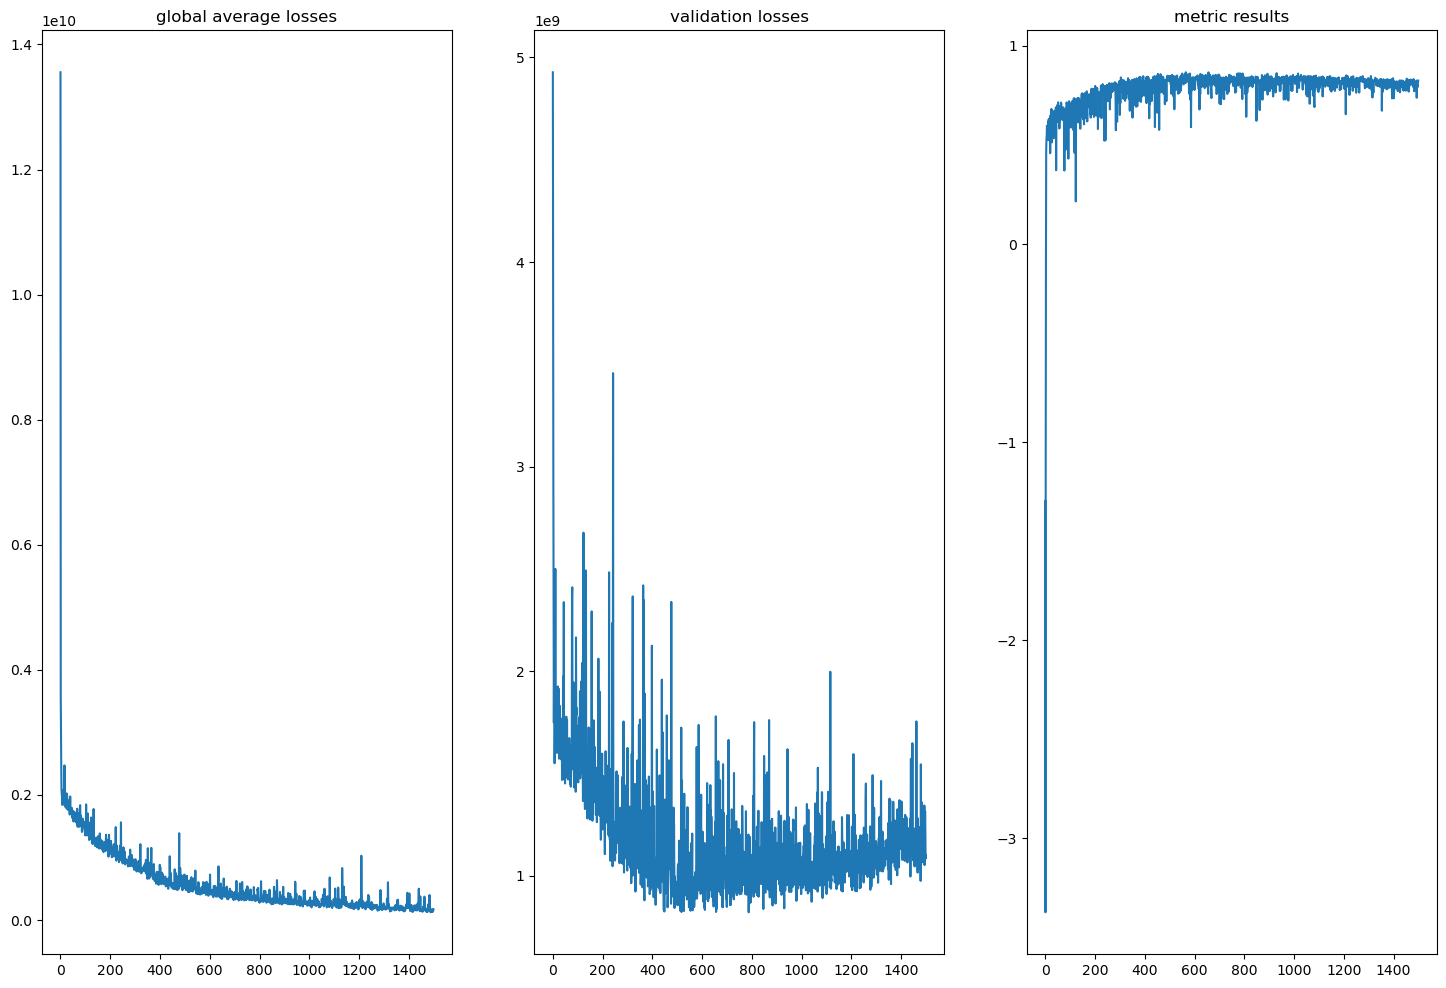

In [46]:
fig , [ax1 , ax2 , ax3] = plt.subplots(ncols = 3 , nrows = 1 , figsize = (18,12))

sns.lineplot(history['global_average_losses'] , ax = ax1)
sns.lineplot(history['validation_losses'] , ax = ax2)
sns.lineplot(history['metric_results'] , ax = ax3)

ax1.set_title('global average losses')
ax2.set_title('validation losses')
ax3.set_title('metric results')

plt.show()

## submission time!
***

In [50]:
final_test = dataset_test(x = test_df[fine_cols])
test_dataloader = DataLoader(final_test , batch_size = batch_size)

In [51]:
submission_pred = np.array([])
model.eval()
with torch.no_grad():
    for i in test_dataloader:
        i = i.to(device)
        pred = model(i).squeeze(1)
        numpy_pred = pred.cpu().numpy()
        submission_pred = np.concatenate((submission_pred , numpy_pred))

/tmp/ipykernel_200034/2034908235.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(x_row , dtype = torch.float32)


In [52]:
res = pd.DataFrame({'SalePrice' : submission_pred} , index = test['Id'])
res.to_csv('/run/media/jimmy/datasets/housing/house-prices-advanced-regression-techniques/mysubmission.csv')